

# Bibliotecas, Importações e Funções



Bibliotecas e Funções

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pandas fiona shapely pyproj rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# pip install qplot

In [ ]:
pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Libraries to open 'netcdf' file
import netCDF4 as netcdf

# To pre-process dataframe and use in visualization
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point
import h5py
import ast
# import qplot
# from qplot.qplot import quickplot

## Funções e Paths Auxiliares

In [ ]:
paths_sif_csv = {
    "janeiro-maio": '/content/drive/MyDrive/Dados_OCO-2/sif/csv/janeiro-maio/',
    "junho-setembro":'/content/drive/MyDrive/Dados_OCO-2/sif/csv/Inverno2019/',
    "outubro-novembro": '/content/drive/MyDrive/Dados_OCO-2/sif/csv/outubro-novembro2019/',
    "ultima-semana-agosto": "/content/drive/MyDrive/Dados_OCO-2/sif/csv/ultima-semana-agosto/",
    "ultima-semana-fevereiro": "/content/drive/MyDrive/Dados_OCO-2/sif/csv/ultima-semana-fevereiro/"
}

In [ ]:
paths_csv = {
    "janeiro-maio": '/content/drive/MyDrive/Dados_OCO-2/csv/janeiro-maio2019/',
    "junho-setembro":'/content/drive/MyDrive/Dados_OCO-2/csv/Inverno2019/',
    "outubro-novembro": '/content/drive/MyDrive/Dados_OCO-2/csv/outubro-novembro2019/',
    "ultima-semana-agosto": "/content/drive/MyDrive/Dados_OCO-2/csv/ultima-semana-agosto/",
    "ultima-semana-fevereiro": "/content/drive/MyDrive/Dados_OCO-2/csv/ultima-semana-fevereiro/"
}

In [ ]:
paths_shp = {
    "janeiro-maio": '/content/drive/MyDrive/Dados_OCO-2/shapefiles/janeiro-maio2019/',
    "junho-setembro":'/content/drive/MyDrive/Dados_OCO-2/shapefiles/Inverno2019/',
    "outubro-novembro": '/content/drive/MyDrive/Dados_OCO-2/shapefiles/outubro-novembro2019/',
    "ultima-semana-agosto": "/content/drive/MyDrive/Dados_OCO-2/shapefiles/ultima-semana-agosto/",
    "ultima-semana-fevereiro": "/content/drive/MyDrive/Dados_OCO-2/shapefiles/ultima-semana-fevereiro/"
}

In [ ]:
def create_datetime(lista):
  new_list = []
  for list in lista:
    # print(list)
    # print(type(list))
    conc = "".join(map(str, list))
    # print(conc)
    new_list.append(conc)
  return new_list

In [ ]:
import os

def get_list_files(path):
  directory = path
  files = []
  for filename in os.listdir(directory):
    f = os.path.join(directory, filename)

    if (os.path.isfile(f)) and ('.h5' in f):
      files.append(f)
  return files
    

In [ ]:
def do_oco2_sif_dataframe(oco2_data):
  dim = ['bands','epoch_dimension',  'footprints', 'levels', 'source_files', 'vertices', "date"]
  column_list = list(oco2_data.variables) + list(oco2_data.dimensions)
  xco2_data= pd.DataFrame(columns=column_list)
  print(len(column_list))
  for column in column_list:
    if column == 'date':
      xco2_data[column] = create_datetime(oco2_data[column][:])

    if column not in dim: 
      xco2_data[column] = oco2_data[column][:]

  return xco2_data

In [ ]:
def do_oco2_dataframe(oco2_data):
  dim = ['bands','epoch_dimension',  'footprints', 'levels', 'source_files', 'vertices', "date"]
  column_list = list(oco2_data.variables)
  xco2_data= pd.DataFrame(columns=column_list)
  print(len(column_list))
  for column in column_list:
    if column == 'date':
      xco2_data[column] = create_datetime(oco2_data[column][:])

    if column not in dim: 
      xco2_data[column] = oco2_data[column][:]

  return xco2_data


In [ ]:
def transform_dataframe_on_shapefile_and_return_geodataframe(dataframe, filename):
  print("entrou no transform")

  geometry = [Point(p) for p in zip(dataframe.retrieval_longitude, dataframe.retrieval_latitude)]
  print("criou a geometria")
  crs = 'EPSG:4674'

  geodataframe = gpd.GeoDataFrame(dataframe, crs = crs, geometry = geometry)
  print("criou o geodataframe grande")

  return geodataframe

In [ ]:
def clip_oco2_geodataframe_with_shapefile_and_return_points(limit_shp, geodataframe, filename):

  clipped_amazon = geodataframe.clip(limit_shp)
  status = "empty"
  if clipped_amazon.empty is not True:
    status = "not empty"
    print(type(clipped_amazon))
    print("clipped_amazon")
    drive_folder = '/content/drive/MyDrive/oco-2-standard/shp-legal-amazon/'+ filename + '.shp'
    clipped_amazon.to_file( drive_folder)
    print("Shape criado no path " + drive_folder)

  return status, clipped_amazon

In [ ]:
def create_shp_file_for_study_areas(csv_paths,shp_paths):
  paths = []
  shp_paths = []
  for path_ in shp_paths:
    shp_paths.append(path_[55:102])
  limit_legal_amazon = gpd.read_file('/content/Limites_Amazonia_Legal_2021.shp')
  for path in csv_paths:
    if path[42:89] not in shp_paths:
      filename = path[42:89]
      df = pd.read_csv(path)

      geodataframe = transform_dataframe_on_shapefile_and_return_geodataframe(df, filename)
      status, oco2_data =  clip_oco2_geodataframe_with_shapefile_and_return_points(limit_legal_amazon, geodataframe, filename)

      if status != 'empty':

        drive_folder = '/content/drive/MyDrive/oco-2-standard/shp-legal-amazon/'+ filename + '.csv'
        oco2_data.to_csv(drive_folder)

        paths.append(drive_folder)

        print('File was saved in ' + drive_folder)

In [ ]:
def get_dataframe_convert_and_create_geodataframe(path_list):
  for path in path_list:
    filename = path[61:67]
    dataframe = pd.read_csv(path)
    dataframe['geometry'] = dataframe['geometry_y'].apply(wkt.loads)
    crs = 'EPSG:4674'

    geodataframe = gpd.GeoDataFrame(dataframe, crs = crs)
    geodataframe.set_geometry(col='geometry', inplace=True)

    drive_folder = '/content/drive/MyDrive/terraclimate_forests/' + filename[0:4]
    print(drive_folder)
    check_if_folder_exist(drive_folder)
    geodataframe.to_file(drive_folder + '/shp/' + filename + '.shp')
    print("Arquivo shapefile salvo em " + drive_folder + '/shp/' + filename)

In [ ]:
#posição onde se encontra o nome a string
p = '/content/oco2_LtCO2_190604_B10206Ar_200729195504s.nc4'
p[20:26]

'190604'

In [ ]:
# day_inverno = f[51:57]
# day_verao = f[56:62]

In [ ]:
def create_dataframes_with_dict(path_list, key_path):
  filespath = []
  directory = paths_sif_csv[key_path]
  for filename in os.listdir(directory):
    f = os.path.join(directory, filename)

    if (os.path.isfile(f)):
      day = f[56:62]
      print("day file")
      print(day)
      filespath.append(day)
  d = {}
  for path in path_list:
    if path[20:26] not in filespath:
      print(path)
      data = netcdf.Dataset(path)
      d[path[20:26]] = do_oco2_dataframe(data)
      d[path[20:26]].to_csv( paths_sif_csv[key_path] + 'alldata_' + path[20:26] + '.csv')
      print("CSV criado no path " + paths_sif_csv[key_path] + "alldata_" + path[20:26])
  return d

In [ ]:
def create_big_dataframe_oco2(dataframe_dict,filename, key_path):
  big_dataframe = pd.concat(dataframe_dict.values(), ignore_index=True)
  print(big_dataframe.shape)
  big_path = paths_sif_csv[key_path] + filename
  big_dataframe.to_csv(big_path)
  print("Salvo")
  return big_dataframe

In [ ]:
import os

def get_list_csv_files(path):
  directory = path
  files = []
  for filename in os.listdir(directory):
    f = os.path.join(directory, filename)

    if (os.path.isfile(f)) and ('.csv' in f):
      files.append(f)
  return files

In [ ]:

def get_list_shp_files(path):
  directory = path
  files = []
  for filename in os.listdir(directory):
    f = os.path.join(directory, filename)

    if (os.path.isfile(f)) and ('.shp' in f):
      files.append(f)
  return files

In [ ]:
import os

def get_list_netcdf_files(path):
  directory = path
  files = []
  for filename in os.listdir(directory):
    f = os.path.join(directory, filename)

    if (os.path.isfile(f)) and (f[-1] == '4') and ('.nc4' in f):
      files.append(f)
      print(f)
  return files
    

In [ ]:
def create_geometry_geodataframe(value):
  value_formatted = gpd.GeoDataFrame.from_features(
  [
    {
        "type": "Feature",
        "properties": {},
        "geometry": {
            **value,
            **{"coordinates": value["coordinates"]},
        },
    }
  ]
  )
  return value_formatted

In [ ]:
# clmb_mu['geometry'] = ast.literal_eval(clmb_mu['.geo'])
def formatted_geometry(dataframe_column):
  list_geo = []
  for value in dataframe_column:
    value = ast.literal_eval(value)
    formatted = create_geometry_geodataframe(value)
    list_geo.append(formatted.geometry[0])
  return list_geo


https://oco2.gesdisc.eosdis.nasa.gov/data/OCO2_DATA/OCO2_L2_Standard.10r/

In [ ]:
pip install pydap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pydap import client
import netCDF4 as nc

# for data-preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot

In [ ]:
classPaletteSt= {
    'Formação Florestal': '#006400',
    'Formação Savânica': '#00ff00',
    'Mangue': '#687537',
    'Silvicultura': '#ad4413',
    'Campo Alagado e Área Pantanosa': '#45C2A5',
    'Formação Campestre': '#B8AF4F',
    'Pastagem': '#FFD966',
    'Cana': '#C27BA0',
    'Mosaico de Agricultura e Pastagem': '#fff3bf',
    'Praia, Duna e Areal': '#DD7E6B',
    'Área Urbana': '#aa0000',
    'Outras áreas não vegetadas': '#ff3d3d',
    'Mineração': '#af2a2a',
    "Apicum": '#968c46',
    'Rio, Lago e Oceano': '#0000FF',
    'Soja': '#e075ad',
    'Outras Lavrouras temporárias': '#e787f8',
    'Outras Lavrouras Perenes': '#cd49e4'
}

#EDA

In [ ]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
big_df_lai = pd.read_csv('/content/drive/MyDrive/oco2-standard-modis-lai/big_oco2_lai_2015_2021.csv')

In [ ]:
from shapely import wkt
big_df_lai['geometry'] = big_df_lai['geometry'].apply(wkt.loads)
geodf_lai = gpd.GeoDataFrame(big_df_lai,crs='EPSG:4627')
geodf_lai.set_geometry(col='geometry', inplace=True)


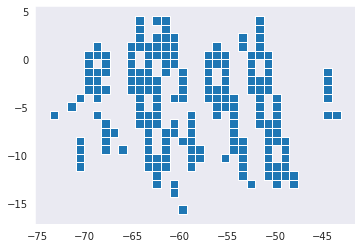

In [ ]:
geodf_lai.plot()

In [ ]:
big_df_evi = pd.read_csv('/content/drive/MyDrive/oco2-standard-modis-evi/big_oco2_evi_2015_2021.csv')

In [ ]:
from shapely import wkt
big_df_evi['geometry'] = big_df_evi['geometry'].apply(wkt.loads)
geodf_evi = gpd.GeoDataFrame(big_df_evi,crs='EPSG:4627')
geodf_evi.set_geometry(col='geometry', inplace=True)

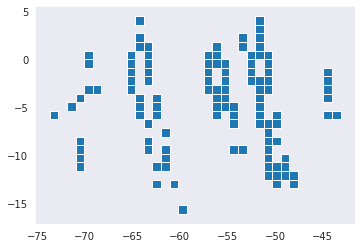

In [ ]:
geodf_evi.plot()

In [ ]:
geodf_oco2 = gpd.read_file('/content/drive/MyDrive/oco-2-standard/big_oco2_2015_2021_grid100km.shp')


In [ ]:
geodf_oco2.isna().sum()

index            0
index_righ       0
xco2             0
xco2_uncer       0
sif              0
sif_unc          0
out_flag         0
sound_id         0
latitude         0
longitude        0
land_w_ind       0
land_frac        0
sound_mode    2876
geometry         0
dtype: int64

In [ ]:
geodf_oco2 = geodf_oco2.drop(columns=['sound_mode'])

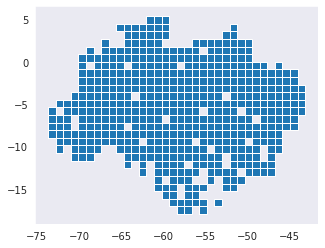

In [ ]:
geodf_oco2.plot()

In [ ]:
print(geodf_oco2.shape)
len(geodf_oco2['index'].unique())

(2876, 13)


505

In [ ]:
geodf_oco2.geometry

0       POLYGON ((-51.20397 -8.98315, -51.20397 -8.084...
1       POLYGON ((-50.30566 -7.18652, -50.30566 -8.084...
2       POLYGON ((-50.30566 -6.28821, -50.30566 -7.186...
3       POLYGON ((-52.10229 -5.38989, -52.10229 -4.491...
4       POLYGON ((-51.20397 -4.49158, -52.10229 -4.491...
                              ...                        
2871    POLYGON ((-44.91576 -7.18652, -45.81408 -7.186...
2872    POLYGON ((-45.81408 -6.28821, -45.81408 -5.389...
2873    POLYGON ((-45.81408 -3.59326, -44.91576 -3.593...
2874    POLYGON ((-45.81408 -1.79663, -46.71239 -1.796...
2875    POLYGON ((-62.88207 -7.18652, -62.88207 -8.084...
Name: geometry, Length: 2876, dtype: geometry

In [ ]:
#/content/drive/MyDrive/oco-2-standard/big_oco2_2015_2021.csv


#Funções e Bibliotecas da Rede SOM

Irei utilizar na minha dissertação dados provenientes do satélite OCO-2 e do Mapeamento de uso do Solo realizado pelo Mapbiomas. O interesse nesses dados é encontrar possíveis agrupamentos dos dados que caracterizem as classes do Mapbiomas, de modo a entender se há relação entre a quantidade de CO2 atmosférico e o uso do solo. O entendimento dessa relação agrupa elementos da terra, como uso e mudança do solo e elementos da atmosfera, como precipitação, pressão atmosférica, temperatura, entre outros.  Esse estudo será realizado em toda a região da Amazônia Legal. 

Neste Notebook serão utilizados para este estudo apenas dados de uso da solo (mapbiomas) e elementos pressão e co2 da atmosfera. Futuramente outros dados do estudo do solo e atmosfera serão utilizados para um entendimento mais detalhado das relações ditas acima. 

Os dados do OCO-2 utilizados nesse notebook no período do Inverno de 2019 foram importados via API do Earth Open Data, maior informação sobre os dados podem ser encontrados nesse [link](https://disc.gsfc.nasa.gov/datasets/OCO2_L2_Lite_FP_10r/summary) e o download dos dados e criação dos dataframes foram realizados neste [notebook](https://colab.research.google.com/drive/19wAiMcJSOhBmkkXtd3-pbByXoGQ3YfLF?usp=sharing).

Já os dados do Mapbiomas se encontram disponibilizados via Google Earth Engine, foi utilizado os dados do ano de 2019 e da coleção 6, para mais detalhes da coleção acesse [aqui](https://mapbiomas-br-site.s3.amazonaws.com/downloads/Colecction%206/Cod_Class_legenda_Col6_MapBiomas_BR.pdf). Caso queira saber mais sobre o mapbiomas, acesse [AQUI](https://mapbiomas.org/o-projeto).

A junção dos dados do Mapbiomas e os dados do OCO-2 foram feitas a partir dos recursos da Api do Google Earth Engine em Python, onde foi utilizado o algoritmo de vizinhos mais próximos para colocalizar os dados do Mapbiomas com os dados do OCO-2. Essa junção foi realizada neste [notebook](https://colab.research.google.com/drive/1PM5xyH7ZPO1Btj0IRaNMNASMVwh69voZ?usp=sharing).

Aqui será utilizado quatro recortes de dados, esses estâo enumerados e descritos abaixo.
Foi realizado o recorte da qualidade dos dados provenientes do OCO-2 nos conjuntos 3 e 4. De acordo com a documentação do OCO-2, os dados contém índices de qualidade a partir da coluna *'xco2_quality_flag'*, onde o valor é **`0`** para dados com alta qualidade e **`1`** para dados de baixa qualidade. 

Neste notebook será utilizado a rede neural SOM com os dados de CO2 atmosférico (ppm), componentes da pressão atmosférica (hPa), classes do Mapbiomas e outros dados de qualidade e sensores advindos do OCO-2. 

1. 01 de junho de 2019 a 31 de setembro de 2019
2. 20 a 31 de agosto de 2019  
3. 20 a 31 de agosto de 2019 com filtro de qualidade `xco2_quality_flag=0` .
4. 01 de junho de 2019 a 31 de setembro de 2019 com filtro de qualidade `xco2_quality_flag=0` .

A análise exploratória dos dados se encontra neste [notebook](https://colab.research.google.com/drive/1IpndRPfIx1LTd3QRoL9ReY8gH39Y9I7Y?usp=sharing)

## Importação Geral

In [ ]:
pip install plotnine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install minisom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install geobr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import geopandas as gpd

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from plotnine import *
import geobr

from sklearn.preprocessing import LabelEncoder

from minisom import MiniSom

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
import seaborn as sns

# importar os pacotes necessários

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.under_sampling import RandomUnderSampler

# configurar o estilo dos gráficos com o Seaborn
sns.set_style('dark')

In [ ]:
def print_error(som_model, data) -> None:
    """Apresenta os erros de quantização e topográficos 
    de uma instância SOM treinada
    

    Args:
        som_model (minisom.MiniSom): Instância MiniSom treinada
        
        data (np.ndarray): array n-dimensional com os dados utilizados como entrada 
        nas funções de erro
    Returns:
        None
    """
    
    for method in ['quantization_error', 'topographic_error']:
        print(f'{method}: {getattr(som_model, method)(data)}')
        

def manual_random_training(som_model, data, max_iter) -> pd.DataFrame:
    """Função para treinamento da rede SOM com amostragem aleatória.
    
    Args:
        som_model (minisom.MiniSom): Instância MiniSom treinada

        data (np.ndarray): array n-dimensional com os dados utilizados no treinamento
        
        max_iter (int): Quantidade máxima de iterações
    
    Returns:
        pd.DataFrame: Tabela com os erros de quantização e topográficos gerados
    See:
        https://github.com/JustGlowing/minisom/blob/master/examples/BasicUsage.ipynb
    """
    
    errors = {
        'qerror': [],
        'terror': []
    }
    
    for idx in range(max_iter):
        data_random = data[np.random.randint(len(data))]
        
        som_model.update(data_random, som_model.winner(data_random), idx, max_iter)
        
        errors['qerror'].append(som_model.quantization_error(data))
        errors['terror'].append(som_model.topographic_error(data))
    return pd.DataFrame(errors)

In [ ]:
def test_som_factory_with_different_learning_rate(learning_rates: list, data: np.ndarray, X_len) -> tuple:
    """Função para gerar múltiplos SOM variando a taxa de aprendizado
    
    Args:
        larning_rates (list): Lista com diversas taxas de aprendizado
        
        data (np.ndarray): array n-dimensional com os dados utilizados no treinamento
        
    Returns:
        tuple: Tuple contendo tabela com os valores de erros de quantização e topográficos para cada
        taxa de aprendizado inserida e os modelos ajustados    
    """
    
    models = {}
    results = []
    for lr in learning_rates:
        _som = MiniSom(10, 10, X_len, learning_rate=lr)
        _lr_error = manual_random_training(_som, data, 1000)
        _lr_error['label'] = lr
        _lr_error['label'] = pd.Categorical(_lr_error['label']).astype(str)
        
        models[lr] = _som
        
        results.append(_lr_error)
    return pd.concat(results), models

### Funções que serão utilizadas para visualização do resultado da rede

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

from bokeh.colors import RGB
from bokeh.io import curdoc, show, output_notebook
from bokeh.transform import factor_mark, factor_cmap
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, output_file

# display matplotlib plots in notebook
%matplotlib inline
# display bokeh plot in notebook
output_notebook()

In [ ]:
def plot_clusters_for_som(X, cluster_index, position_latitude, position_longitude):
  plt.figure(figsize=(12, 6), dpi=80)
  teste = []

  # plotting the clusters using the first 2 dimentions of the X
  for c in np.unique(cluster_index):
    plt.scatter(X[cluster_index == c, position_longitude],
                  X[cluster_index == c, position_latitude], label='cluster='+str(c), alpha=.7)

  # # plotting centroids
  # for centroid in som.get_weights():
  #     plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
  #                 s=80, linewidths=35, color='k', label='centroid')
  # plt.legend(loc='best');
  plt.title("Self Organising Map - Clustering")
  plt.xlabel("Longitude")
  plt.ylabel("Latitude")

  teste.append(c)

  return teste

In [ ]:
def create_umatrix_hitmap_heatmap(som, X, enum_errors, y):
# plots
  fig, ax = plt.subplots(3, 1, figsize=(14, 30), dpi=120)
  eq = som.quantization_error(X)
  # et = som.topographic_error(X)

  #u-matrix
  ax[0].imshow(som.distance_map().T, cmap='Blues')

  markers = {'Formação Florestal': 'o', 'Formação Savânica': 'v', 'Formação Campestre': '>', 'Pastagem': '<', 'Soja': '1', 'Mangue': "8", "Rio, Lago e Oceano": "s", "Mosaico de Agricultura e Pastagem": "P", "Apicum": "*", "Campo Alagado e Área Pantanosa": "+", "Área Urbana": "D", 'Silvicultura': "d", 'Outras Lavrouras temporárias': "X", 'Outras áreas não vegetadas': "4", "Praia, Duna e Areal": '^', 'Outras Lavrouras Perenes': "4", "Cana": "1", 'Mineração': '8' }
  colors = {'Formação Florestal': 'C2', 'Formação Savânica': 'C8', 'Formação Campestre': 'C4', 'Pastagem': 'C1', 'Soja': 'C6', 'Mangue': "C9", "Rio, Lago e Oceano": "C0", "Mosaico de Agricultura e Pastagem": "C7", "Apicum": "C5", "Campo Alagado e Área Pantanosa": "C3", "Área Urbana": "#ffffff", 'Silvicultura': "#000000", 'Outras Lavrouras temporárias': "violet", 'Outras áreas não vegetadas': "aqua", "Praia, Duna e Areal": 'green', 'Outras Lavrouras Perenes': "blue", "Cana": "black", 'Mineração': 'red' }
  for i, x in enumerate(X):
    if i not in enum_errors:
      w = som.winner(x)
      marker = markers[y[i]]
      color = colors[y[i]]
      ax[0].plot(w[0], w[1], marker, markerfacecolor='None',
              markeredgecolor=color, markersize=12, markeredgewidth=2)
  ax[0].set_title('SOM U-Matrix Mapbiomas\nlr: %s, sig: %s, erro_q: %.2f\nneighborhood_function: %s'%(lr, sig, eq, func))

  #hitmap
  freq = som.activation_response(X).astype(int)
  cmap = ax[1].imshow(freq.T, cmap='PuBu') 
  for (i, j), z in np.ndenumerate(freq.T):
      color = 'w' if z > freq.T.max()/2 else 'k'
      ax[1].text(j, i, z, ha='center', va='center', color=color)
  ax[1].set_title('SOM Hitmap Mapbiomas\nlr: %s, sig: %s, erro_q: %.2f\nneighborhood_function: %s'%(lr, sig, eq, func))

  #heatmap
  dm = som.distance_map()
  ax[2].imshow(dm, cmap="Reds")
  for i in range(dm.shape[0]):
      for j in range(dm.shape[1]):
          color = 'w' if dm[i][j] > dm.max()/2 else 'k'
          ax[2].text(j, i, '%.2f'%dm[i][j], ha='center', va='center', color=color)
  ax[2].set_title('Heatmap Mapbiomas\nlr: %s, sig: %s, erro_q: %.2f\nneighborhood_function: %s'%(lr, sig, eq, func))

In [ ]:
def create_hexagonal_topology_with_markers(som, X, y, xx, yy, umatrix, weights, legend_elements, enum_errors, filename):
  f = plt.figure(figsize=(20,20))
  ax = f.add_subplot(111)

  ax.set_aspect('equal')

  # iteratively add hexagons
  for i in range(weights.shape[0]):
      for j in range(weights.shape[1]):
          wy = yy[(i, j)] * np.sqrt(3) / 2
          hex = RegularPolygon((xx[(i, j)], wy), 
                              numVertices=6, 
                              radius=.95 / np.sqrt(3),
                              facecolor=cm.Blues(umatrix[i, j]), 
                              alpha=.8, 
                              edgecolor='black')
          ax.add_patch(hex)

  markers = {'Formação Florestal': 'o', 'Formação Savânica': 'v', 'Formação Campestre': '>', 'Pastagem': '<', 'Soja': '1', 'Mangue': "8", "Rio, Lago e Oceano": "s", "Mosaico de Agricultura e Pastagem": "P", "Apicum": "*", "Campo Alagado e Área Pantanosa": "+", "Área Urbana": "D", 'Silvicultura': "d", 'Outras Lavrouras temporárias': "X", 'Outras áreas não vegetadas': "4", "Praia, Duna e Areal": '^', 'Outras Lavrouras Perenes': "4", "Cana": "1", 'Mineração': '8' }
  colors = {'Formação Florestal': 'C2', 'Formação Savânica': 'C8', 'Formação Campestre': 'C4', 'Pastagem': 'C1', 'Soja': 'C6', 'Mangue': "C9", "Rio, Lago e Oceano": "C0", "Mosaico de Agricultura e Pastagem": "C7", "Apicum": "C5", "Campo Alagado e Área Pantanosa": "C3", "Área Urbana": "#ffffff", 'Silvicultura': "#000000", 'Outras Lavrouras temporárias': "violet", 'Outras áreas não vegetadas': "aqua", "Praia, Duna e Areal": 'green', 'Outras Lavrouras Perenes': "blue", "Cana": "black", 'Mineração': 'red' }

  for i, x in enumerate(X):
    if i not in enum_errors:
      w = som.winner(x)
      # place a marker on the winning position for the sample xx
      wx, wy = som.convert_map_to_euclidean(w) 
      wy = wy * np.sqrt(3) / 2
      marker = markers[y[i]]
      color = colors[y[i]]
      plt.plot(wx, wy, 
              marker, 
              markerfacecolor='None',
              markeredgecolor=color, 
              markersize=12, 
              markeredgewidth=2
              )
      

  xrange = np.arange(weights.shape[0])
  yrange = np.arange(weights.shape[1])
  plt.xticks(xrange-.5, xrange)
  plt.yticks(yrange * np.sqrt(3) / 2, yrange)

  divider = make_axes_locatable(plt.gca())
  ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
  cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                              orientation='vertical', alpha=.8)
  cb1.ax.get_yaxis().labelpad = 16
  cb1.ax.set_ylabel('distance from neurons in the neighbourhood',
                    rotation=270, fontsize=16)
  plt.gcf().add_axes(ax_cb)

  ax.legend(handles=legend_elements, bbox_to_anchor=(0.1, 1.08), loc='best', 
            borderaxespad=0., ncol=3, fontsize=14)

  plt.savefig(filename, format='png')
  plt.show()

In [ ]:
def create_hexagonal_topology__makers_html(som, X, y, xx, yy, umatrix, weights, legend_elements, enum_errors):

  hex_centre_col, hex_centre_row = [], []
  hex_colour = []
  label = []

  # define labels
  SPECIES = y.unique()

  for i in range(weights.shape[0]):
      for j in range(weights.shape[1]):
          wy = yy[(i, j)] * np.sqrt(3) / 2
          hex_centre_col.append(xx[(i, j)])
          hex_centre_row.append(wy)
          hex_colour.append(cm.GnBu(umatrix[i, j]))

  weight_x, weight_y = [], []
        
  for cnt, i in enumerate(X):
    if cnt not in enum_errors:

      w = som.winner(i)
      wx, wy = som.convert_map_to_euclidean(xy=w)
      wy = wy * np.sqrt(3) / 2
      weight_x.append(wx)
      weight_y.append(wy)
      label.append(y[cnt])
      
  # convert matplotlib colour palette to bokeh colour palette
  hex_plt = [(255 * np.array(i)).astype(int) for i in hex_colour]
  hex_bokeh = [RGB(*tuple(rgb)).to_hex() for rgb in hex_plt]

  # initialise figure/plot
  fig = figure(title="SOM: Hexagonal Topology",
              plot_height=900, plot_width=1100,
              match_aspect=True,
              tools="wheel_zoom,save,reset", hidpi=True)

  # create data stream for plotting
  source_hex = ColumnDataSource(
      data = dict(
          x=hex_centre_col,
          y=hex_centre_row,
          c=hex_bokeh
      )
  )

  source_pages = ColumnDataSource(
      data=dict(
          wx=weight_x,
          wy=weight_y,
          species=label
      )
  )

  # define markers
  MARKERS = [ 'asterisk', 'circle', 'circle_cross', 'circle_dot', 'circle_x', 'circle_y', 'cross', 'dash', 'diamond', 'diamond_cross', 'diamond_dot', 'dot', 'hex', 'hex_dot', 'inverted_triangle', 'plus', 'square', 'square_cross', 'square_dot', 'square_pin', 'square_x', 'star', 'star_dot', 'triangle', 'triangle_dot', 'triangle_pin', 'x', 'y' ]

  # add shapes to plot
  fig.hex(x='x', y='y', source=source_hex,
          size=100 * (.95 / np.sqrt(3)),
          alpha=.8,
          line_color='black',
          fill_color='c')

  fig.scatter(x='wx', y='wy', source=source_pages, 
              legend_field='species',
              size=20, 
              marker=factor_mark(field_name='species', markers=MARKERS, factors=SPECIES),
              color=factor_cmap(field_name='species', palette='Category20_13', factors=SPECIES))

  # add hover-over tooltip
  fig.add_tools(HoverTool(
      tooltips=[
          ("label", '@species'),
          ("(x,y)", '($x, $y)')],
      mode="mouse", 
      point_policy="follow_mouse"
  ))

  fig.legend.location = 'bottom_right'
  show(fig)

In [ ]:
classPalette = {
    3: '#006400',
    4: '#00ff00',
    5: '#687537',
    9: '#ad4413',
    11: '#45C2A5',
    12: '#B8AF4F',
    15: '#FFD966',
    20: '#C27BA0',
    21: '#fff3bf',
    23: '#DD7E6B',
    24: '#aa0000',
    25: '#ff3d3d',
    30: '#af2a2a',
    32: '#968c46',
    33: '#0000FF',
    39: '#e075ad',
    41: '#e787f8',
    48: '#cd49e4'
}

In [ ]:
classPaletteSt= {
    'Formação Florestal': '#006400',
    'Formação Savânica': '#00ff00',
    'Mangue': '#687537',
    'Silvicultura': '#ad4413',
    'Campo Alagado e Área Pantanosa': '#45C2A5',
    'Formação Campestre': '#B8AF4F',
    'Pastagem': '#FFD966',
    'Cana': '#C27BA0',
    'Mosaico de Agricultura e Pastagem': '#fff3bf',
    'Praia, Duna e Areal': '#DD7E6B',
    'Área Urbana': '#aa0000',
    'Outras áreas não vegetadas': '#ff3d3d',
    'Mineração': '#af2a2a',
    "Apicum": '#968c46',
    'Rio, Lago e Oceano': '#0000FF',
    'Soja': '#e075ad',
    'Outras Lavrouras temporárias': '#e787f8',
    'Outras Lavrouras Perenes': '#cd49e4'
}

In [ ]:
 {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" }

{3.0: 'Formação Florestal',
 4.0: 'Formação Savânica',
 12.0: 'Formação Campestre',
 15.0: 'Pastagem',
 39.0: 'Soja',
 5.0: 'Mangue',
 33.0: 'Rio, Lago e Oceano',
 21.0: 'Mosaico de Agricultura e Pastagem',
 32.0: 'Apicum',
 11.0: 'Campo Alagado e Área Pantanosa',
 24.0: 'Área Urbana',
 9.0: 'Silvicultura',
 41.0: 'Outras Lavrouras temporárias',
 25.0: 'Outras áreas não vegetadas',
 48.0: 'Outras Lavrouras Perenes',
 20.0: 'Cana',
 30: 'Mineração',
 23: 'Praia, Duna e Areal'}

In [ ]:
def normalize_dataframe(df):
  df_min_max_scaled = df.copy() 
  for column in df_min_max_scaled.columns: 
      df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())     
  return df_min_max_scaled

In [ ]:
legend_elements = [Line2D([0], [0], marker='o', color='C2', label='Formação Florestal',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='<', color='C1', label='Pastagem',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='v', color='C8', label='Formação Savânica',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='1', color='C6', label='Soja',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='>', color='C4', label='Formação Campestre',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='+', color='C3', label='Campo Alagado e Área Pantanosa',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='s', color='C0', label='Rio, Lago e Oceano',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='P', color='C7', label='Mosaico de Agricultura e Pastagem',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='X', color='pink', label='Outras Lavrouras Temporárias',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='d', color='#000000', label='Silvicultura',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='D', color='violet', label='Área Urbana',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='4', color='aqua', label='Outras áreas não vegetadas',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='8', color='red', label='Mangue',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='s', color='black', label='Outras Lavrouras Perenes',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='p', color='C9', label="Praia, Duna e Areal",
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='X', color='C5', label="Cana",
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='8', color='green', label='Mineração',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2)
                   ]


In [ ]:
def get_results_from_model_and_save(X, list_columns, cluster_index, df_origin):

  df_result = pd.DataFrame(X, columns=list_columns)
  df_result['cluster_index'] = cluster_index
  # df_result['classes'] = df_origin['classification_2019']
  df_result['index'] = df_origin['index']
  df_result['geometry'] = df_origin['geometry']

  # df_result.to_csv()

  return df_result

# Importação e Preparação dos Dados OCO-2

Dados do satélite OCO-2 para o período entre os dias 01-08-2015 e 31-09-2021

In [ ]:
print(geodf_oco2.isna().sum())
print(geodf_oco2.shape)

index         0
index_righ    0
xco2          0
xco2_uncer    0
sif           0
sif_unc       0
out_flag      0
sound_id      0
latitude      0
longitude     0
land_w_ind    0
land_frac     0
geometry      0
dtype: int64
(2876, 13)


In [ ]:
geodf_oco2.columns

Index(['index', 'index_righ', 'xco2', 'xco2_uncer', 'sif', 'sif_unc',
       'out_flag', 'sound_id', 'latitude', 'longitude', 'land_w_ind',
       'land_frac', 'geometry'],
      dtype='object')

In [ ]:
print(geodf_oco2.xco2.describe())

count    2876.000000
mean      402.500699
std         5.252416
min       389.617200
25%       397.646786
50%       402.237098
75%       406.689805
max       418.768100
Name: xco2, dtype: float64


In [ ]:
print(geodf_oco2.sif.describe())

count    2.876000e+03
mean     2.492701e+18
std      1.091064e+18
min     -5.152786e+18
25%      1.982430e+18
50%      2.615456e+18
75%      3.114488e+18
max      1.097639e+19
Name: sif, dtype: float64


In [ ]:
geodf_oco2['datetime'] = pd.to_datetime(geodf_oco2['sound_id'], format='%Y%m%d%H%M%S%f')
geodf_oco2['day_date'] = [d.date() for d in geodf_oco2['datetime']]
geodf_oco2['day_date'] = [d.isoformat() for d in geodf_oco2['day_date']]
geodf_oco2['day_time'] = [d.time()for d in geodf_oco2['datetime']]
geodf_oco2['day_time'] = [d.isoformat() for d in geodf_oco2['day_time']]

In [ ]:
geodf_oco2.columns

Index(['index', 'index_righ', 'xco2', 'xco2_uncer', 'sif', 'sif_unc',
       'out_flag', 'sound_id', 'latitude', 'longitude', 'land_w_ind',
       'land_frac', 'geometry', 'datetime', 'day_date', 'day_time'],
      dtype='object')

Limpando o Dataframe

In [ ]:
geodf_oco2 = geodf_oco2.drop(columns=['index_righ'])
geodf_oco2 = geodf_oco2.dropna()

In [ ]:
#Tem células que se repetem (verificar a data de cada uma delas, é possivel identificar mudança de uso do solo?)
len(geodf_oco2.index.unique())

2876

In [ ]:
geodf_oco2.head(2)

index        xco2  xco2_uncer           sif       sif_unc  out_flag  \
0   211  408.556060    0.411717  1.576585e+18  4.374062e+17       1.0   
1   244  410.692963    0.490378  2.710206e+18  4.475204e+17       1.0   

       sound_id  latitude  longitude  land_w_ind  land_frac  \
0  2.020080e+15 -8.514833 -50.790123         0.0      100.0   
1  2.020080e+15 -7.392064 -51.021058         0.0      100.0   

                                            geometry                datetime  \
0  POLYGON ((-51.20397 -8.98315, -51.20397 -8.084... 2020-08-01 17:04:10.760   
1  POLYGON ((-50.30566 -7.18652, -50.30566 -8.084... 2020-08-01 17:04:29.280   

     day_date         day_time  
0  2020-08-01  17:04:10.760000  
1  2020-08-01  17:04:29.280000

In [ ]:
# (
#     ggplot(df_co2) 
#     + aes(x='classification_2019', fill='factor(classification_2019)', color='factor(classification_2019)') 
#     + geom_bar()
#     + scale_color_manual(values=classPalette)
#     + scale_fill_manual(values=classPalette)
#     + theme(axis_text_x=element_text(rotation=90, hjust=1))
#     + theme(figure_size=(8, 5), panel_background=element_rect(fill='white'))
#     + labs(title='Distribuição dos dados por Classe', x='Classe', y='Contagem')

# )

É possível identificar uma correlação positiva de aproximadamente 0.3 entre os componentes da pressão atmosférica pressure_level e pressure_weight com a latitude  e uma correlação negativa dos mesmos componentes com a longitude, aproximadamente -0.44 e -0.69. Houve uma leve correlação positiva, em torno de 0.1 entre o xco2 e a pressure_weight e uma correlação negativa com a longitude.

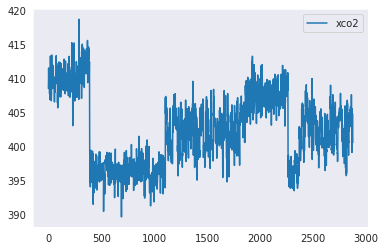

In [ ]:
geodf_oco2.xco2.plot(legend=True)

In [ ]:
geodf_oco2_clean = geodf_oco2.drop(columns=['index','day_date', 'day_time', 'datetime', 'out_flag', 'sound_id','geometry', 'land_w_ind', 'land_frac'])

In [ ]:
geodf_oco2_clean = geodf_oco2_clean[geodf_oco2_clean.sif > 0]

In [ ]:
geodf_oco2_clean.corr()

xco2  xco2_uncer       sif   sif_unc  latitude  longitude
xco2        1.000000    0.230089  0.078481  0.107513  0.047773  -0.138093
xco2_uncer  0.230089    1.000000  0.056820  0.041710 -0.209956  -0.326438
sif         0.078481    0.056820  1.000000  0.592932  0.159968  -0.199954
sif_unc     0.107513    0.041710  0.592932  1.000000  0.212088  -0.185647
latitude    0.047773   -0.209956  0.159968  0.212088  1.000000   0.048620
longitude  -0.138093   -0.326438 -0.199954 -0.185647  0.048620   1.000000

In [ ]:
geodf_oco2_norm = normalize_dataframe(geodf_oco2_clean)

In [ ]:
geodf_oco2_norm.head()

xco2  xco2_uncer       sif   sif_unc  latitude  longitude
0  0.727862    0.046105  0.142983  0.707222  0.388503   0.766286
1  0.809988    0.105914  0.246339  0.724531  0.438456   0.758336
2  0.842940    0.102310  0.282210  0.776264  0.453306   0.756157
3  0.811405    0.164997  0.270738  0.782451  0.554139   0.738994
4  0.828853    0.192138  0.290058  0.800412  0.573991   0.736276

In [ ]:
# print(geodf_evi_norm[geodf_evi_norm.columns[-1]].head())
# y_treino=y_treino.astype('int')
print(geodf_oco2_norm[geodf_oco2_norm.columns[0:10]].head())

       xco2  xco2_uncer       sif   sif_unc  latitude  longitude
0  0.727862    0.046105  0.142983  0.707222  0.388503   0.766286
1  0.809988    0.105914  0.246339  0.724531  0.438456   0.758336
2  0.842940    0.102310  0.282210  0.776264  0.453306   0.756157
3  0.811405    0.164997  0.270738  0.782451  0.554139   0.738994
4  0.828853    0.192138  0.290058  0.800412  0.573991   0.736276


# Rede SOM com os dados OCO2 somente




In [ ]:
# dfs_co2['classification_2019'] = dfs_co2['classification_2019'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas' })

In [ ]:
geodf_oco2_norm.iloc[:, 0:].head()

xco2  xco2_uncer       sif   sif_unc  latitude  longitude
0  0.727862    0.046105  0.142983  0.707222  0.388503   0.766286
1  0.809988    0.105914  0.246339  0.724531  0.438456   0.758336
2  0.842940    0.102310  0.282210  0.776264  0.453306   0.756157
3  0.811405    0.164997  0.270738  0.782451  0.554139   0.738994
4  0.828853    0.192138  0.290058  0.800412  0.573991   0.736276

In [ ]:
# Escolha dos preditores
X = geodf_oco2_norm.iloc[:, 0:].values
# y1 = dfs_co2[dfs_co2.columns[-1]]

In [ ]:
# ver o balanceamento das classes
# print(pd.Series(y1).value_counts())


### Geolocalização dos pontos

In [ ]:
# gdf_co2 = gpd.GeoDataFrame(df_co2, geometry = gpd.points_from_xy(df_co2.longitude, df_co2.latitude))

In [ ]:
# importar shapefiles de estados brasileiros
geo_ufs = geobr.read_state(code_state = 'all', year = 2019)
geo_ufs.head()

code_state abbrev_state name_state  code_region name_region  \
0        11.0           RO   Rondônia          1.0       Norte   
1        12.0           AC       Acre          1.0       Norte   
2        13.0           AM   Amazônas          1.0       Norte   
3        14.0           RR    Roraima          1.0       Norte   
4        15.0           PA       Pará          1.0       Norte   

                                            geometry  
0  MULTIPOLYGON (((-65.38150 -10.42907, -65.37916...  
1  MULTIPOLYGON (((-71.07772 -9.82774, -71.08554 ...  
2  MULTIPOLYGON (((-69.83766 -3.68659, -69.71230 ...  
3  MULTIPOLYGON (((-63.96008 2.47313, -63.96041 2...  
4  MULTIPOLYGON (((-51.43248 -0.47334, -51.42843 ...

## Modelo


Parâmetros da Rede:

    neighborhood_function: gaussian
    learning_rate: 1.0
    sigma: 2.0
    activation_distance: euclidean
    topology: hexagonal
    X_length: 6
    grid: 10 x 10
    num_interations = 10000

Uso do PCA para inicializar os pesos da rede. 

In [ ]:

functions = ['gaussian', 'mexican_hat', 'bublle', 'triangle']
func, lr, sig = functions[0], 1.0, 2.0
som_1_shape = (5, 5)
som_1 = MiniSom(x=5, y=5, input_len=6, sigma=sig, learning_rate=lr, activation_distance='euclidean',topology='hexagonal', 
             neighborhood_function=func)
som_1.pca_weights_init(X)
som_1.train(X, num_iteration=10000, verbose=True)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.2440097241828529


In [ ]:
X.shape

(2818, 6)

In [ ]:
X

array([[0.727862  , 0.04610519, 0.14298256, 0.70722198, 0.38850321,
        0.76628621],
       [0.80998787, 0.10591429, 0.24633933, 0.72453064, 0.43845602,
        0.75833555],
       [0.84293972, 0.10230974, 0.2822095 , 0.77626367, 0.45330609,
        0.75615675],
       ...,
       [0.54609519, 0.14062524, 0.38194696, 0.89009733, 0.56948297,
        0.94605988],
       [0.48950625, 0.148942  , 0.20665687, 0.78842211, 0.71633401,
        0.923729  ],
       [0.42098657, 0.18854558, 0.16422969, 0.72243561, 0.41954983,
        0.32252985]])

In [ ]:
# each neuron represents a cluster
winner_coordinates_1 = np.array([som_1.winner(x) for x in X]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index_1 = np.ravel_multi_index(winner_coordinates_1, som_1_shape)

In [ ]:
geodf_oco2.columns

Index(['index', 'xco2', 'xco2_uncer', 'sif', 'sif_unc', 'out_flag', 'sound_id',
       'latitude', 'longitude', 'land_w_ind', 'land_frac', 'geometry',
       'datetime', 'day_date', 'day_time'],
      dtype='object')

In [ ]:
geodf_oco2_norm.columns

Index(['xco2', 'xco2_uncer', 'sif', 'sif_unc', 'latitude', 'longitude'], dtype='object')

In [ ]:
list_col = ['xco2', 'xco2_uncer', 'sif', 'sif_unc', 'latitude', 'longitude']

df_result = get_results_from_model_and_save(X, list_col, cluster_index_1, geodf_oco2)

In [ ]:
df_result.head(10)

xco2  xco2_uncer       sif   sif_unc  latitude  longitude  \
0  0.727862    0.046105  0.142983  0.707222  0.388503   0.766286   
1  0.809988    0.105914  0.246339  0.724531  0.438456   0.758336   
2  0.842940    0.102310  0.282210  0.776264  0.453306   0.756157   
3  0.811405    0.164997  0.270738  0.782451  0.554139   0.738994   
4  0.828853    0.192138  0.290058  0.800412  0.573991   0.736276   
5  0.806190    0.203104  0.264616  0.770487  0.610416   0.730192   
6  0.842191    0.074883  0.269655  0.912987  0.649165   0.722405   
7  0.768966    0.106201  0.254504  0.763397  0.712366   0.713289   
8  0.781844    0.187628  0.213887  0.822514  0.759658   0.705443   
9  0.786724    0.240757  0.359576  0.832286  0.779461   0.702376   

   cluster_index index                                           geometry  
0             13   211  POLYGON ((-51.20397 -8.98315, -51.20397 -8.084...  
1             19   244  POLYGON ((-50.30566 -7.18652, -50.30566 -8.084...  
2             19   278  POLYGON ((-50.30566 -6.28821, -50.30566 -7.186...  
3             18   345  POLYGON ((-52.10229 -5.38989, -52.10229 -4.491...  
4             12   377  POLYGON ((-51.20397 -4.49158, -52.10229 -4.491...  
5             12   407  POLYGON ((-52.10229 -2.69495, -51.20397 -2.694...  
6             23   437  POLYGON ((-52.10229 -2.69495, -52.10229 -1.796...  
7             23   466  POLYGON ((-52.10229 -0.89832, -52.10229 -1.796...  
8             23   495  POLYGON ((-52.10229 0.00000, -52.10229 -0.8983...  
9             11   522  POLYGON ((-53.00060 0.89832, -52.10229 0.89832...

In [ ]:
list_clusters = df_result.cluster_index.unique()

In [ ]:
for cluster in list_clusters:
  print(cluster, df_result[df_result.cluster_index == cluster].shape)

13 (64, 9)
19 (133, 9)
18 (148, 9)
12 (167, 9)
23 (167, 9)
11 (251, 9)
3 (133, 9)
15 (95, 9)
1 (140, 9)
6 (57, 9)
4 (61, 9)
9 (238, 9)
10 (96, 9)
22 (37, 9)
2 (134, 9)
5 (104, 9)
0 (74, 9)
14 (119, 9)
16 (16, 9)
17 (30, 9)
8 (154, 9)
24 (147, 9)
7 (140, 9)
20 (111, 9)
21 (2, 9)


In [ ]:
from shapely import wkt
# df_result['geometry'] = df_result['geometry'].apply(wkt.loads)
geodf_result_oco2 = gpd.GeoDataFrame(df_result)
# geodf_result_evi.set_geometry(col='geometry', inplace=True)

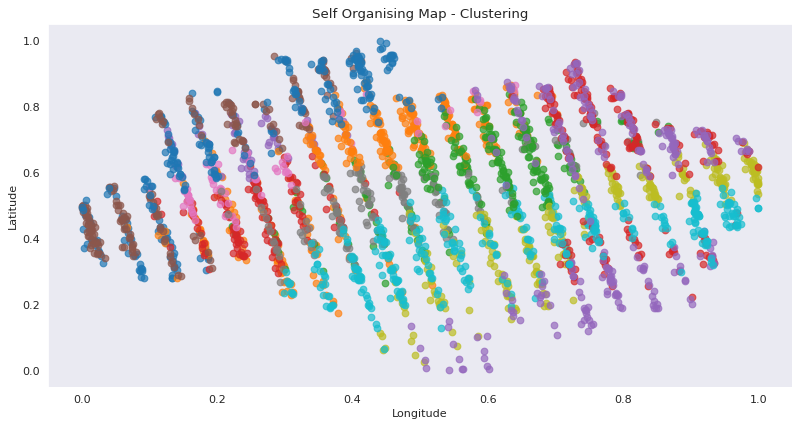

In [ ]:
a = plot_clusters_for_som(X, cluster_index_1, 4, 5)

In [ ]:
xx_1, yy_1 = som_1.get_euclidean_coordinates()
umatrix_1 = som_1.distance_map()
weights_1 = som_1.get_weights()

In [ ]:
# y1 = y1.dropna()
# y1 = y1.map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })

In [ ]:
# y1.unique()

In [ ]:
enum_errors_1 = []

In [ ]:
mapbiomas = pd.read_csv('/content/drive/MyDrive/oco-2_mapbiomas inverno-2015a2021/oco2-mapbiomas-inverno-Grid_Amazonia_Legal_100km.csv')
mapbiomas.index

RangeIndex(start=0, stop=592, step=1)

In [ ]:
mapbiomas['geometry'] = formatted_geometry(mapbiomas['.geo'])
mapbiomas_geo = gpd.GeoDataFrame(mapbiomas)
mapbiomas_geo = mapbiomas_geo.set_crs('EPSG:4674')

In [ ]:
mapbiomas_geo = mapbiomas_geo.drop(columns=['.geo'])

In [ ]:
#{'intersects', 'crosses', 'contains_properly', 'overlaps', 'touches', 'contains', 'within', None, 'covers', 'covered_by'}

In [ ]:
# teste = gpd.tools.sjoin(geodf_result_oco2,mapbiomas_geo,predicate='within', how='left')

In [ ]:
geodf_result_oco2.head(3)

xco2  xco2_uncer       sif   sif_unc  latitude  longitude  \
0  0.727862    0.046105  0.142983  0.707222  0.388503   0.766286   
1  0.809988    0.105914  0.246339  0.724531  0.438456   0.758336   
2  0.842940    0.102310  0.282210  0.776264  0.453306   0.756157   

   cluster_index index                                           geometry  
0             13   211  POLYGON ((-51.20397 -8.98315, -51.20397 -8.084...  
1             19   244  POLYGON ((-50.30566 -7.18652, -50.30566 -8.084...  
2             19   278  POLYGON ((-50.30566 -6.28821, -50.30566 -7.186...

In [ ]:
len(geodf_result_oco2['index'].unique())

505

In [ ]:
mapbiomas_geo.index

RangeIndex(start=0, stop=592, step=1)

In [ ]:
t = geodf_result_oco2.set_index('index')

In [ ]:
mapbiomas_geo['index'] = mapbiomas_geo.index

In [ ]:
mapbiomas_geo['index']

0        0
1        1
2        2
3        3
4        4
      ... 
587    587
588    588
589    589
590    590
591    591
Name: index, Length: 592, dtype: int64

In [ ]:
data_types_dict = {'index': int}
geodf_result_oco2 = geodf_result_oco2.astype(data_types_dict)


In [ ]:
a = pd.merge(geodf_result_oco2,mapbiomas_geo,'inner','index')

In [ ]:
print(t.shape)
print(a.shape)
print(mapbiomas_geo.shape)

(2818, 8)
(2818, 47)
(592, 39)


In [ ]:
a.columns

Index(['xco2', 'xco2_uncer', 'sif', 'sif_unc', 'latitude', 'longitude',
       'cluster_index', 'index', 'geometry_x', 'system:index',
       'classification_1985', 'classification_1986', 'classification_1987',
       'classification_1988', 'classification_1989', 'classification_1990',
       'classification_1991', 'classification_1992', 'classification_1993',
       'classification_1994', 'classification_1995', 'classification_1996',
       'classification_1997', 'classification_1998', 'classification_1999',
       'classification_2000', 'classification_2001', 'classification_2002',
       'classification_2003', 'classification_2004', 'classification_2005',
       'classification_2006', 'classification_2007', 'classification_2008',
       'classification_2009', 'classification_2010', 'classification_2011',
       'classification_2012', 'classification_2013', 'classification_2014',
       'classification_2015', 'classification_2016', 'classification_2017',
       'classification_2018',

In [ ]:
len(a['system:index'].unique())

505

In [ ]:
a['classification_2020'] = a['classification_2020'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })

In [ ]:
a['classification_2015'] = a['classification_2015'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })
a['classification_2016'] = a['classification_2016'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })
a['classification_2017'] = a['classification_2017'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })
a['classification_2018'] = a['classification_2018'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })
a['classification_2019'] = a['classification_2019'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })

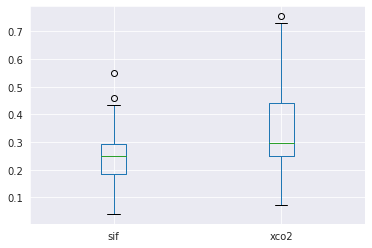

In [ ]:
a[a.cluster_index == 8].boxplot(column=['sif', 'xco2'])

In [ ]:
for cluster in list_clusters:
  print(cluster, a[a.cluster_index == cluster].shape, a[a.cluster_index == cluster]['classification_2020'].unique())


13 (64, 47) ['Pastagem' 'Formação Florestal' 'Campo Alagado e Área Pantanosa'
 'Formação Campestre']
19 (133, 47) ['Formação Florestal' 'Pastagem' 'Formação Campestre' 'Formação Savânica'
 'Campo Alagado e Área Pantanosa']
18 (148, 47) ['Formação Florestal' 'Pastagem' 'Formação Savânica'
 'Campo Alagado e Área Pantanosa' 'Formação Campestre']
12 (167, 47) ['Pastagem' 'Formação Florestal' 'Formação Savânica' 'Rio, Lago e Oceano'
 'Campo Alagado e Área Pantanosa' 'Formação Campestre']
23 (167, 47) ['Formação Florestal' 'Pastagem' 'Formação Campestre' 'Rio, Lago e Oceano'
 'Formação Savânica' 'Campo Alagado e Área Pantanosa']
11 (251, 47) ['Formação Florestal' 'Pastagem' 'Formação Savânica' 'Formação Campestre'
 'Campo Alagado e Área Pantanosa' 'Mangue' 'Soja']
3 (133, 47) ['Formação Florestal' 'Pastagem' 'Formação Savânica'
 'Campo Alagado e Área Pantanosa' 'Formação Campestre']
15 (95, 47) ['Formação Florestal' 'Pastagem' 'Rio, Lago e Oceano'
 'Campo Alagado e Área Pantanosa' 'Formação 

In [ ]:
a.to_csv('/content/drive/MyDrive/resultados-oco2-som/5x5-100km-08-09-2015-2021-oco2.csv')
# a.to_file('/content/drive/MyDrive/resultados-oco2-som/5x5-100km-08-09-2015-2021-oco2.shp')

In [ ]:
a.columns

Index(['xco2', 'xco2_uncer', 'sif', 'sif_unc', 'latitude', 'longitude',
       'cluster_index', 'index', 'geometry_x', 'system:index',
       'classification_1985', 'classification_1986', 'classification_1987',
       'classification_1988', 'classification_1989', 'classification_1990',
       'classification_1991', 'classification_1992', 'classification_1993',
       'classification_1994', 'classification_1995', 'classification_1996',
       'classification_1997', 'classification_1998', 'classification_1999',
       'classification_2000', 'classification_2001', 'classification_2002',
       'classification_2003', 'classification_2004', 'classification_2005',
       'classification_2006', 'classification_2007', 'classification_2008',
       'classification_2009', 'classification_2010', 'classification_2011',
       'classification_2012', 'classification_2013', 'classification_2014',
       'classification_2015', 'classification_2016', 'classification_2017',
       'classification_2018',

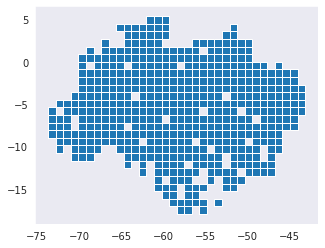

In [ ]:
a = a.set_geometry('geometry_x')
a.plot()

In [ ]:
a = a.dropna()

In [ ]:
y1 = a['classification_2020']

In [ ]:
enum_errors_1 = [2259,2260,2261]

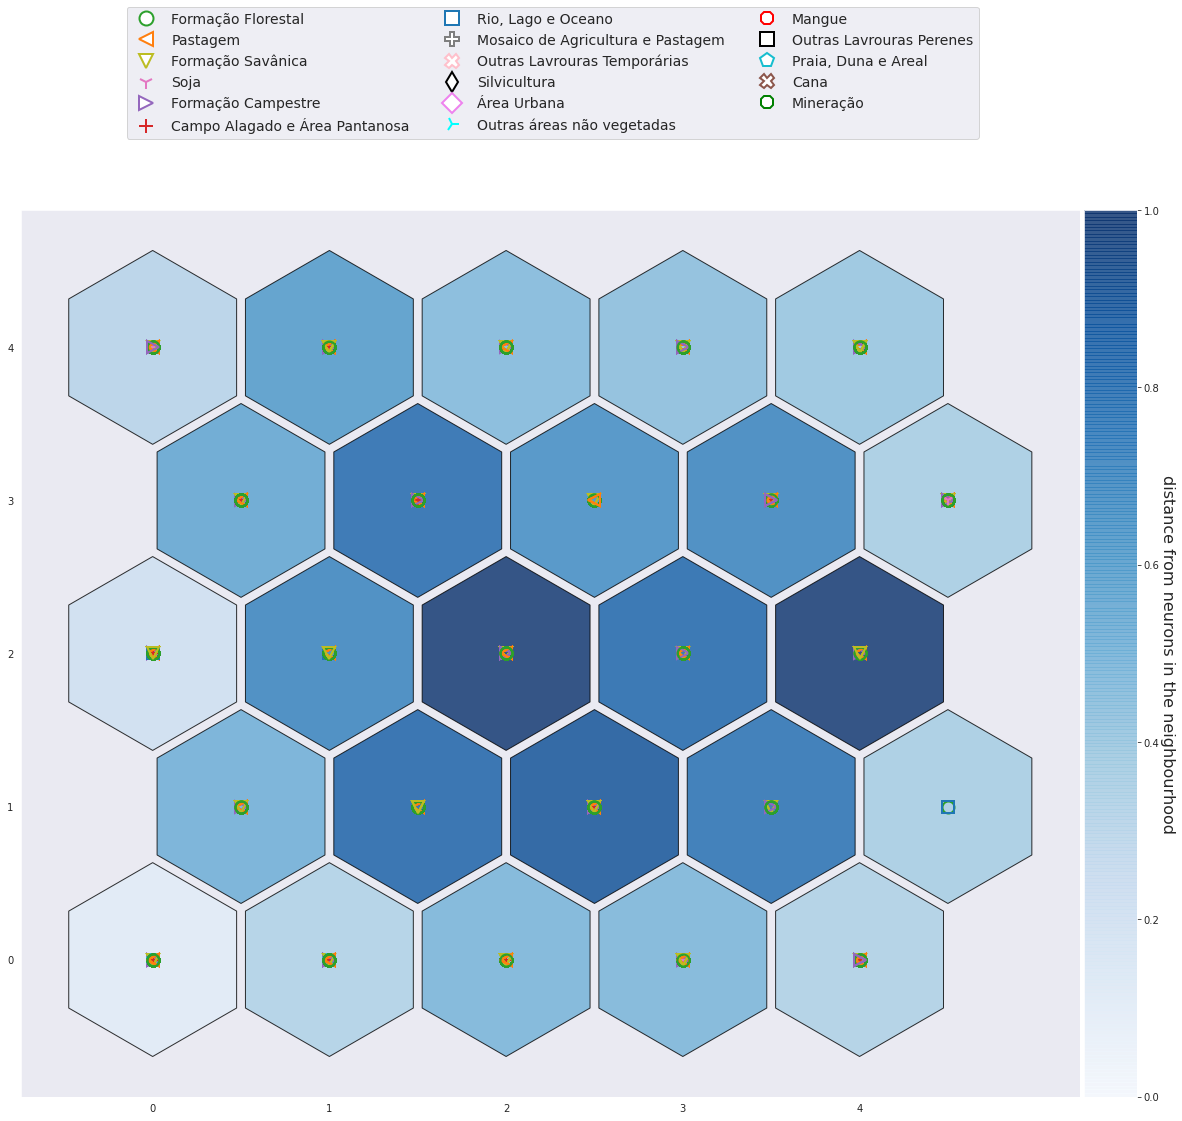

In [ ]:
create_hexagonal_topology_with_markers(som_1, X, y1, xx_1, yy_1, umatrix_1, weights_1, legend_elements, enum_errors_1,'teste')

In [ ]:
create_hexagonal_topology__makers_html(som_1, X, y1, xx_1, yy_1, umatrix_1, weights_1, legend_elements, enum_errors_1)

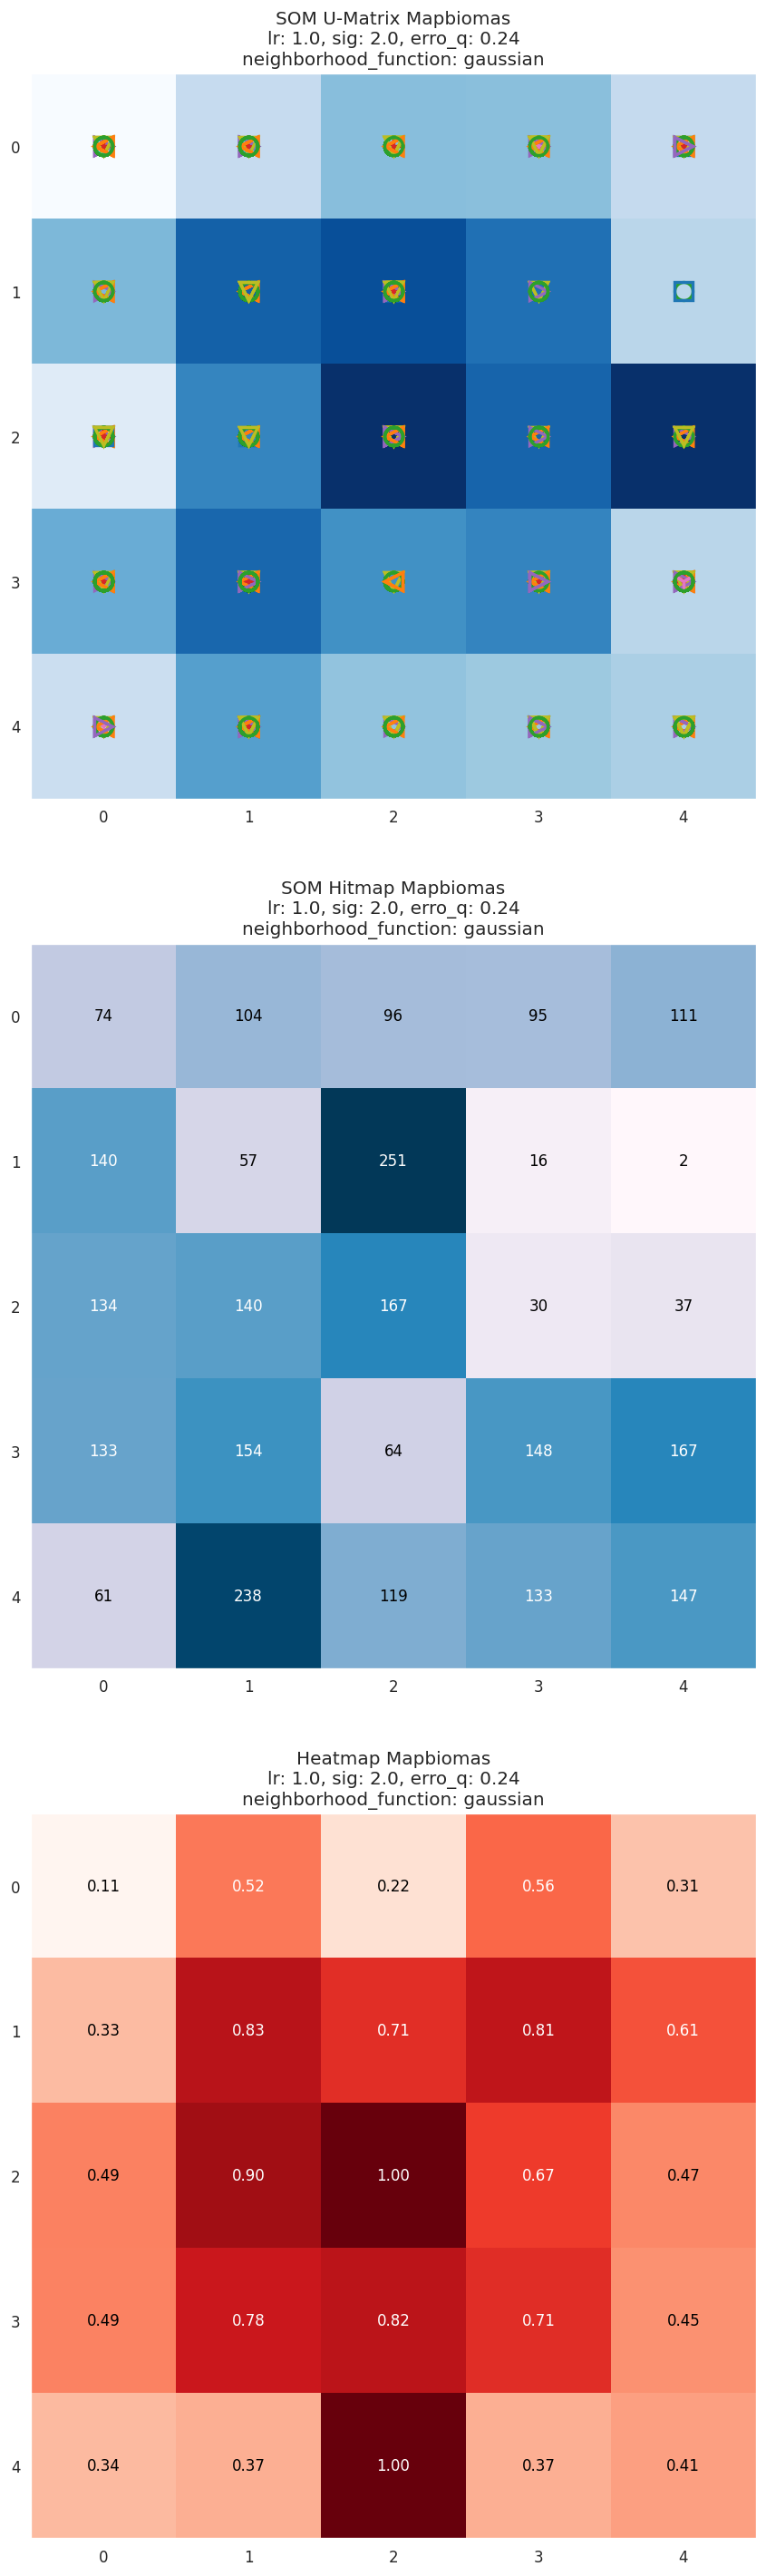

In [ ]:
create_umatrix_hitmap_heatmap(som_1, X, enum_errors_1, y1)

### Cálculo das médias por cluster

In [ ]:
co2_heatmap =  [1,2,3,5,6,7,8,11,12,13,14,15,16,17,18,24]
len(co2_heatmap)

16

In [ ]:
cluster_mean = gpd.GeoDataFrame(columns=['cluster_index','xco2','sif'])

In [ ]:
group = df_result.groupby('cluster_index')

In [ ]:
group.get_group(3).xco2.mean()

0.42729339821249673

In [ ]:
list_clu = []
list_co2 = []
list_sif = []
for cluster in list_clusters:
    list_clu.append(cluster)
    list_co2.append(group.get_group(cluster).xco2.mean())
    list_sif.append(group.get_group(cluster).sif.mean())
cluster_mean['cluster_index'] = list_clu
cluster_mean['xco2'] = list_co2
cluster_mean['sif'] = list_sif

In [ ]:
# cluster_mean = cluster_mean.set_index('cluster_index')

In [ ]:
cluster_mean = cluster_mean.sort_values(['cluster_index'])

In [ ]:
t = cluster_mean.iloc[:, 0:2].values


In [ ]:
#+ scale_color_manual(values=classPalette)
#     + scale_fill_manual(values=classPalette)

###Gráficos

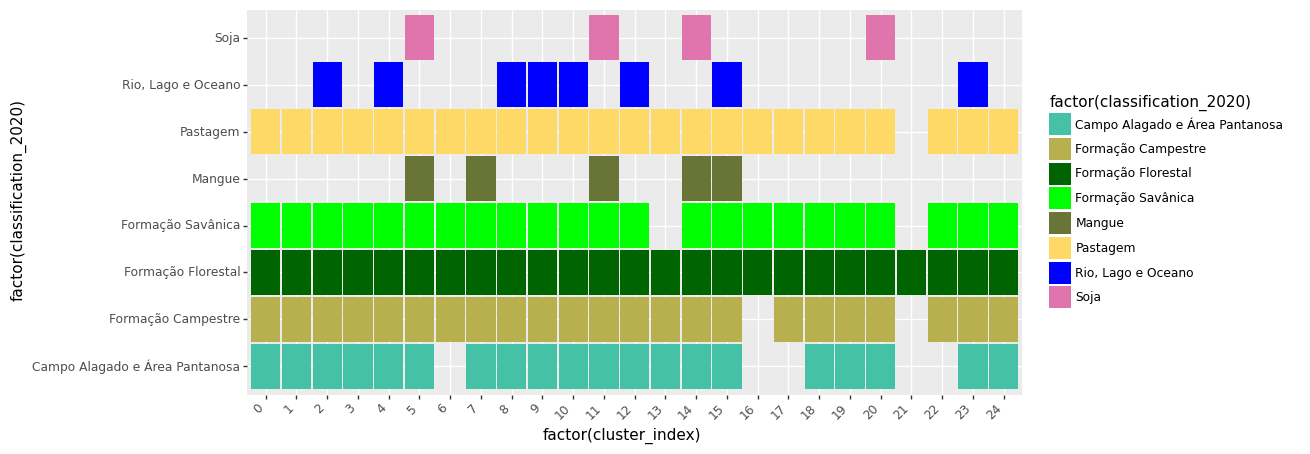

<ggplot: (8775042994583)>

In [ ]:
(
    ggplot(a)
    + geom_tile(aes('factor(cluster_index)', 'factor(classification_2020)', fill='factor(classification_2020)',width=.95, height=.95),show_legend=True)
     + scale_fill_manual(values=classPaletteSt)
     + theme(figure_size=(10,5), axis_text_x=element_text(rotation=45, hjust=1))
)

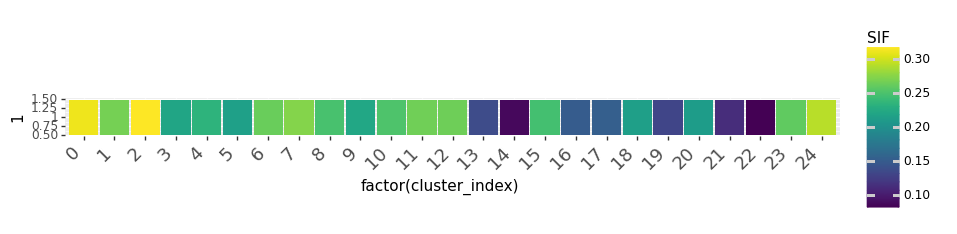

<ggplot: (8775042886873)>

In [ ]:
(
    ggplot(cluster_mean)
    + geom_tile(aes('factor(cluster_index)', 1, fill='sif',width=.95, height=.95),show_legend=True)
    + theme(figure_size=(10,0.5), axis_text_x=element_text(rotation=45, hjust=1,size=13))
    + labs(fill='SIF')
)

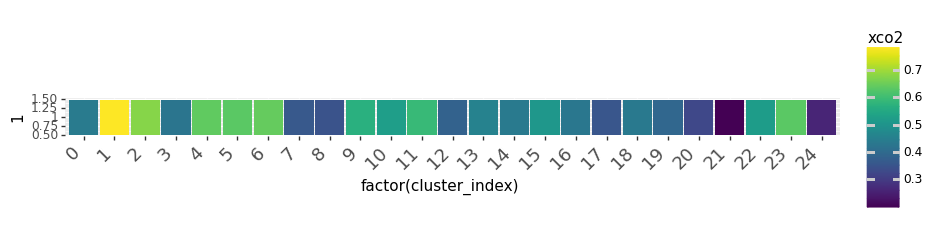

<ggplot: (8775046069441)>

In [ ]:
(
    ggplot(cluster_mean)
    + geom_tile(aes('factor(cluster_index)', 1, fill='xco2',width=.95, height=.95),show_legend=True)
    + theme(figure_size=(10,0.5), axis_text_x=element_text(rotation=45, hjust=1,size=13))
)

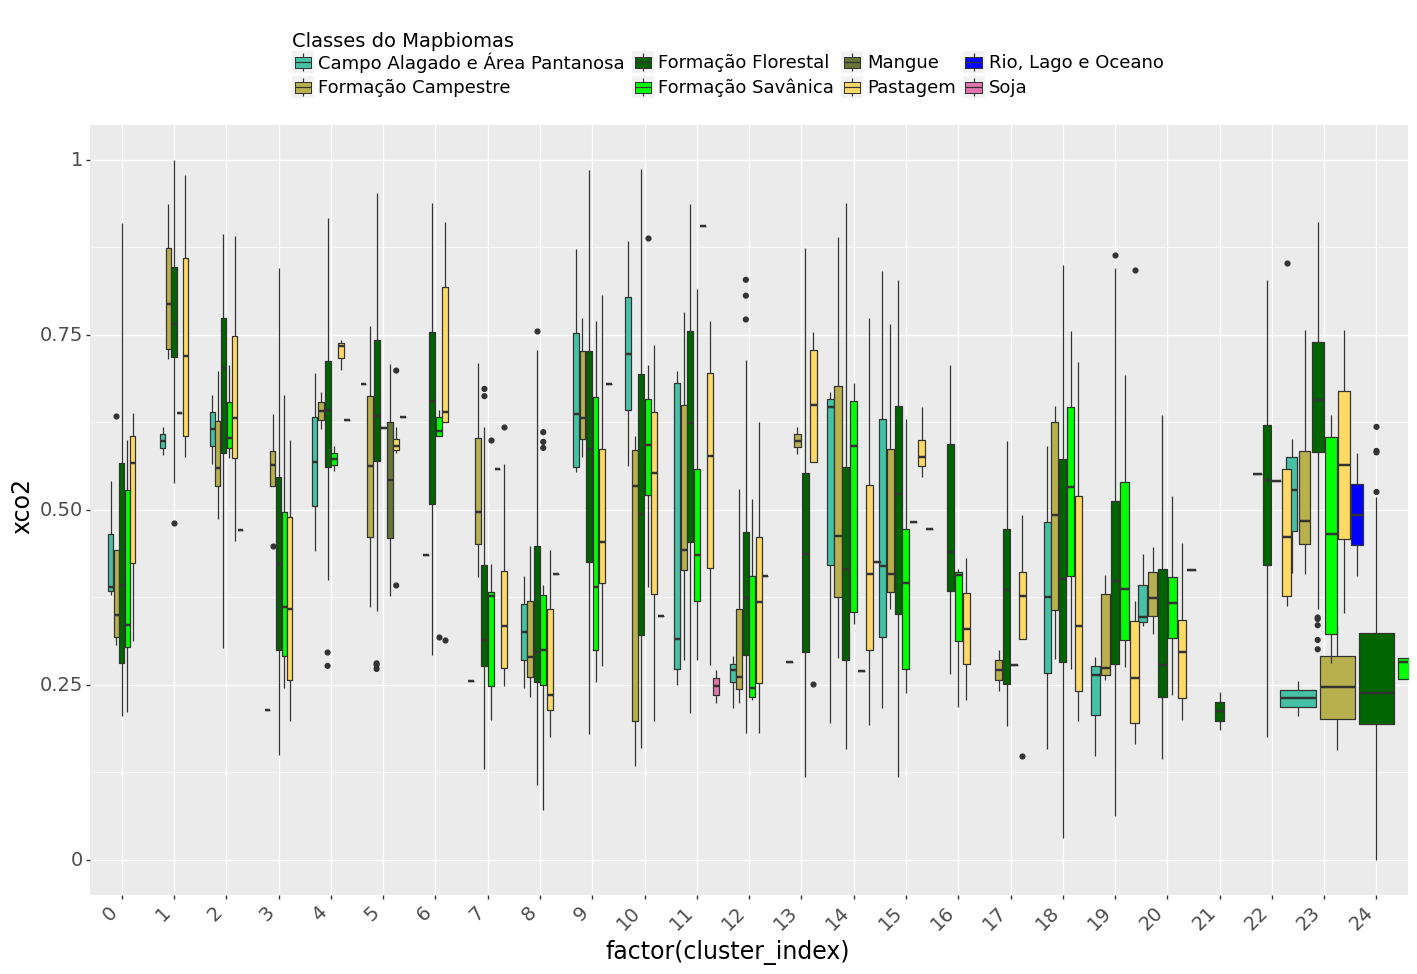

<ggplot: (8775046688308)>

In [ ]:
(
    ggplot(a, aes('factor(cluster_index)', 'xco2', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position='top',legend_title=element_text(size=14),legend_text=element_text(size=13),legend_direction='horizontal')
    + labs(fill='Classes do Mapbiomas')
)

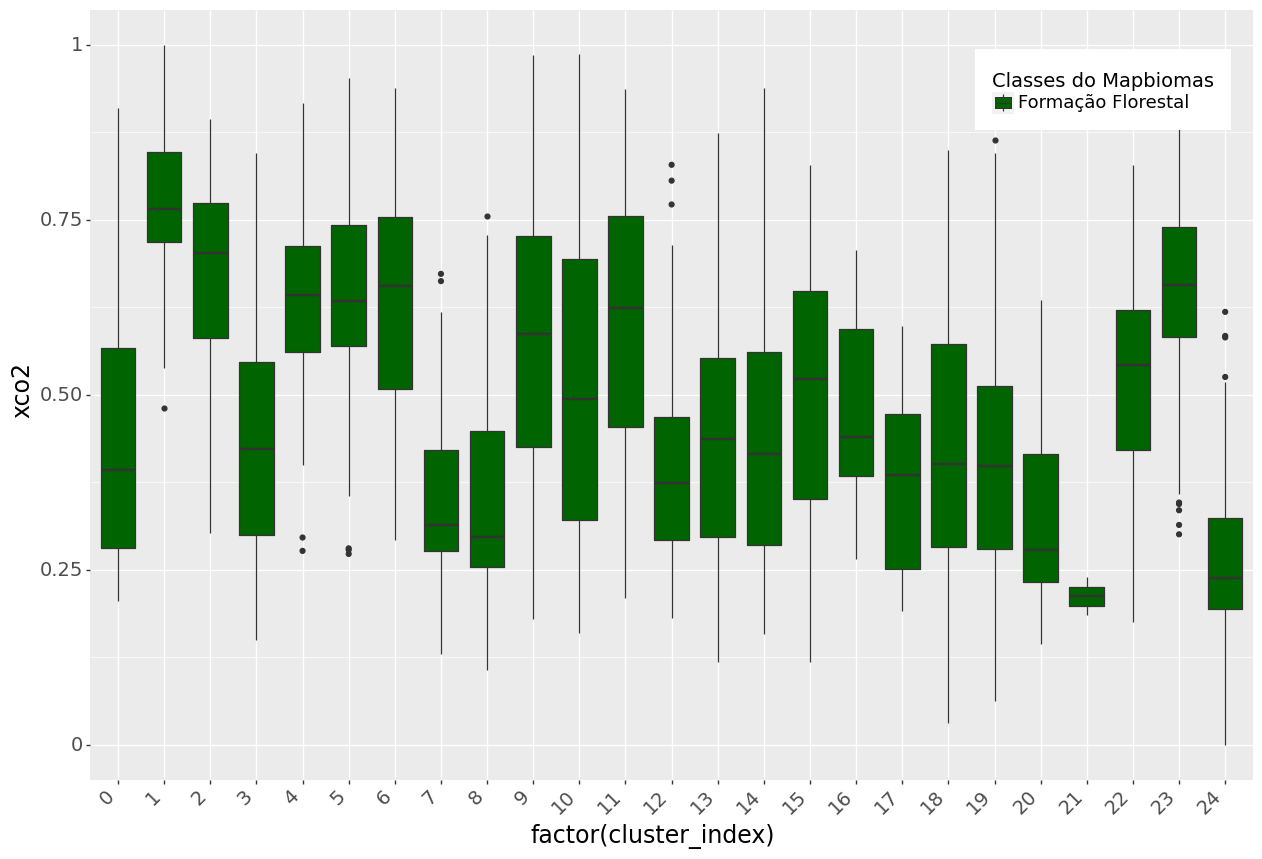

<ggplot: (8775045450521)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Formação Florestal'], aes('factor(cluster_index)', 'xco2', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(15,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

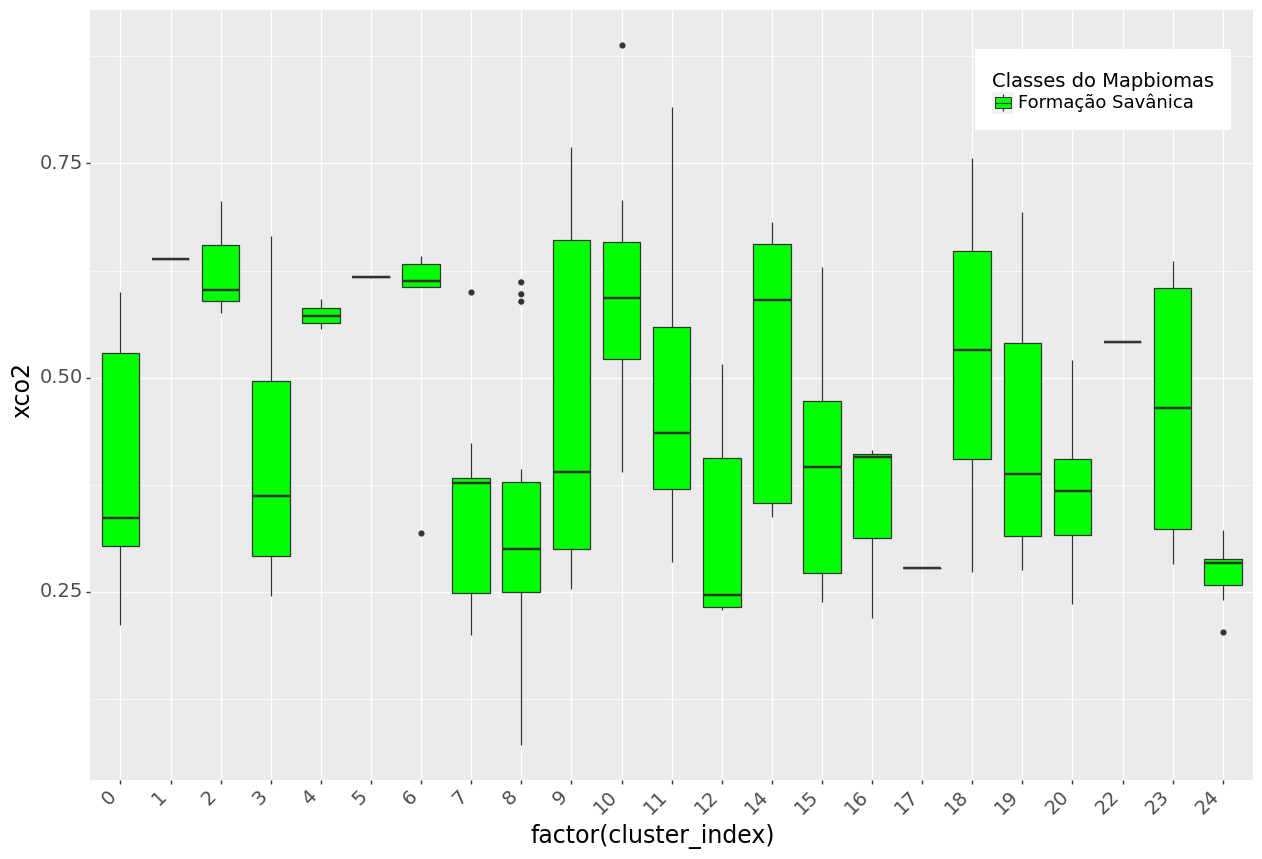

<ggplot: (8775042184096)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Formação Savânica'], aes('factor(cluster_index)', 'xco2', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(15,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

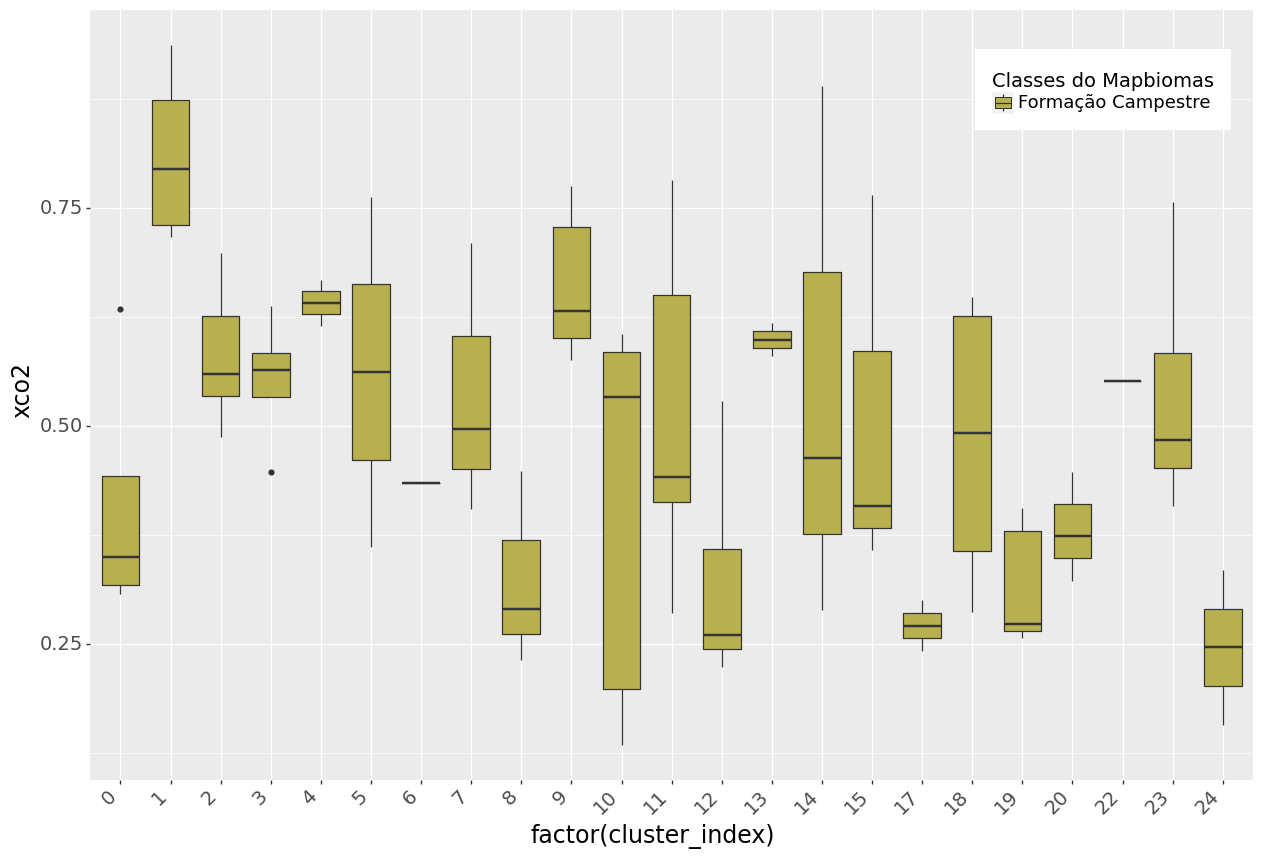

<ggplot: (8775041824187)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Formação Campestre'], aes('factor(cluster_index)', 'xco2', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(15,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

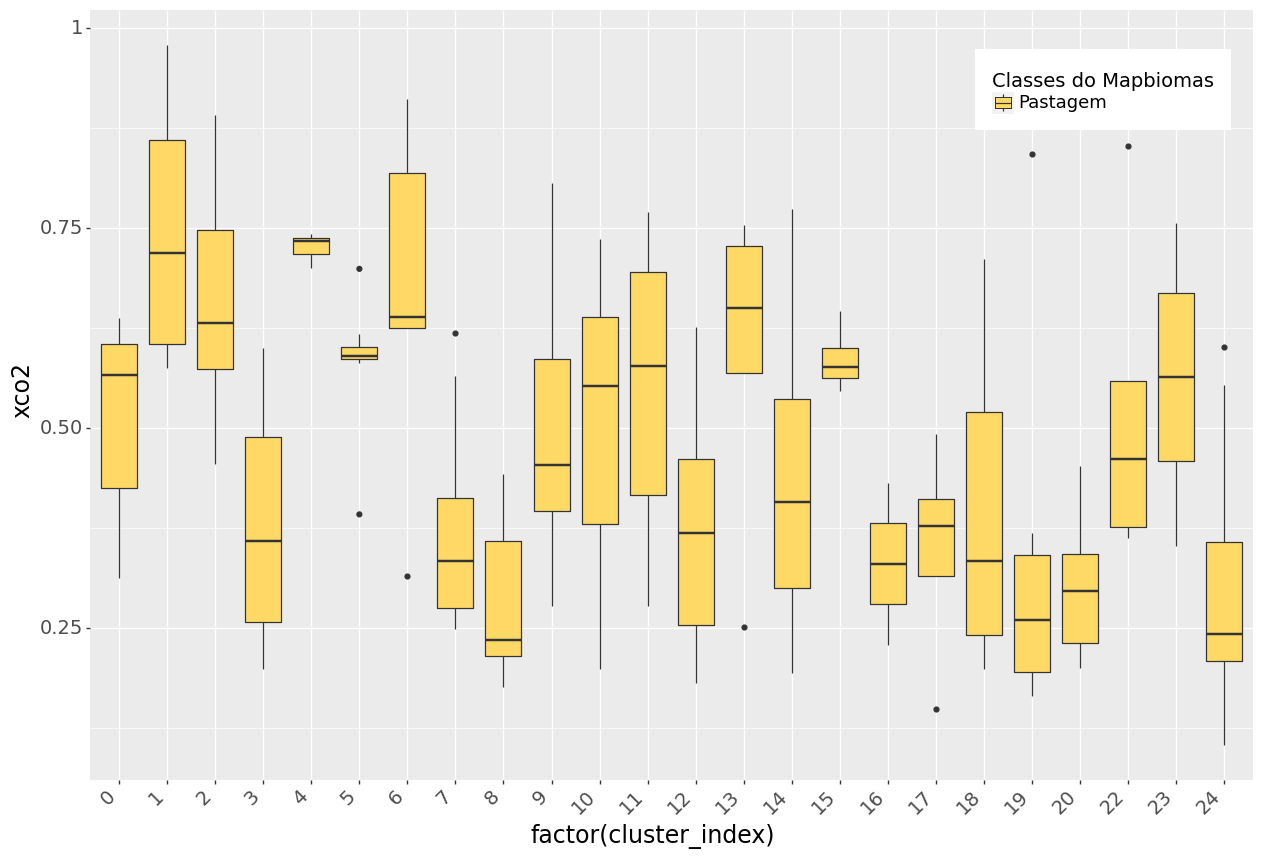

<ggplot: (8775044090022)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Pastagem'], aes('factor(cluster_index)', 'xco2', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(15,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

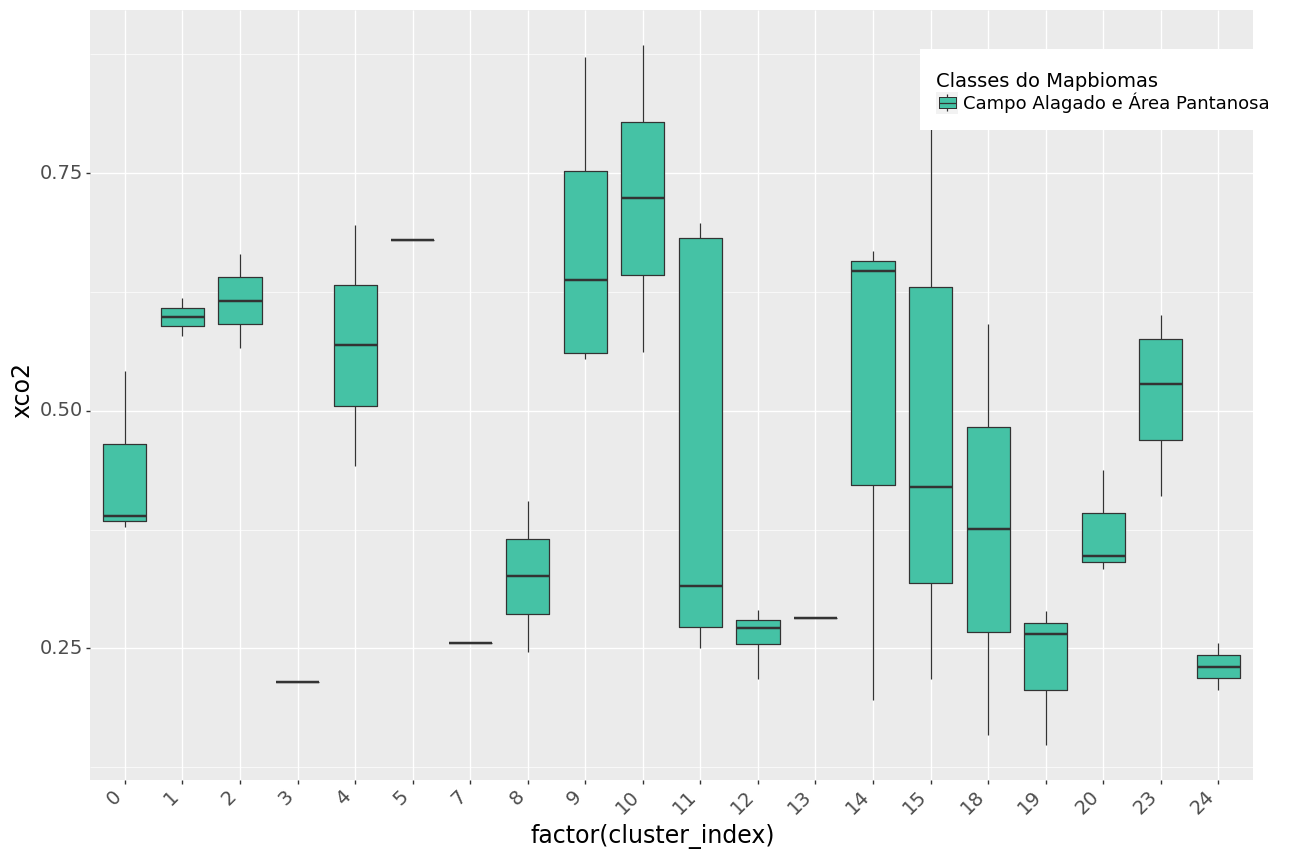

<ggplot: (8775043038492)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Campo Alagado e Área Pantanosa'], aes('factor(cluster_index)', 'xco2', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(15,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

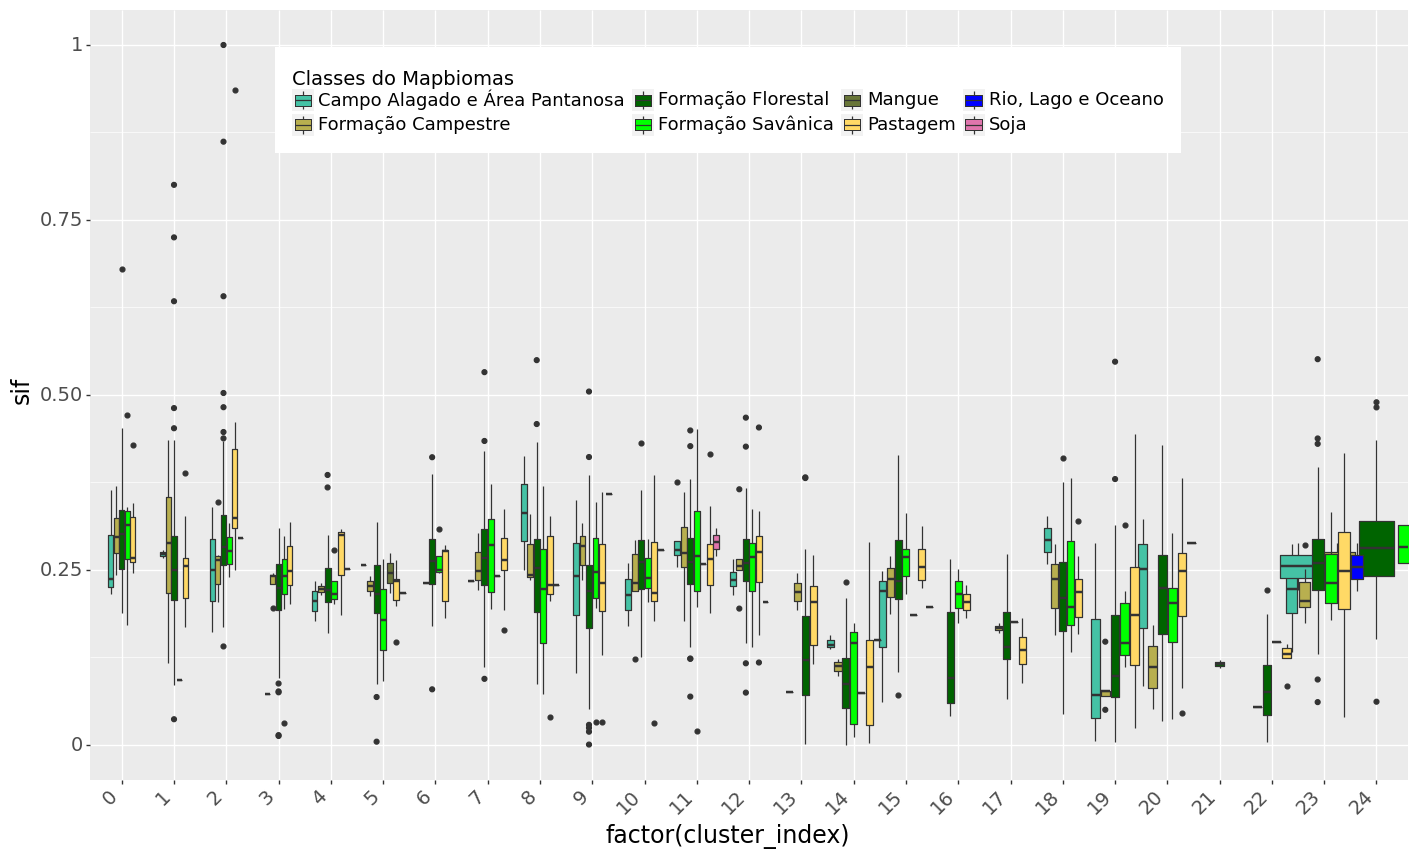

<ggplot: (8775041097957)>

In [ ]:
(
    ggplot(a, aes('factor(cluster_index)', 'sif', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.5,.79),legend_title=element_text(size=14),legend_text=element_text(size=13),legend_direction='horizontal')
    + labs(fill='Classes do Mapbiomas')
)

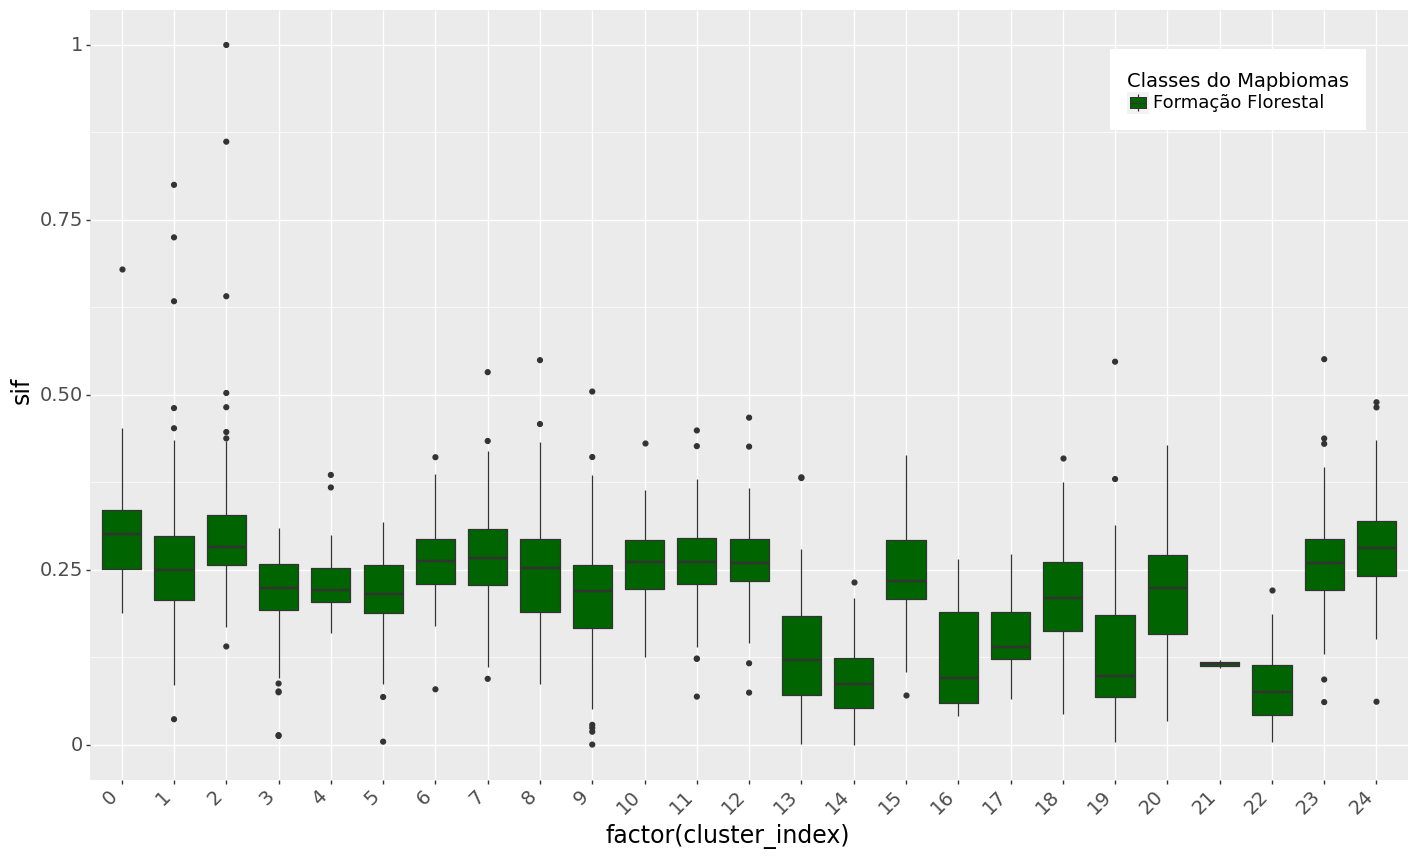

<ggplot: (8775045755278)>

In [ ]:

(
    ggplot(a[a.classification_2020 == 'Formação Florestal'], aes('factor(cluster_index)', 'sif', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

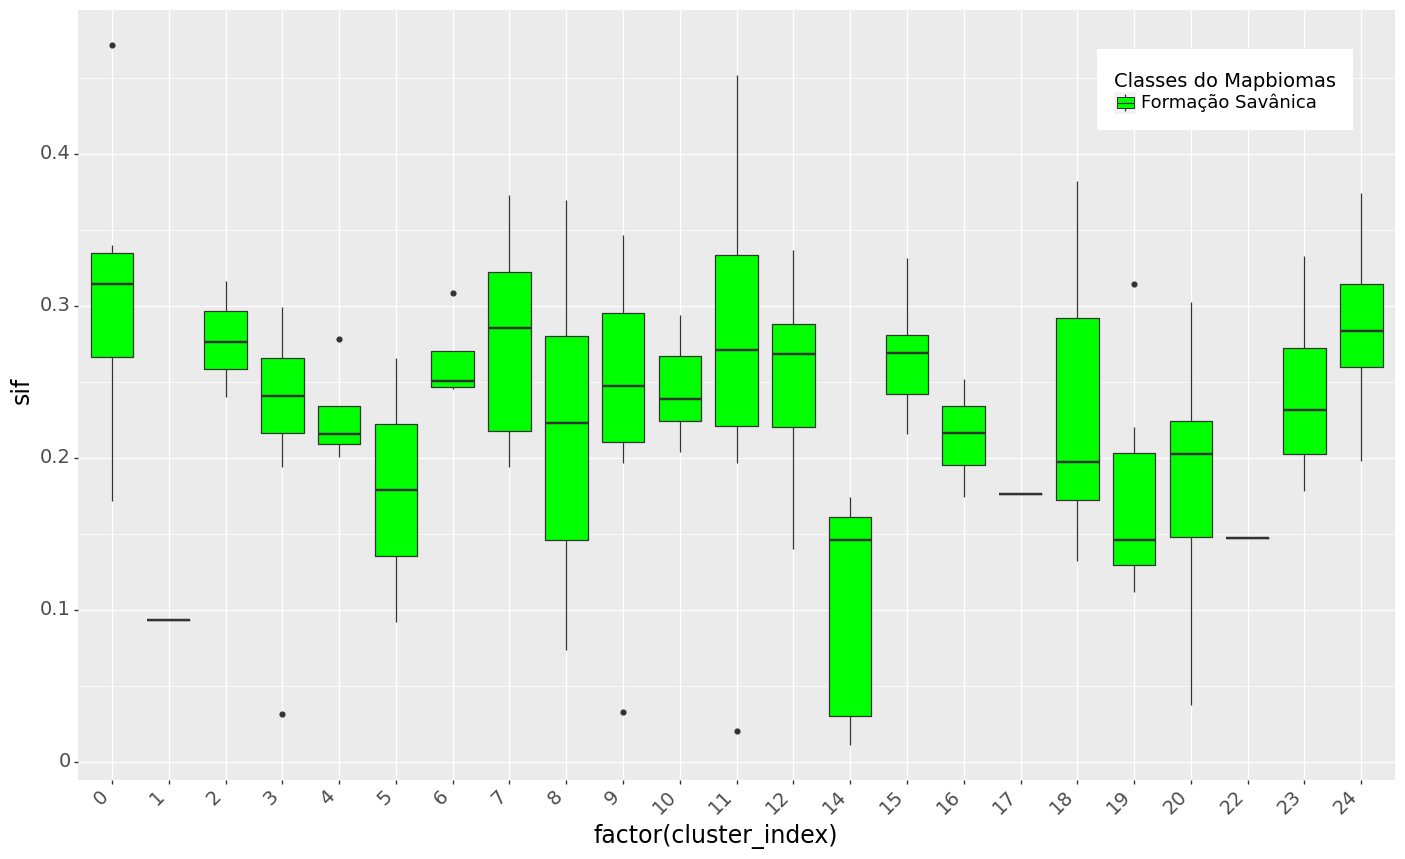

<ggplot: (8775046495112)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Formação Savânica'], aes('factor(cluster_index)', 'sif', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

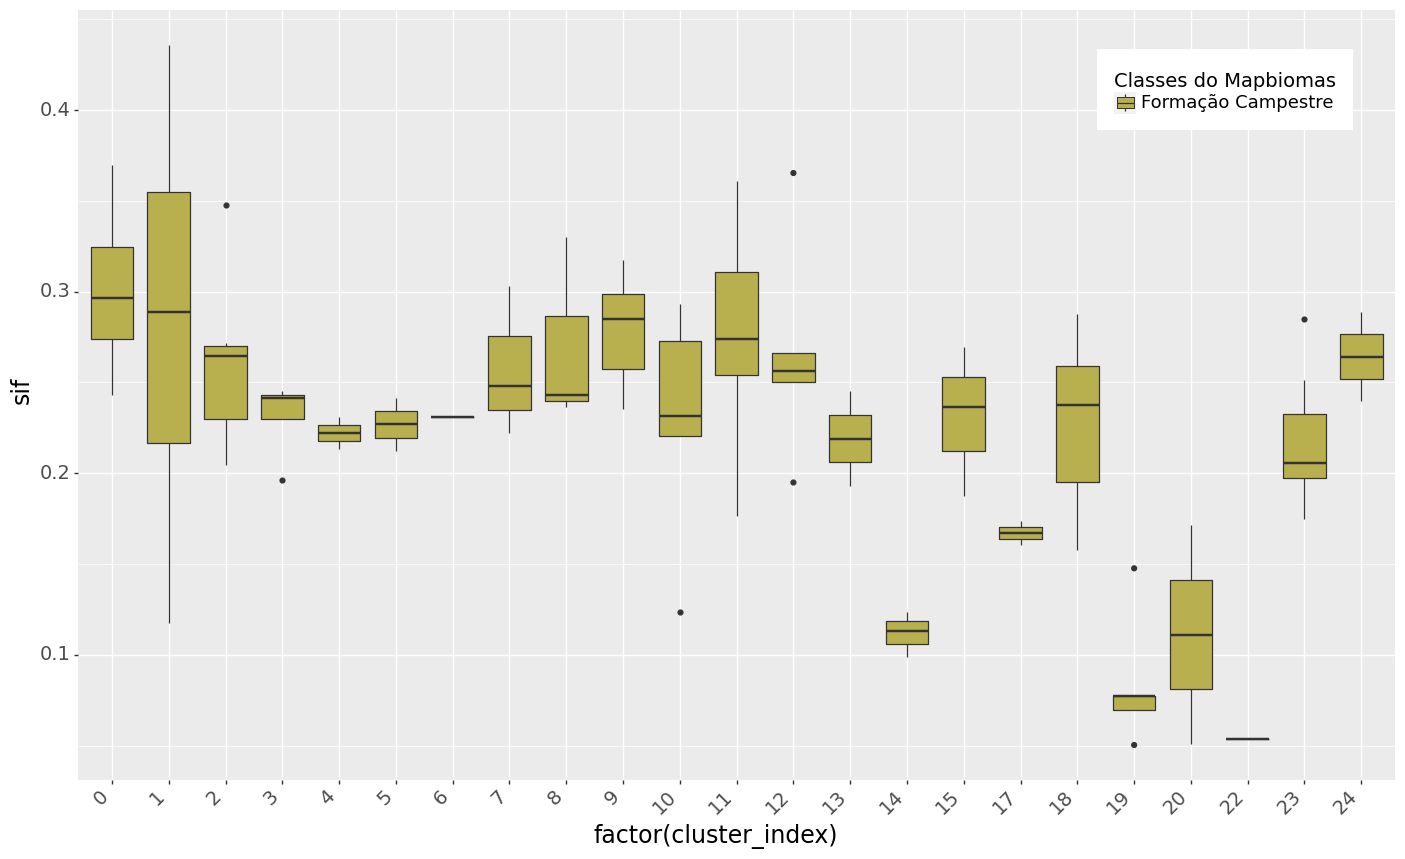

<ggplot: (8775045891949)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Formação Campestre'], aes('factor(cluster_index)', 'sif', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

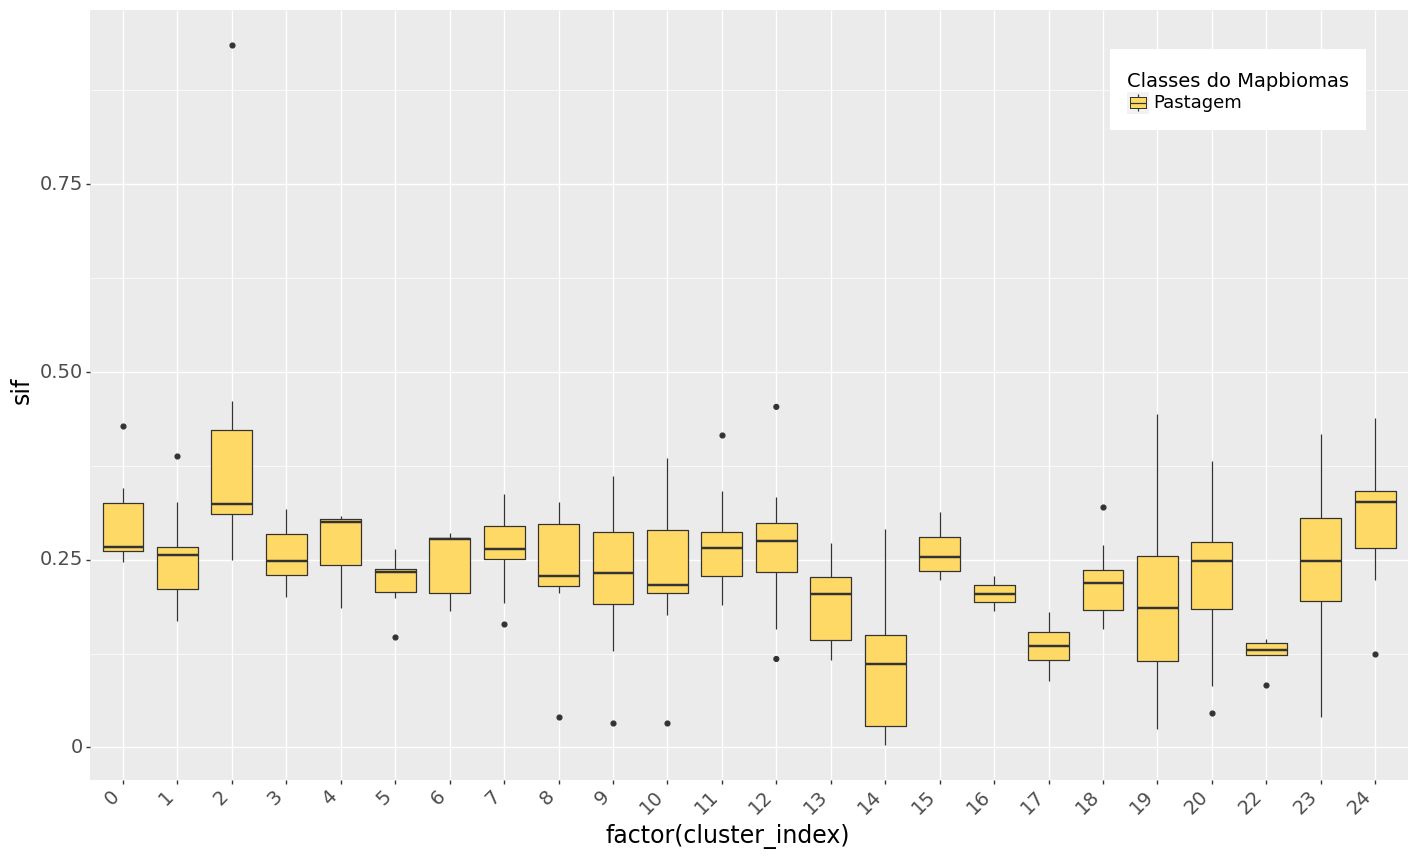

<ggplot: (8775041287581)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Pastagem'], aes('factor(cluster_index)', 'sif', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

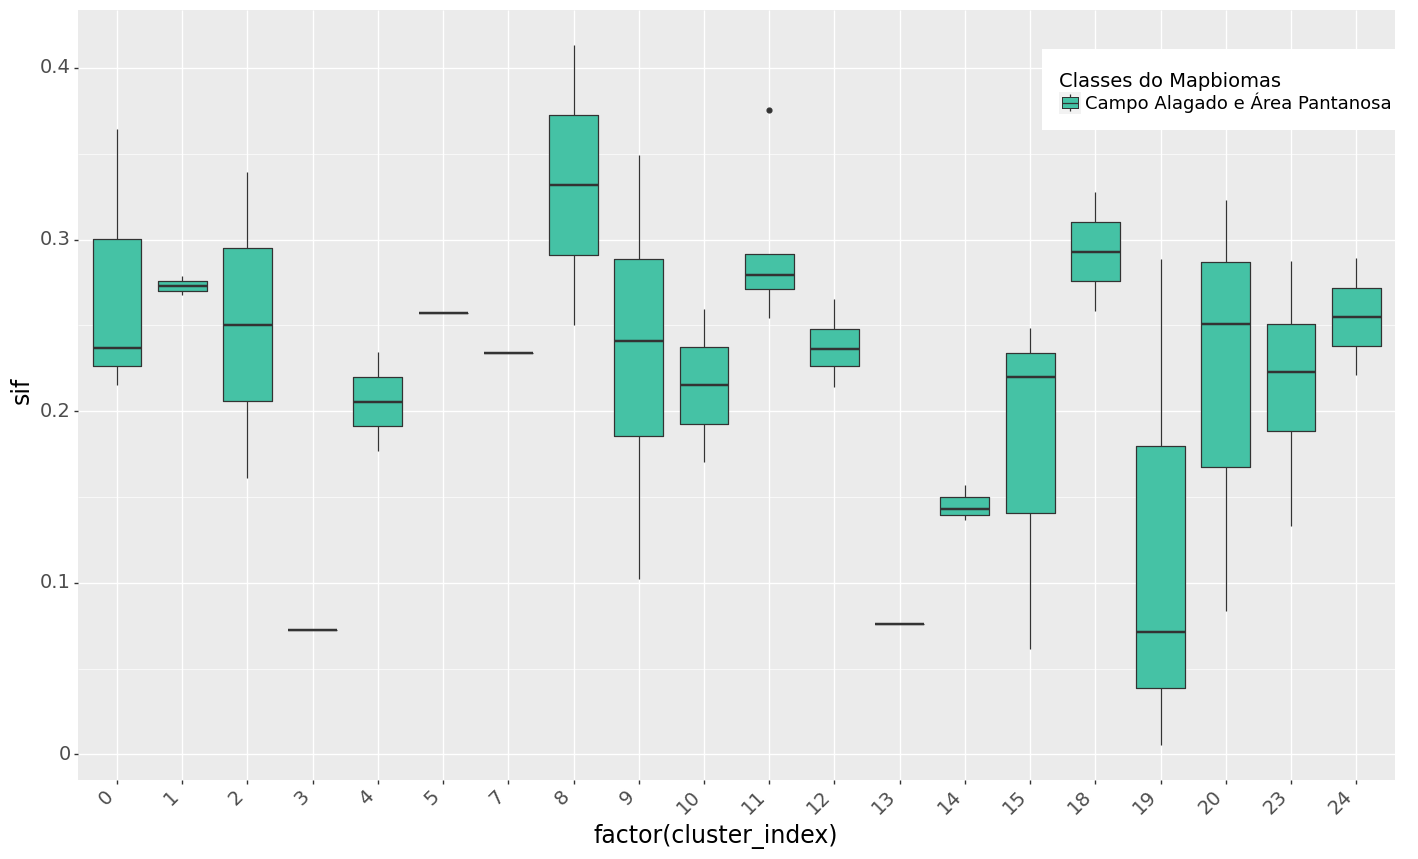

<ggplot: (8775044169352)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Campo Alagado e Área Pantanosa'], aes('factor(cluster_index)', 'sif', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

In [ ]:
a.columns

Index(['xco2', 'xco2_uncer', 'sif', 'sif_unc', 'latitude', 'longitude',
       'cluster_index', 'index', 'geometry_x', 'system:index',
       'classification_1985', 'classification_1986', 'classification_1987',
       'classification_1988', 'classification_1989', 'classification_1990',
       'classification_1991', 'classification_1992', 'classification_1993',
       'classification_1994', 'classification_1995', 'classification_1996',
       'classification_1997', 'classification_1998', 'classification_1999',
       'classification_2000', 'classification_2001', 'classification_2002',
       'classification_2003', 'classification_2004', 'classification_2005',
       'classification_2006', 'classification_2007', 'classification_2008',
       'classification_2009', 'classification_2010', 'classification_2011',
       'classification_2012', 'classification_2013', 'classification_2014',
       'classification_2015', 'classification_2016', 'classification_2017',
       'classification_2018',

In [ ]:
list_class = ['classification_2015', 'classification_2016', 'classification_2017',
       'classification_2018', 'classification_2019', 'classification_2020']

In [ ]:
df_count = pd.DataFrame(columns=['cluster_index','year','count'])

In [ ]:
for year_class in list_class:
  print('year_class',year_class)
  for cluster in list_clusters:
    print('cluster',cluster)
    print(a[a.cluster_index == cluster][year_class].value_counts())


year_class classification_2015
cluster 13
Formação Florestal                56
Pastagem                           5
Formação Campestre                 2
Campo Alagado e Área Pantanosa     1
Name: classification_2015, dtype: int64
cluster 19
Formação Florestal                113
Pastagem                            6
Formação Campestre                  5
Formação Savânica                   5
Campo Alagado e Área Pantanosa      4
Name: classification_2015, dtype: int64
cluster 18
Formação Florestal                121
Pastagem                           12
Formação Savânica                   7
Formação Campestre                  5
Campo Alagado e Área Pantanosa      2
Rio, Lago e Oceano                  1
Name: classification_2015, dtype: int64
cluster 12
Formação Florestal                133
Pastagem                           19
Formação Savânica                   6
Formação Campestre                  5
Rio, Lago e Oceano                  2
Campo Alagado e Área Pantanosa      2
Name: class

In [ ]:
a['classification_2020'].value_counts()



Formação Florestal                2261
Pastagem                           246
Formação Savânica                  152
Formação Campestre                  86
Campo Alagado e Área Pantanosa      50
Rio, Lago e Oceano                   9
Mangue                               6
Soja                                 5
Name: classification_2020, dtype: int64

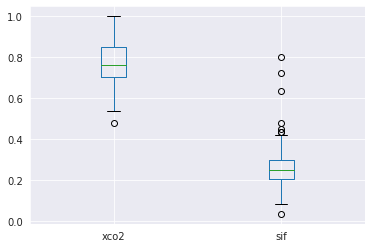

In [ ]:
df_result[df_result.cluster_index == 1].boxplot(column=['xco2','sif'])

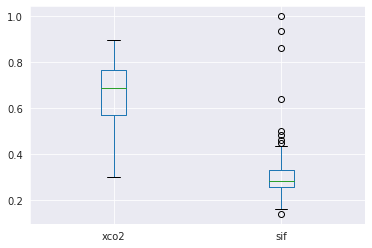

In [ ]:
df_result[df_result.cluster_index == 2].boxplot(column=['xco2','sif'])

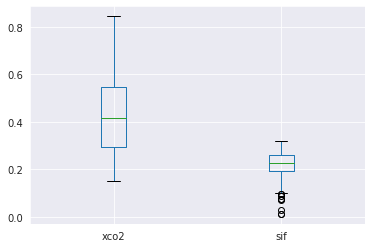

In [ ]:
df_result[df_result.cluster_index == 3].boxplot(column=['xco2','sif'])

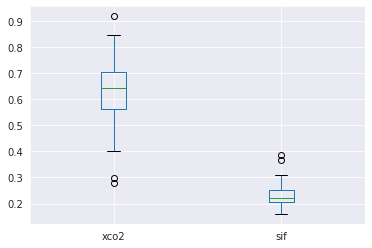

In [ ]:
df_result[df_result.cluster_index == 4].boxplot(column=['xco2','sif'])

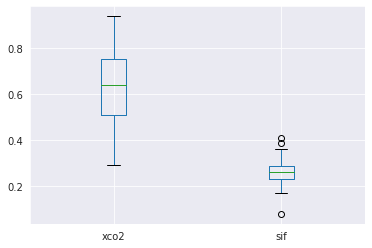

In [ ]:
df_result[df_result.cluster_index == 6].boxplot(column=['xco2','sif'])

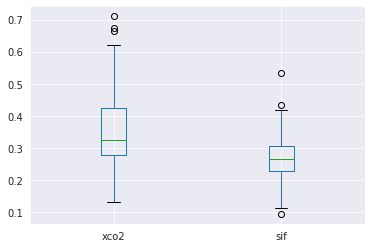

In [ ]:
df_result[df_result.cluster_index == 7].boxplot(column=['xco2','sif'])

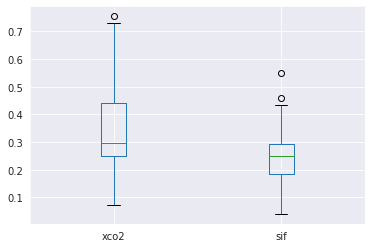

In [ ]:
df_result[df_result.cluster_index == 8].boxplot(column=['xco2','sif'])

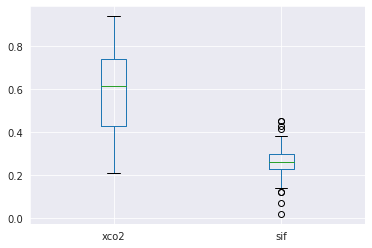

In [ ]:
df_result[df_result.cluster_index == 11].boxplot(column=['xco2','sif'])

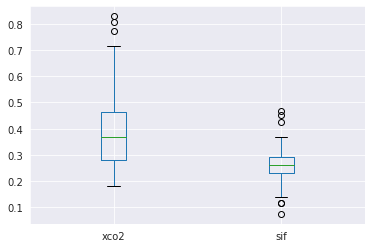

In [ ]:
df_result[df_result.cluster_index == 12].boxplot(column=['xco2','sif'])

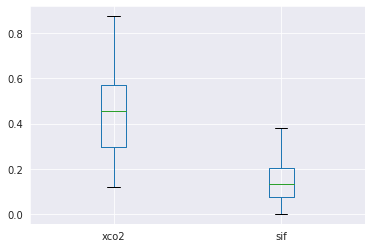

In [ ]:
df_result[df_result.cluster_index == 13].boxplot(column=['xco2','sif'])

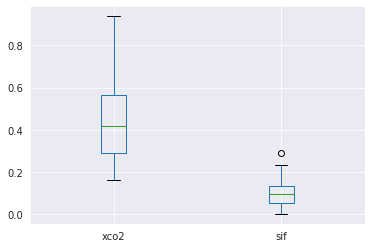

In [ ]:
df_result[df_result.cluster_index == 14].boxplot(column=['xco2','sif'])

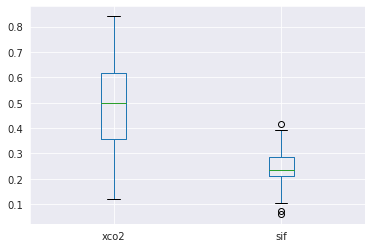

In [ ]:
df_result[df_result.cluster_index == 15].boxplot(column=['xco2','sif'])

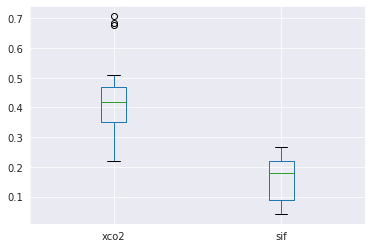

In [ ]:
df_result[df_result.cluster_index == 16].boxplot(column=['xco2','sif'])

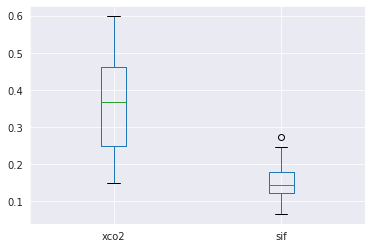

In [ ]:
df_result[df_result.cluster_index == 17].boxplot(column=['xco2','sif'])

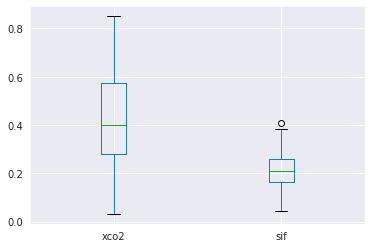

In [ ]:
df_result[df_result.cluster_index == 18].boxplot(column=['xco2','sif'])

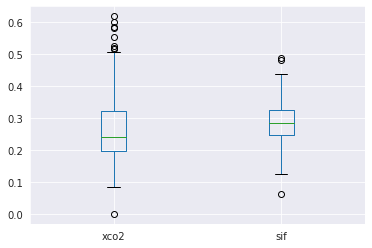

In [ ]:
df_result[df_result.cluster_index == 24].boxplot(column=['xco2','sif'])

# Importação e Preparação dos Dados EVI

Dados do satélite OCO-2 para o período entre os dias 01-08-2015 e 31-09-2021

In [ ]:
print(geodf_evi.isna().sum())
print(geodf_evi.shape)

Unnamed: 0      0
system_ind      0
DayOfYear       0
DetailedQA      0
EVI             0
NDVI            0
RelativeAz      0
SolarZenit      0
SummaryQA       0
ViewZenith      0
sur_refl_b      0
sur_refl_1      0
sur_refl_2      0
sur_refl_3      0
index_righ      0
xco2            0
xco2_uncer      0
sif             0
sif_unc         0
out_flag        0
sound_id        0
latitude        0
longitude       0
land_w_ind      0
land_frac       0
geometry        0
sound_mode    127
dtype: int64
(127, 27)


In [ ]:
geodf_evi

Unnamed: 0            system_ind   DayOfYear   DetailedQA          EVI  \
0             0  00000000000000000046  230.266129  2867.483871  2776.354839   
1             1  0000000000000000005c  229.879032  2116.000000  2887.637097   
2             2  00000000000000000075  229.000000  2116.000000  3183.393574   
3             3  00000000000000000076  229.520000  2116.000000  3550.940000   
4             4  00000000000000000093  229.000000  2116.000000  3537.986301   
..          ...                   ...         ...          ...          ...   
122         122  0000000000000000007d  244.442922  2187.045662  5586.191781   
123         123  0000000000000000009d  245.200000  2186.232000  5153.576000   
124         124  000000000000000000bd  242.932271  2194.832669  5165.007968   
125         125  00000000000000000143  285.537549  2116.000000  6094.276680   
126         126  00000000000000000093  284.890411  2185.000000  3819.410959   

            NDVI   RelativeAz   SolarZenit  SummaryQA   ViewZenith  ...  \
0    4816.858871  -600.330645  3545.879032        0.0  1125.209677  ...   
1    5244.431452 -3048.366935  3452.794355        0.0  1045.125000  ...   
2    6042.915663 -7785.851406  3420.815261        0.0   792.397590  ...   
3    6234.660000 -2985.480000  3399.280000        0.0  1102.500000  ...   
4    6167.534247 -9162.136986  3381.671233        0.0   646.506849  ...   
..           ...          ...          ...        ...          ...  ...   
122  8351.392694  1821.429224  3188.091324        1.0  2805.351598  ...   
123  8408.208000 -3903.068000  2816.724000        1.0  2857.312000  ...   
124  8250.498008 -7269.872510  2728.984064        1.0  1890.553785  ...   
125  8341.086957 -2586.830040  2067.707510        0.0  1481.284585  ...   
126  6171.534247 -8015.630137  2299.260274        1.0  1695.561644  ...   

              sif       sif_unc  out_flag      sound_id   latitude  longitude  \
0    1.981853e+18  3.826939e+17       1.0  2.015081e+15 -12.615581 -49.999947   
1    9.604844e+17  3.635570e+17       1.0  2.015081e+15 -11.983137 -50.116742   
2    1.392777e+18  3.834100e+17       1.0  2.015081e+15 -10.903842 -50.350944   
3    1.454813e+18  3.779546e+17       1.0  2.015081e+15 -11.254309 -50.256809   
4    1.546596e+18  3.739018e+17       1.0  2.015081e+15 -10.277470 -50.467891   
..            ...           ...       ...           ...        ...        ...   
122  3.081210e+18  4.783782e+17       1.0  2.020083e+15 -10.248213 -70.507510   
123  2.233579e+18  4.770861e+17       1.0  2.020083e+15  -9.200338 -70.720909   
124  2.112534e+18  4.929578e+17       1.0  2.020083e+15  -8.608516 -70.869801   
125  4.835881e+18  5.671273e+17       1.0  2.020093e+15  -5.346272 -71.589680   
126 -5.649042e+17  4.832047e+17       1.0  2.021093e+15 -10.654116 -50.881110   

     land_w_ind  land_frac                                           geometry  \
0           0.0      100.0  POLYGON ((-50.30566 -13.47473, -50.30566 -12.5...   
1           0.0      100.0  POLYGON ((-50.24951 -11.67810, -50.19337 -11.6...   
2           0.0      100.0  POLYGON ((-51.20397 -10.77978, -51.14783 -10.7...   
3           0.0      100.0  POLYGON ((-50.24951 -10.77978, -50.19337 -10.7...   
4           0.0      100.0  POLYGON ((-51.14783 -9.88147, -51.09168 -9.881...   
..          ...        ...                                                ...   
122         0.0      100.0  POLYGON ((-70.23703 -10.77978, -70.29317 -10.7...   
123         0.0      100.0  POLYGON ((-70.74233 -8.98315, -70.63004 -8.983...   
124         0.0      100.0  POLYGON ((-70.74233 -8.08484, -70.63004 -8.084...   
125         0.0      100.0  POLYGON ((-71.86522 -5.38989, -71.86522 -4.491...   
126         0.0      100.0  POLYGON ((-51.20397 -10.77978, -51.20397 -9.88...   

     sound_mode  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
..          ...  
122         NaN  
123         NaN  
124         NaN  
125         NaN  
126        

In [ ]:
geodf_evi = geodf_evi.drop(columns='sound_mode')
geodf_evi['EVI'] = geodf_evi['EVI']*0.0001
geodf_evi['NDVI'] = geodf_evi['NDVI']*0.0001

In [ ]:
geodf_evi.columns

Index(['Unnamed: 0', 'system_ind', 'DayOfYear', 'DetailedQA', 'EVI', 'NDVI',
       'RelativeAz', 'SolarZenit', 'SummaryQA', 'ViewZenith', 'sur_refl_b',
       'sur_refl_1', 'sur_refl_2', 'sur_refl_3', 'index_righ', 'xco2',
       'xco2_uncer', 'sif', 'sif_unc', 'out_flag', 'sound_id', 'latitude',
       'longitude', 'land_w_ind', 'land_frac', 'geometry'],
      dtype='object')

In [ ]:
print(geodf_evi.xco2.describe())

count    127.000000
mean     402.513434
std        5.605198
min      392.456400
25%      396.739349
50%      403.936760
75%      406.910006
max      418.768100
Name: xco2, dtype: float64


In [ ]:
print(geodf_evi.sif.describe())

count    1.270000e+02
mean     2.361519e+18
std      1.178933e+18
min     -2.525493e+18
25%      1.631124e+18
50%      2.460904e+18
75%      3.210249e+18
max      4.835881e+18
Name: sif, dtype: float64


In [ ]:
print(geodf_evi.EVI.describe())

count    127.000000
mean       0.464966
std        0.090165
min        0.247054
25%        0.408035
50%        0.488247
75%        0.535240
max        0.609428
Name: EVI, dtype: float64


In [ ]:
geodf_evi.NDVI.describe()

count    127.000000
mean       0.739689
std        0.119225
min        0.434724
25%        0.657038
50%        0.788634
75%        0.832480
max        0.876068
Name: NDVI, dtype: float64

In [ ]:
geodf_evi['datetime'] = pd.to_datetime(geodf_evi['sound_id'], format='%Y%m%d%H%M%S%f')
geodf_evi['day_date'] = [d.date() for d in geodf_evi['datetime']]
geodf_evi['day_date'] = [d.isoformat() for d in geodf_evi['day_date']]
geodf_evi['day_time'] = [d.time()for d in geodf_evi['datetime']]
geodf_evi['day_time'] = [d.isoformat() for d in geodf_evi['day_time']]

In [ ]:
geodf_evi.columns

Index(['Unnamed: 0', 'system_ind', 'DayOfYear', 'DetailedQA', 'EVI', 'NDVI',
       'RelativeAz', 'SolarZenit', 'SummaryQA', 'ViewZenith', 'sur_refl_b',
       'sur_refl_1', 'sur_refl_2', 'sur_refl_3', 'index_righ', 'xco2',
       'xco2_uncer', 'sif', 'sif_unc', 'out_flag', 'sound_id', 'latitude',
       'longitude', 'land_w_ind', 'land_frac', 'geometry', 'datetime',
       'day_date', 'day_time'],
      dtype='object')

Limpando o Dataframe

In [ ]:
geodf_evi = geodf_evi.drop(columns=['Unnamed: 0','DayOfYear', 'DetailedQA','RelativeAz', 'SolarZenit', 'SummaryQA', 'ViewZenith','sur_refl_b',
       'sur_refl_1', 'sur_refl_2', 'sur_refl_3','land_w_ind', 'land_frac'])
geodf_evi = geodf_evi.dropna()

In [ ]:
#Tem células que se repetem (verificar a data de cada uma delas, é possivel identificar mudança de uso do solo?)
len(geodf_evi.system_ind.unique())

110

In [ ]:
geodf_evi.head(2)

system_ind       EVI      NDVI  index_righ        xco2  \
0  00000000000000000046  0.277635  0.481686   17.000000  394.644000   
1  0000000000000000005c  0.288764  0.524443   12.777778  396.288666   

   xco2_uncer           sif       sif_unc  out_flag      sound_id   latitude  \
0    0.466848  1.981853e+18  3.826939e+17       1.0  2.015081e+15 -12.615581   
1    0.480796  9.604844e+17  3.635570e+17       1.0  2.015081e+15 -11.983137   

   longitude                                           geometry  \
0 -49.999947  POLYGON ((-50.30566 -13.47473, -50.30566 -12.5...   
1 -50.116742  POLYGON ((-50.24951 -11.67810, -50.19337 -11.6...   

                 datetime    day_date         day_time  
0 2015-08-13 16:56:39.060  2015-08-13  16:56:39.060000  
1 2015-08-13 16:56:50.420  2015-08-13  16:56:50.420000

In [ ]:
# (
#     ggplot(df_co2) 
#     + aes(x='classification_2019', fill='factor(classification_2019)', color='factor(classification_2019)') 
#     + geom_bar()
#     + scale_color_manual(values=classPalette)
#     + scale_fill_manual(values=classPalette)
#     + theme(axis_text_x=element_text(rotation=90, hjust=1))
#     + theme(figure_size=(8, 5), panel_background=element_rect(fill='white'))
#     + labs(title='Distribuição dos dados por Classe', x='Classe', y='Contagem')

# )

É possível identificar uma correlação positiva de aproximadamente 0.3 entre os componentes da pressão atmosférica pressure_level e pressure_weight com a latitude  e uma correlação negativa dos mesmos componentes com a longitude, aproximadamente -0.44 e -0.69. Houve uma leve correlação positiva, em torno de 0.1 entre o xco2 e a pressure_weight e uma correlação negativa com a longitude.

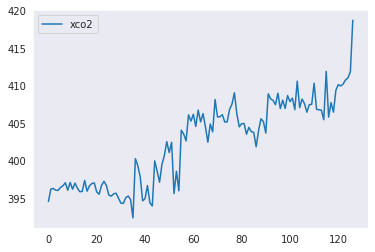

In [ ]:
geodf_evi.xco2.plot(legend=True)

In [ ]:
geodf_evi_clean = geodf_evi.drop(columns=['day_date', 'day_time', 'datetime', 'out_flag', 'sound_id','geometry','index_righ','system_ind'])

In [ ]:
geodf_evi_clean.corr()

EVI      NDVI      xco2  xco2_uncer       sif   sif_unc  \
EVI         1.000000  0.930121  0.471521    0.258033  0.452044  0.430955   
NDVI        0.930121  1.000000  0.474137    0.280787  0.471895  0.373718   
xco2        0.471521  0.474137  1.000000    0.370338  0.058410  0.149656   
xco2_uncer  0.258033  0.280787  0.370338    1.000000 -0.018106  0.209188   
sif         0.452044  0.471895  0.058410   -0.018106  1.000000  0.591002   
sif_unc     0.430955  0.373718  0.149656    0.209188  0.591002  1.000000   
latitude    0.486666  0.531990 -0.048594   -0.012476  0.388899  0.362335   
longitude  -0.501574 -0.558447 -0.604928   -0.206872 -0.245677 -0.225118   

            latitude  longitude  
EVI         0.486666  -0.501574  
NDVI        0.531990  -0.558447  
xco2       -0.048594  -0.604928  
xco2_uncer -0.012476  -0.206872  
sif         0.388899  -0.245677  
sif_unc     0.362335  -0.225118  
latitude    1.000000  -0.102298  
longitude  -0.102298   1.000000

In [ ]:
geodf_evi_clean.columns

Index(['EVI', 'NDVI', 'xco2', 'xco2_uncer', 'sif', 'sif_unc', 'latitude',
       'longitude'],
      dtype='object')

In [ ]:
geodf_evi_norm = normalize_dataframe(geodf_evi_clean)

In [ ]:
geodf_evi_norm.head()

EVI      NDVI      xco2  xco2_uncer       sif   sif_unc  latitude  \
0  0.084392  0.106406  0.083142    0.080917  0.612297  0.630126  0.158335   
1  0.115101  0.203286  0.145649    0.117887  0.473550  0.598616  0.190560   
2  0.196718  0.384207  0.149284    0.161836  0.532274  0.631305  0.245553   
3  0.298145  0.427652  0.140413    0.135057  0.540702  0.622322  0.227696   
4  0.294571  0.412443  0.139151    0.159385  0.553170  0.615649  0.277469   

   longitude  
0   0.792015  
1   0.787959  
2   0.779827  
3   0.783096  
4   0.775766

In [ ]:
# print(geodf_evi_norm[geodf_evi_norm.columns[-1]].head())
# y_treino=y_treino.astype('int')
print(geodf_evi_norm[geodf_evi_norm.columns[0:8]].head())

        EVI      NDVI      xco2  xco2_uncer       sif   sif_unc  latitude  \
0  0.084392  0.106406  0.083142    0.080917  0.612297  0.630126  0.158335   
1  0.115101  0.203286  0.145649    0.117887  0.473550  0.598616  0.190560   
2  0.196718  0.384207  0.149284    0.161836  0.532274  0.631305  0.245553   
3  0.298145  0.427652  0.140413    0.135057  0.540702  0.622322  0.227696   
4  0.294571  0.412443  0.139151    0.159385  0.553170  0.615649  0.277469   

   longitude  
0   0.792015  
1   0.787959  
2   0.779827  
3   0.783096  
4   0.775766  


# Rede SOM com os dados com EVI e NDVI





In [ ]:
# dfs_co2['classification_2019'] = dfs_co2['classification_2019'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas' })

In [ ]:
geodf_evi_norm.iloc[:, 0:].head()

EVI      NDVI      xco2  xco2_uncer       sif   sif_unc  latitude  \
0  0.084392  0.106406  0.083142    0.080917  0.612297  0.630126  0.158335   
1  0.115101  0.203286  0.145649    0.117887  0.473550  0.598616  0.190560   
2  0.196718  0.384207  0.149284    0.161836  0.532274  0.631305  0.245553   
3  0.298145  0.427652  0.140413    0.135057  0.540702  0.622322  0.227696   
4  0.294571  0.412443  0.139151    0.159385  0.553170  0.615649  0.277469   

   longitude  
0   0.792015  
1   0.787959  
2   0.779827  
3   0.783096  
4   0.775766

In [ ]:
# Escolha dos preditores
X = geodf_evi_norm.iloc[:, 0:].values
# y1 = dfs_co2[dfs_co2.columns[-1]]

In [ ]:
# ver o balanceamento das classes
# print(pd.Series(y1).value_counts())


### Geolocalização dos pontos

In [ ]:
# gdf_co2 = gpd.GeoDataFrame(df_co2, geometry = gpd.points_from_xy(df_co2.longitude, df_co2.latitude))

In [ ]:
# importar shapefiles de estados brasileiros
geo_ufs = geobr.read_state(code_state = 'all', year = 2019)
geo_ufs.head()

code_state abbrev_state name_state  code_region name_region  \
0        11.0           RO   Rondônia          1.0       Norte   
1        12.0           AC       Acre          1.0       Norte   
2        13.0           AM   Amazônas          1.0       Norte   
3        14.0           RR    Roraima          1.0       Norte   
4        15.0           PA       Pará          1.0       Norte   

                                            geometry  
0  MULTIPOLYGON (((-65.38150 -10.42907, -65.37916...  
1  MULTIPOLYGON (((-71.07772 -9.82774, -71.08554 ...  
2  MULTIPOLYGON (((-69.83766 -3.68659, -69.71230 ...  
3  MULTIPOLYGON (((-63.96008 2.47313, -63.96041 2...  
4  MULTIPOLYGON (((-51.43248 -0.47334, -51.42843 ...

## Modelo


Parâmetros da Rede:

    neighborhood_function: gaussian
    learning_rate: 1.0
    sigma: 2.0
    activation_distance: euclidean
    topology: hexagonal
    X_length: 6
    grid: 10 x 10
    num_interations = 10000

Uso do PCA para inicializar os pesos da rede. 

In [ ]:

functions = ['gaussian', 'mexican_hat', 'bublle', 'triangle']
func, lr, sig = functions[0], 1.0, 2.0
som_1_shape = (5, 5)
som_1 = MiniSom(x=5, y=5, input_len=8, sigma=sig, learning_rate=lr, activation_distance='euclidean',topology='hexagonal', 
             neighborhood_function=func)
som_1.pca_weights_init(X)
som_1.train(X, num_iteration=10000, verbose=True)


 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.2926774659559425


In [ ]:
X.shape

(127, 8)

In [ ]:
X

array([[0.08439204, 0.10640612, 0.08314172, ..., 0.63012586, 0.15833464,
        0.79201502],
       [0.1151013 , 0.2032858 , 0.14564872, ..., 0.598616  , 0.19055968,
        0.78795939],
       [0.19671775, 0.38420689, 0.14928439, ..., 0.63130498, 0.24555319,
        0.77982689],
       ...,
       [0.74356062, 0.88440237, 0.70802036, ..., 0.81168125, 0.36250736,
        0.06732445],
       [1.        , 0.90492808, 0.73955237, ..., 0.93380522, 0.52872908,
        0.04232716],
       [0.372232  , 0.41334937, 1.        , ..., 0.79562224, 0.25827754,
        0.76141727]])

In [ ]:
# each neuron represents a cluster
winner_coordinates_1 = np.array([som_1.winner(x) for x in X]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index_1 = np.ravel_multi_index(winner_coordinates_1, som_1_shape)

In [ ]:
geodf_evi.columns

Index(['system_ind', 'EVI', 'NDVI', 'index_righ', 'xco2', 'xco2_uncer', 'sif',
       'sif_unc', 'out_flag', 'sound_id', 'latitude', 'longitude', 'geometry',
       'datetime', 'day_date', 'day_time'],
      dtype='object')

In [ ]:
list_col = ['EVI', 'NDVI', 'xco2', 'xco2_uncer', 'sif', 'sif_unc', 'latitude',
       'longitude']

df_result = get_results_from_model_and_save(X, list_col, cluster_index_1, geodf_evi)

In [ ]:
df_result.head()

EVI      NDVI      xco2  xco2_uncer       sif   sif_unc  latitude  \
0  0.084392  0.106406  0.083142    0.080917  0.612297  0.630126  0.158335   
1  0.115101  0.203286  0.145649    0.117887  0.473550  0.598616  0.190560   
2  0.196718  0.384207  0.149284    0.161836  0.532274  0.631305  0.245553   
3  0.298145  0.427652  0.140413    0.135057  0.540702  0.622322  0.227696   
4  0.294571  0.412443  0.139151    0.159385  0.553170  0.615649  0.277469   

   longitude  cluster_index            system_ind  \
0   0.792015             10  00000000000000000046   
1   0.787959             10  0000000000000000005c   
2   0.779827             10  00000000000000000075   
3   0.783096             10  00000000000000000076   
4   0.775766             10  00000000000000000093   

                                            geometry  
0  POLYGON ((-50.30566 -13.47473, -50.30566 -12.5...  
1  POLYGON ((-50.24951 -11.67810, -50.19337 -11.6...  
2  POLYGON ((-51.20397 -10.77978, -51.14783 -10.7...  
3  POLYGON ((-50.24951 -10.77978, -50.19337 -10.7...  
4  POLYGON ((-51.14783 -9.88147, -51.09168 -9.881...

In [ ]:
list_clusters = df_result.cluster_index.unique()

In [ ]:
for cluster in list_clusters:
  print(cluster, df_result[df_result.cluster_index == cluster].shape)

10 (16, 11)
15 (5, 11)
17 (4, 11)
16 (5, 11)
6 (1, 11)
21 (7, 11)
20 (3, 11)
22 (3, 11)
5 (3, 11)
12 (6, 11)
11 (5, 11)
9 (5, 11)
14 (4, 11)
0 (5, 11)
2 (5, 11)
3 (5, 11)
13 (6, 11)
23 (5, 11)
1 (2, 11)
8 (5, 11)
4 (7, 11)
24 (5, 11)
18 (3, 11)
7 (10, 11)
19 (2, 11)


In [ ]:
df_result[df_result.cluster_index == 4].describe()
# df_result[df_result.cluster_index == 19].xco2.plot()
# df_result[df_result.cluster_index == 15].xco2.plot()
# df_result[df_result.cluster_index == 24].xco2.plot()

EVI      NDVI      xco2  xco2_uncer       sif   sif_unc  latitude  \
count  7.000000  7.000000  7.000000    7.000000  7.000000  7.000000  7.000000   
mean   0.852507  0.907478  0.670330    0.421379  0.780934  0.836872  0.355154   
std    0.093426  0.025252  0.096647    0.061951  0.124040  0.052327  0.093522   
min    0.740406  0.868124  0.460627    0.308715  0.630049  0.785548  0.244824   
25%    0.783248  0.894665  0.672397    0.401066  0.704065  0.799678  0.303559   
50%    0.859790  0.907263  0.698038    0.428971  0.788788  0.830528  0.332352   
75%    0.900427  0.921969  0.723786    0.454124  0.819785  0.854432  0.386528   
max    1.000000  0.943692  0.741274    0.501588  1.000000  0.933805  0.528729   

       longitude  cluster_index  
count   7.000000            7.0  
mean    0.198178            4.0  
std     0.234705            0.0  
min     0.042327            4.0  
25%     0.069910            4.0  
50%     0.079905            4.0  
75%     0.232890            4.0  
max     0.659419            4.0

In [ ]:
df_result[df_result.cluster_index == 5].describe()

EVI      NDVI      xco2  xco2_uncer       sif   sif_unc  latitude  \
count  3.000000  3.000000  3.000000    3.000000  3.000000  3.000000  3.000000   
mean   0.095793  0.189893  0.266802    0.835343  0.467877  0.638165  0.310567   
std    0.017369  0.061827  0.031872    0.145654  0.047972  0.060936  0.154715   
min    0.078329  0.153422  0.236165    0.723329  0.426257  0.588179  0.196610   
25%    0.087158  0.154200  0.250313    0.753015  0.441644  0.604225  0.222501   
50%    0.095986  0.154978  0.264461    0.782701  0.457030  0.620271  0.248392   
75%    0.104526  0.208129  0.282121    0.891350  0.488687  0.663158  0.367545   
max    0.113065  0.261279  0.299780    1.000000  0.520344  0.706044  0.486697   

       longitude  cluster_index  
count   3.000000            3.0  
mean    0.847688            5.0  
std     0.131969            0.0  
min     0.767431            5.0  
25%     0.771533            5.0  
50%     0.775634            5.0  
75%     0.887817            5.0  
max     1.000000            5.0

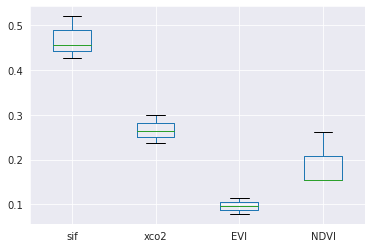

In [ ]:
df_result[df_result.cluster_index == 5].boxplot(column=['sif', 'xco2', 'EVI','NDVI'])

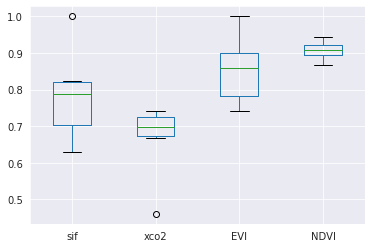

In [ ]:
df_result[df_result.cluster_index == 4].boxplot(column=['sif', 'xco2', 'EVI','NDVI'])

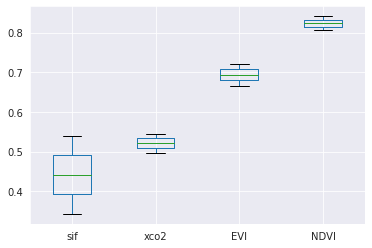

In [ ]:
df_result[df_result.cluster_index == 19].boxplot(column=['sif', 'xco2', 'EVI','NDVI'])

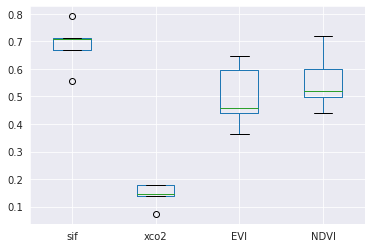

In [ ]:
df_result[df_result.cluster_index == 15].boxplot(column=['sif', 'xco2', 'EVI','NDVI'])

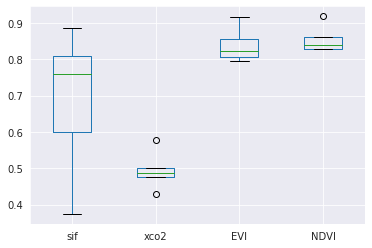

In [ ]:
df_result[df_result.cluster_index == 24].boxplot(column=['sif', 'xco2', 'EVI','NDVI'])

In [ ]:
from shapely import wkt
# df_result['geometry'] = df_result['geometry'].apply(wkt.loads)
geodf_result_evi = gpd.GeoDataFrame(df_result,crs='EPSG:4627')
# geodf_result_evi.set_geometry(col='geometry', inplace=True)

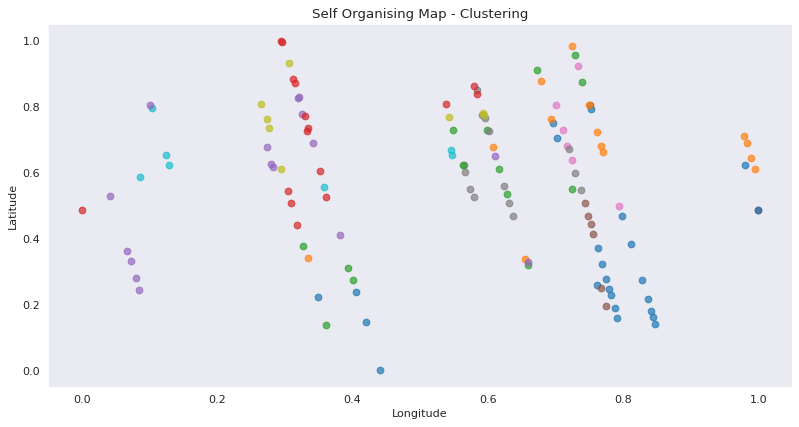

In [ ]:
a = plot_clusters_for_som(X, cluster_index_1, 6, 7)

In [ ]:
xx_1, yy_1 = som_1.get_euclidean_coordinates()
umatrix_1 = som_1.distance_map()
weights_1 = som_1.get_weights()

In [ ]:
# y1 = y1.dropna()
# y1 = y1.map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })

In [ ]:
# y1.unique()

In [ ]:
enum_errors_1 = []

In [ ]:
mapbiomas = pd.read_csv('/content/drive/MyDrive/oco-2_mapbiomas inverno-2015a2021/oco2-mapbiomas-inverno-Grid_Amazonia_Legal_100km.csv')
mapbiomas.head()
mapbiomas['system_ind'] = mapbiomas['system:index']

In [ ]:
a = pd.merge(df_result,mapbiomas,'inner','system_ind' )

In [ ]:
a.columns

Index(['EVI', 'NDVI', 'xco2', 'xco2_uncer', 'sif', 'sif_unc', 'latitude',
       'longitude', 'cluster_index', 'system_ind', 'geometry', 'system:index',
       'classification_1985', 'classification_1986', 'classification_1987',
       'classification_1988', 'classification_1989', 'classification_1990',
       'classification_1991', 'classification_1992', 'classification_1993',
       'classification_1994', 'classification_1995', 'classification_1996',
       'classification_1997', 'classification_1998', 'classification_1999',
       'classification_2000', 'classification_2001', 'classification_2002',
       'classification_2003', 'classification_2004', 'classification_2005',
       'classification_2006', 'classification_2007', 'classification_2008',
       'classification_2009', 'classification_2010', 'classification_2011',
       'classification_2012', 'classification_2013', 'classification_2014',
       'classification_2015', 'classification_2016', 'classification_2017',
       'cla

In [ ]:
len(a['system:index'].unique())

110

In [ ]:
a['classification_2020'] = a['classification_2020'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })

In [ ]:

a['classification_2015'] = a['classification_2015'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })
a['classification_2016'] = a['classification_2016'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })
a['classification_2017'] = a['classification_2017'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })
a['classification_2018'] = a['classification_2018'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })
a['classification_2019'] = a['classification_2019'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })

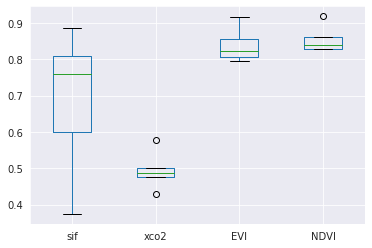

In [ ]:
a[a.cluster_index == 24].boxplot(column=['sif', 'xco2', 'EVI','NDVI'])

In [ ]:
for cluster in list_clusters:
  print(cluster, a[a.cluster_index == cluster].shape, a[a.cluster_index == cluster]['classification_2020'].unique())


10 (16, 49) ['Pastagem' 'Campo Alagado e Área Pantanosa' 'Formação Savânica']
15 (5, 49) ['Formação Florestal' 'Pastagem' 'Formação Campestre']
17 (4, 49) ['Formação Florestal']
16 (5, 49) ['Formação Florestal']
6 (1, 49) ['Pastagem']
21 (7, 49) ['Formação Florestal']
20 (3, 49) ['Formação Florestal']
22 (3, 49) ['Formação Florestal']
5 (3, 49) ['Campo Alagado e Área Pantanosa' 'Formação Savânica']
12 (6, 49) ['Formação Florestal']
11 (5, 49) ['Campo Alagado e Área Pantanosa' 'Formação Florestal' 'Mangue']
9 (5, 49) ['Formação Florestal']
14 (4, 49) ['Formação Florestal']
0 (5, 49) ['Pastagem']
2 (5, 49) ['Formação Florestal' 'Formação Savânica']
3 (5, 49) ['Formação Florestal']
13 (6, 49) ['Formação Florestal']
23 (5, 49) ['Formação Florestal']
1 (2, 49) ['Pastagem' 'Formação Florestal']
8 (5, 49) ['Formação Florestal']
4 (7, 49) ['Formação Florestal']
24 (5, 49) ['Formação Florestal']
18 (3, 49) ['Formação Florestal']
7 (10, 49) ['Formação Florestal']
19 (2, 49) ['Formação Florestal'

In [ ]:
a.to_csv('/content/drive/MyDrive/resultados-oco2-som/5x5-100km-08-09-2015-2021-evi.csv')

In [ ]:
y1 = a['classification_2020']

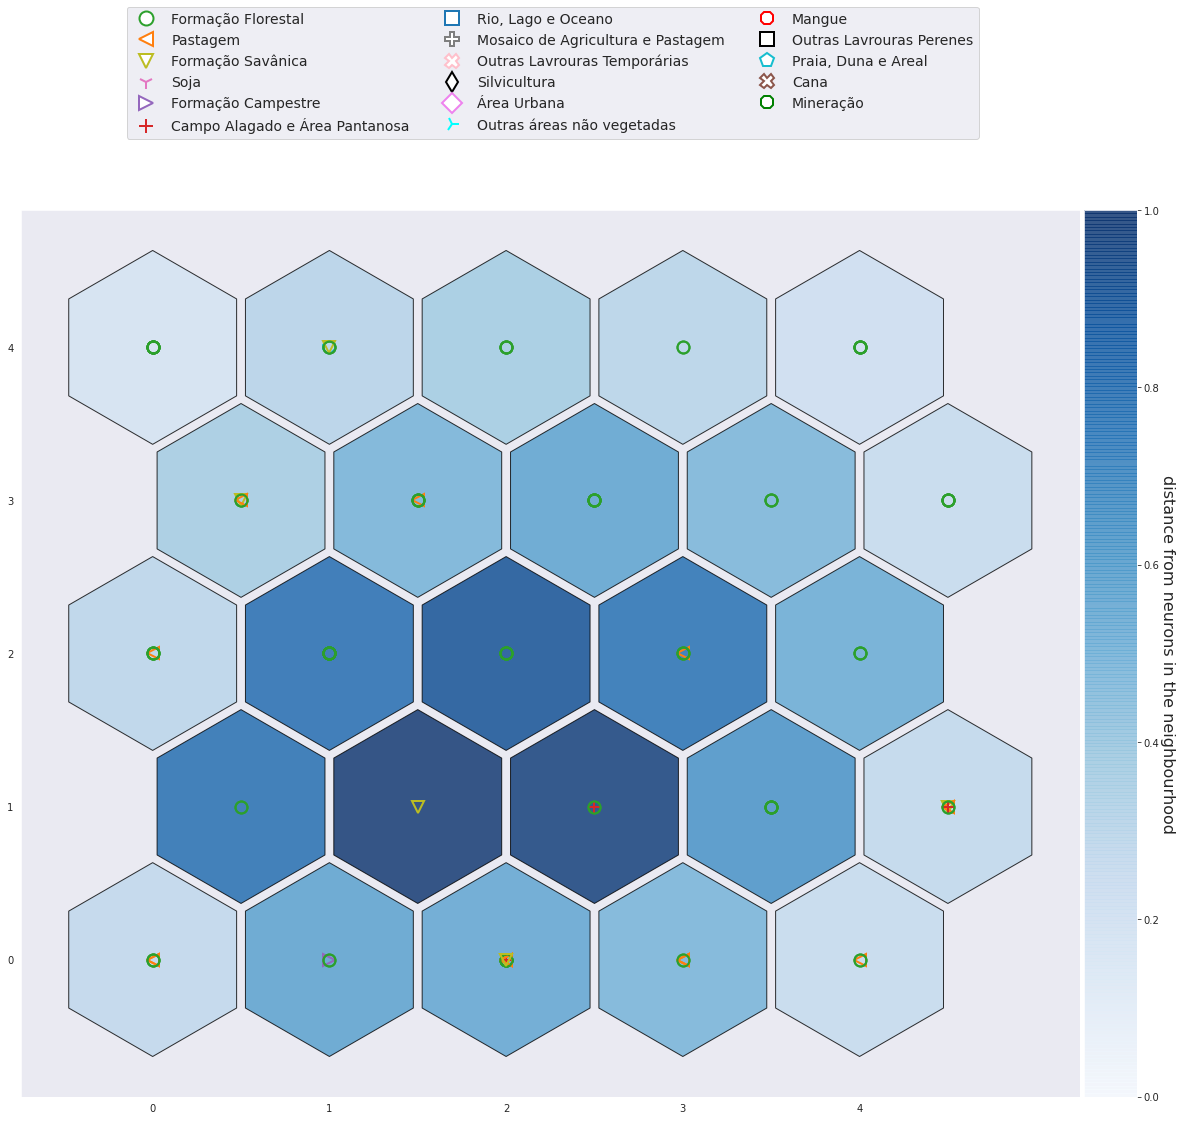

In [ ]:
create_hexagonal_topology_with_markers(som_1, X, y1, xx_1, yy_1, umatrix_1, weights_1, legend_elements, enum_errors_1,'teste')

In [ ]:
create_hexagonal_topology__makers_html(som_1, X, y1, xx_1, yy_1, umatrix_1, weights_1, legend_elements, enum_errors_1)

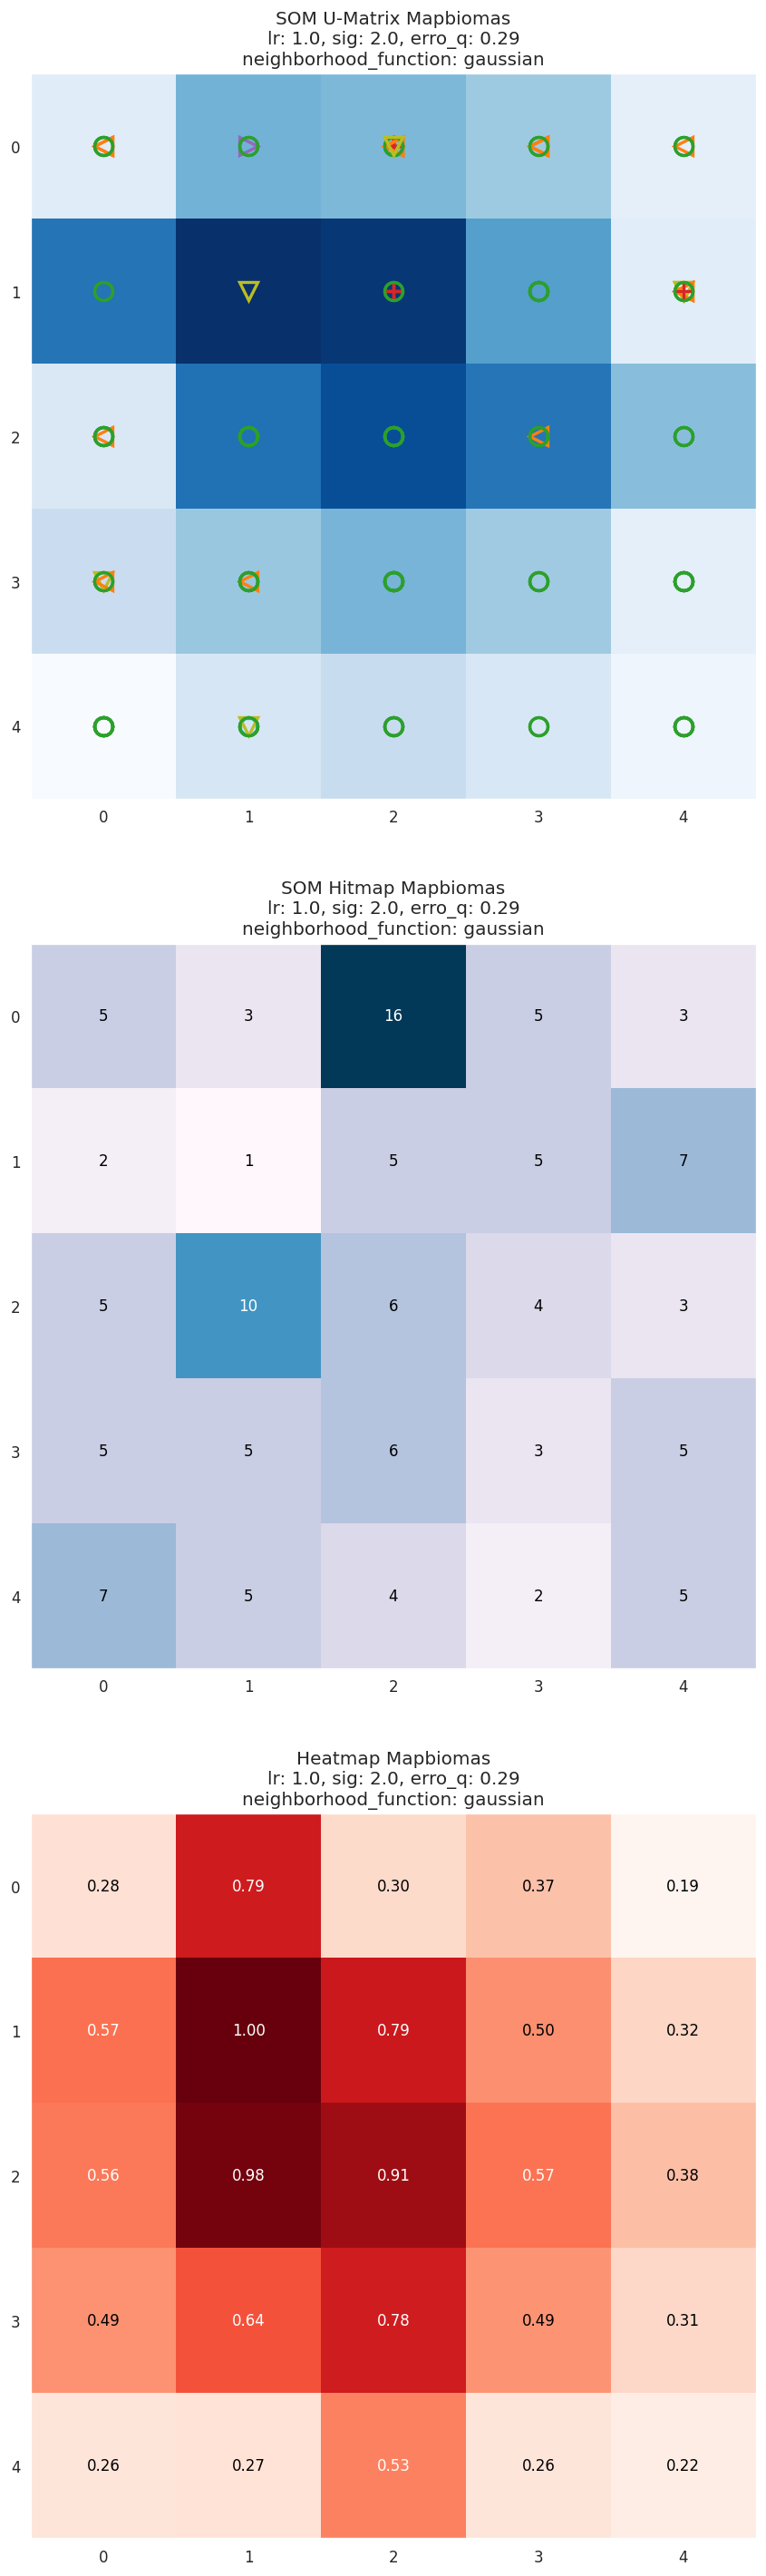

In [ ]:
create_umatrix_hitmap_heatmap(som_1, X, enum_errors_1, y1)

### Cálculo das médias por cluster

In [ ]:
co2_heatmap =  [1,2,3,5,6,7,8,11,12,13,14,15,16,17,18,24]
len(co2_heatmap)

16

In [ ]:
df_result

EVI      NDVI      xco2  xco2_uncer       sif   sif_unc  latitude  \
0    0.084392  0.106406  0.083142    0.080917  0.612297  0.630126  0.158335   
1    0.115101  0.203286  0.145649    0.117887  0.473550  0.598616  0.190560   
2    0.196718  0.384207  0.149284    0.161836  0.532274  0.631305  0.245553   
3    0.298145  0.427652  0.140413    0.135057  0.540702  0.622322  0.227696   
4    0.294571  0.412443  0.139151    0.159385  0.553170  0.615649  0.277469   
..        ...       ...       ...         ...       ...       ...       ...   
122  0.859790  0.907263  0.677224    0.410930  0.761638  0.787675  0.278960   
123  0.740406  0.920136  0.698038    0.472544  0.646492  0.785548  0.332352   
124  0.743561  0.884402  0.708020    0.501588  0.630049  0.811681  0.362507   
125  1.000000  0.904928  0.739552    0.435704  1.000000  0.933805  0.528729   
126  0.372232  0.413349  1.000000    0.656190  0.266335  0.795622  0.258278   

     longitude  cluster_index            system_ind  \
0     0.792015             10  00000000000000000046   
1     0.787959             10  0000000000000000005c   
2     0.779827             10  00000000000000000075   
3     0.783096             10  00000000000000000076   
4     0.775766             10  00000000000000000093   
..         ...            ...                   ...   
122   0.079905              4  0000000000000000007d   
123   0.072495              4  0000000000000000009d   
124   0.067324              4  000000000000000000bd   
125   0.042327              4  00000000000000000143   
126   0.761417              0  00000000000000000093   

                                              geometry  
0    POLYGON ((-50.30566 -13.47473, -50.30566 -12.5...  
1    POLYGON ((-50.24951 -11.67810, -50.19337 -11.6...  
2    POLYGON ((-51.20397 -10.77978, -51.14783 -10.7...  
3    POLYGON ((-50.24951 -10.77978, -50.19337 -10.7...  
4    POLYGON ((-51.14783 -9.88147, -51.09168 -9.881...  
..                                                 ...  
122  POLYGON ((-70.23703 -10.77978, -70.29317 -10.7...  
123  POLYGON ((-70.74233 -8.98315, -70.63004 -8.983...  
124  POLYGON ((-70.74233 -8.08484, -70.63004 -8.084...  
125  POLYGON ((-71.86522 -5.38989, -71.86522 -4.491...  
126  POLYGON ((-51.20397 -10.77978, -51.20397 -9.88...  

[127 rows x 11 columns]

In [ ]:
cluster_mean = gpd.GeoDataFrame(columns=['cluster_index','xco2','sif','evi','ndvi'])

In [ ]:
group = df_result.groupby('cluster_index')

In [ ]:
group.get_group(3).xco2.mean()

0.5259995732010049

In [ ]:
list_clu = []
list_co2 = []
list_sif = []
list_evi = []
list_ndvi = []
for cluster in list_clusters:
    list_clu.append(cluster)
    list_co2.append(group.get_group(cluster).xco2.mean())
    list_sif.append(group.get_group(cluster).sif.mean())
    list_evi.append(group.get_group(cluster).EVI.mean())
    list_ndvi.append(group.get_group(cluster).NDVI.mean())

cluster_mean['cluster_index'] = list_clu
cluster_mean['xco2'] = list_co2
cluster_mean['sif'] = list_sif
cluster_mean['evi'] = list_evi
cluster_mean['ndvi'] = list_ndvi

In [ ]:
# cluster_mean = cluster_mean.set_index('cluster_index')

In [ ]:
cluster_mean = cluster_mean.sort_values(['cluster_index'])

In [ ]:
t = cluster_mean.iloc[:, 0:2].values


In [ ]:
#+ scale_color_manual(values=classPalette)
#     + scale_fill_manual(values=classPalette)

###Gráficos

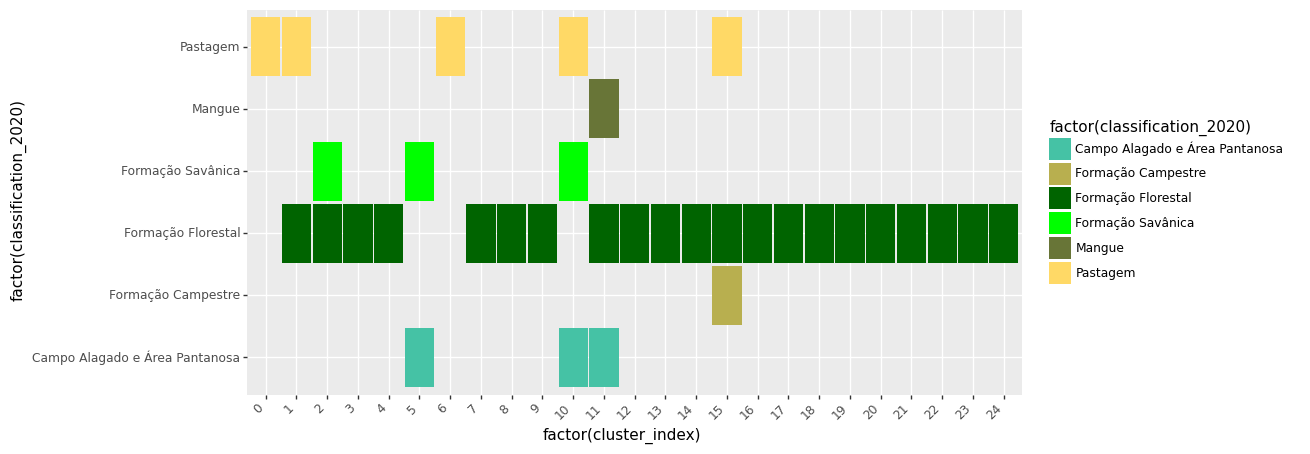

<ggplot: (8775042831583)>

In [ ]:
(
    ggplot(a)
    + geom_tile(aes('factor(cluster_index)', 'factor(classification_2020)', fill='factor(classification_2020)',width=.95, height=.95),show_legend=True)
     + scale_fill_manual(values=classPaletteSt)
     + theme(figure_size=(10,5), axis_text_x=element_text(rotation=45, hjust=1))
)

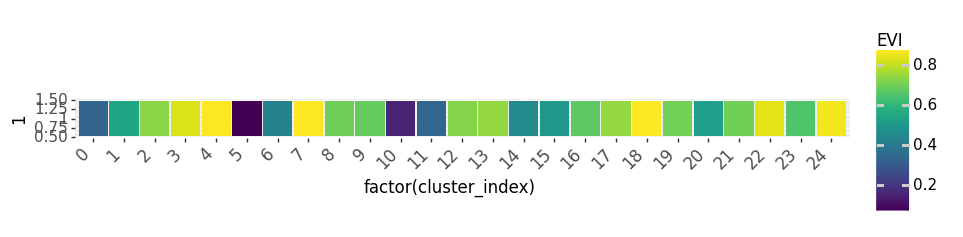

<ggplot: (8775042001538)>

In [ ]:
(
    ggplot(cluster_mean)
    + geom_tile(aes('factor(cluster_index)', 1, fill='evi',width=.95, height=.95),show_legend=True)
    + theme(figure_size=(10,0.5), axis_text_x=element_text(rotation=45, hjust=1,size=12))
    + theme(axis_text_y=element_text(size=11),axis_title=element_text(size=12),legend_title=element_text(size=12),legend_text=element_text(size=11))
    + labs(fill='EVI')
)

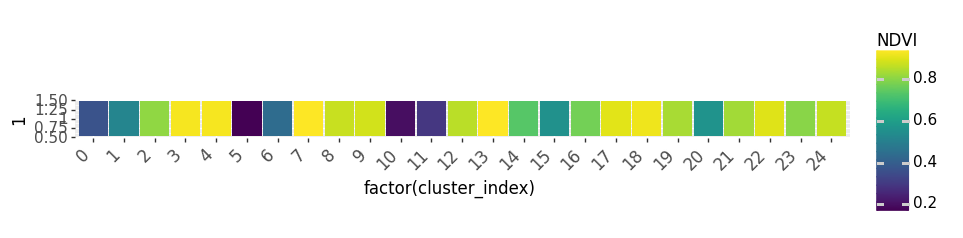

<ggplot: (8775042325917)>

In [ ]:
(
    ggplot(cluster_mean)
    + geom_tile(aes('factor(cluster_index)', 1, fill='ndvi',width=.95, height=.95),show_legend=True)
    + theme(figure_size=(10,0.5), axis_text_x=element_text(rotation=45, hjust=1,size=12))
    + theme(axis_text_y=element_text(size=11),axis_title=element_text(size=12),legend_title=element_text(size=12),legend_text=element_text(size=11))
    + labs(fill='NDVI')
)

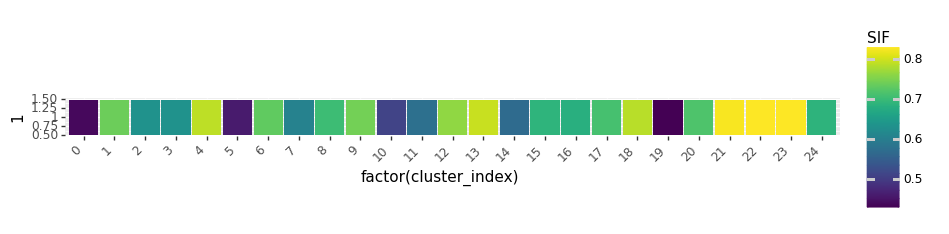

<ggplot: (8775044190724)>

In [ ]:
(
    ggplot(cluster_mean)
    + geom_tile(aes('factor(cluster_index)', 1, fill='sif',width=.95, height=.95),show_legend=True)
    + theme(figure_size=(10,0.5), axis_text_x=element_text(rotation=45, hjust=1))
    + labs(fill='SIF')
)

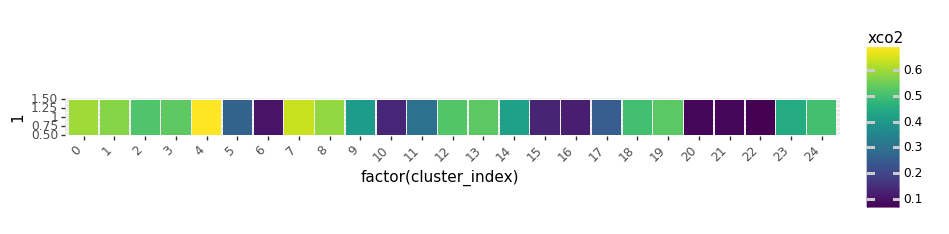

<ggplot: (8775042878898)>

In [ ]:
(
    ggplot(cluster_mean)
    + geom_tile(aes('factor(cluster_index)', 1, fill='xco2',width=.95, height=.95),show_legend=True)
    + theme(figure_size=(10,0.5), axis_text_x=element_text(rotation=45, hjust=1))
)

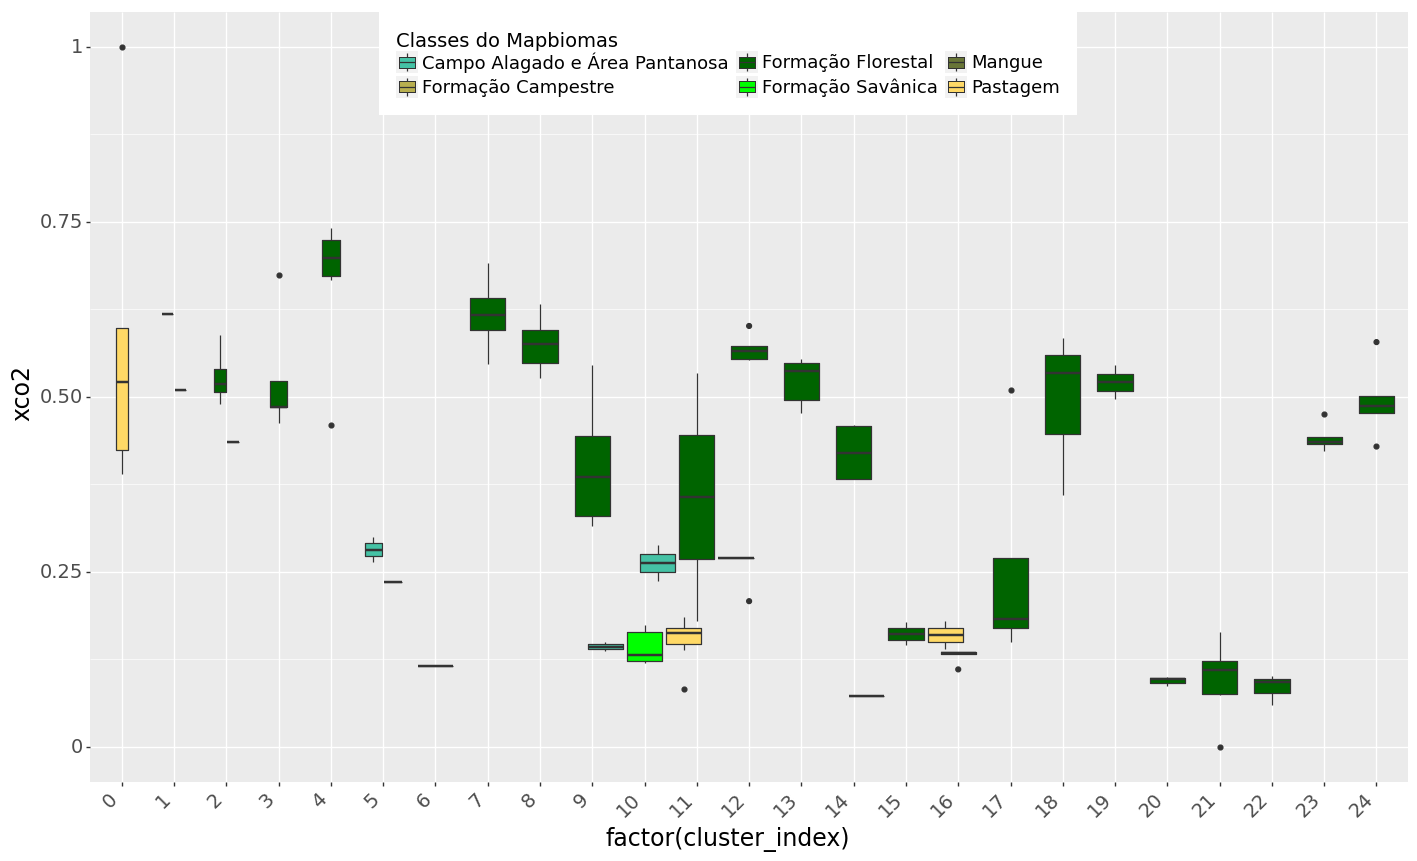

<ggplot: (8775045731446)>

In [ ]:
(
    ggplot(a, aes('factor(cluster_index)', 'xco2', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.5,.83),legend_title=element_text(size=14),legend_text=element_text(size=13),legend_direction='horizontal')
    + labs(fill='Classes do Mapbiomas')
)

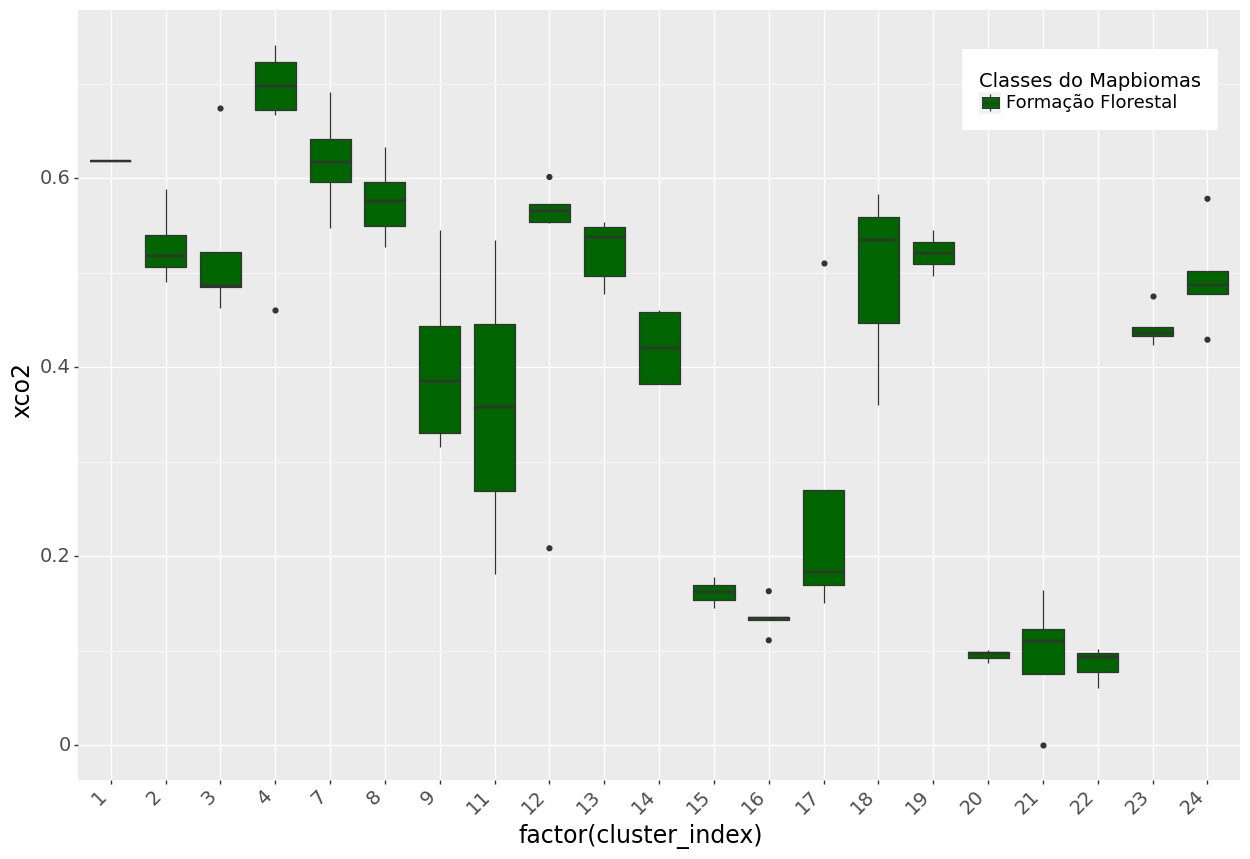

<ggplot: (8775043097610)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Formação Florestal'], aes('factor(cluster_index)', 'xco2', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(15,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

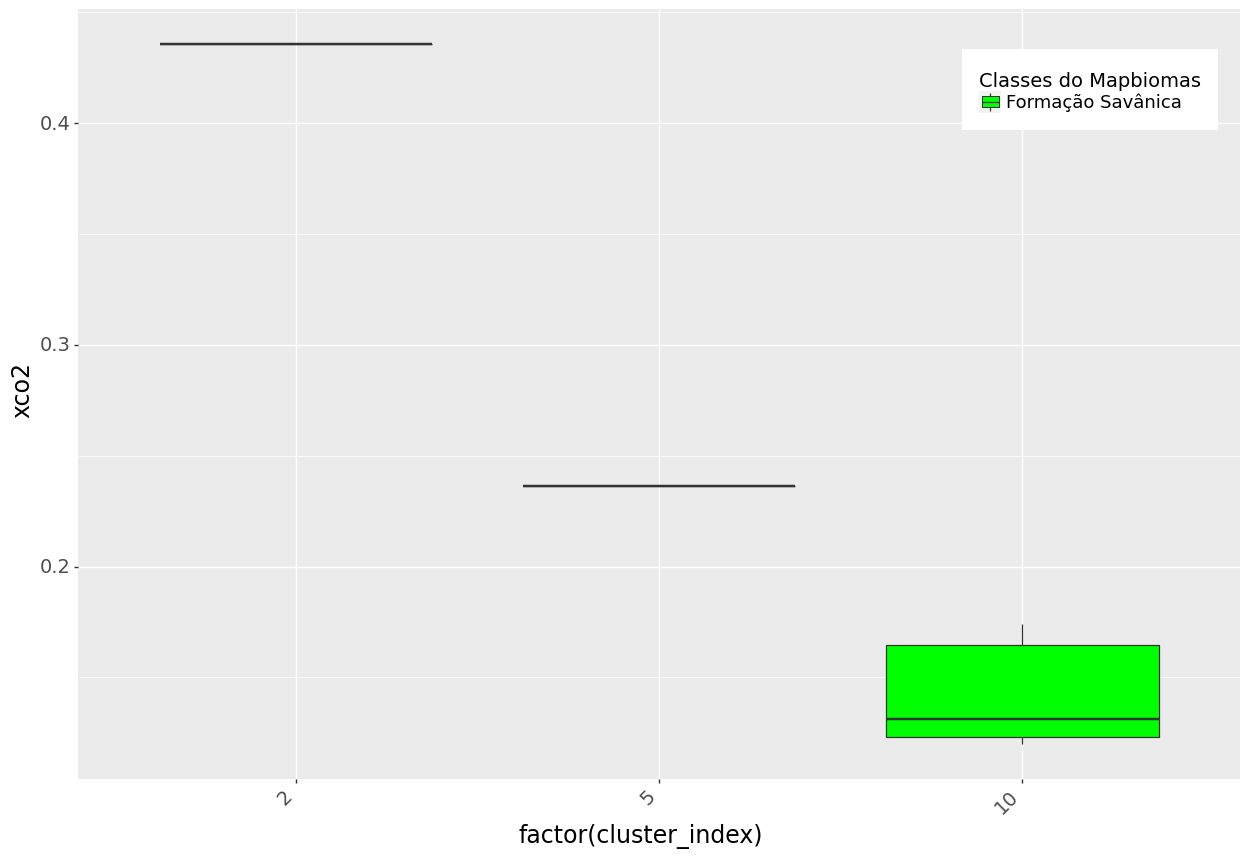

<ggplot: (8775044913863)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Formação Savânica'], aes('factor(cluster_index)', 'xco2', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(15,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

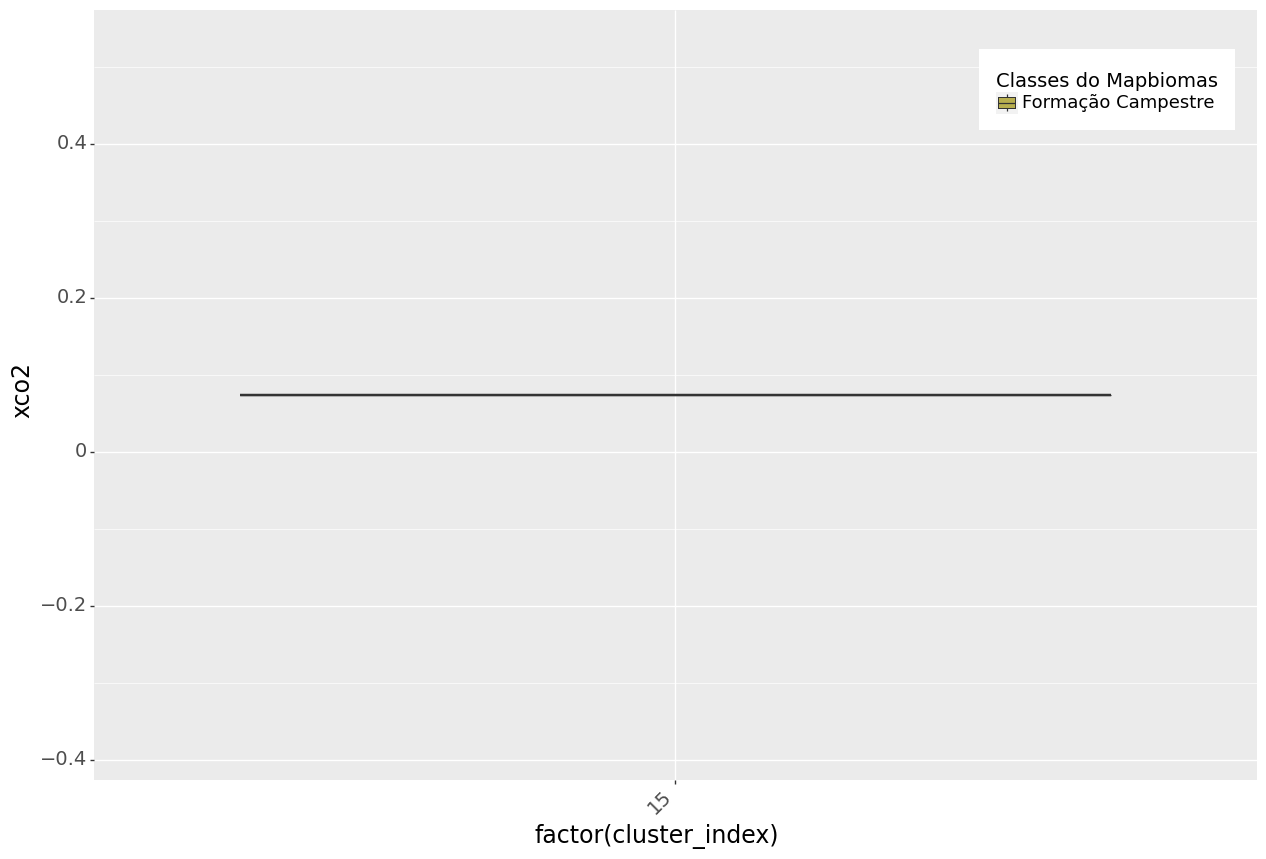

<ggplot: (8775042745634)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Formação Campestre'], aes('factor(cluster_index)', 'xco2', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(15,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

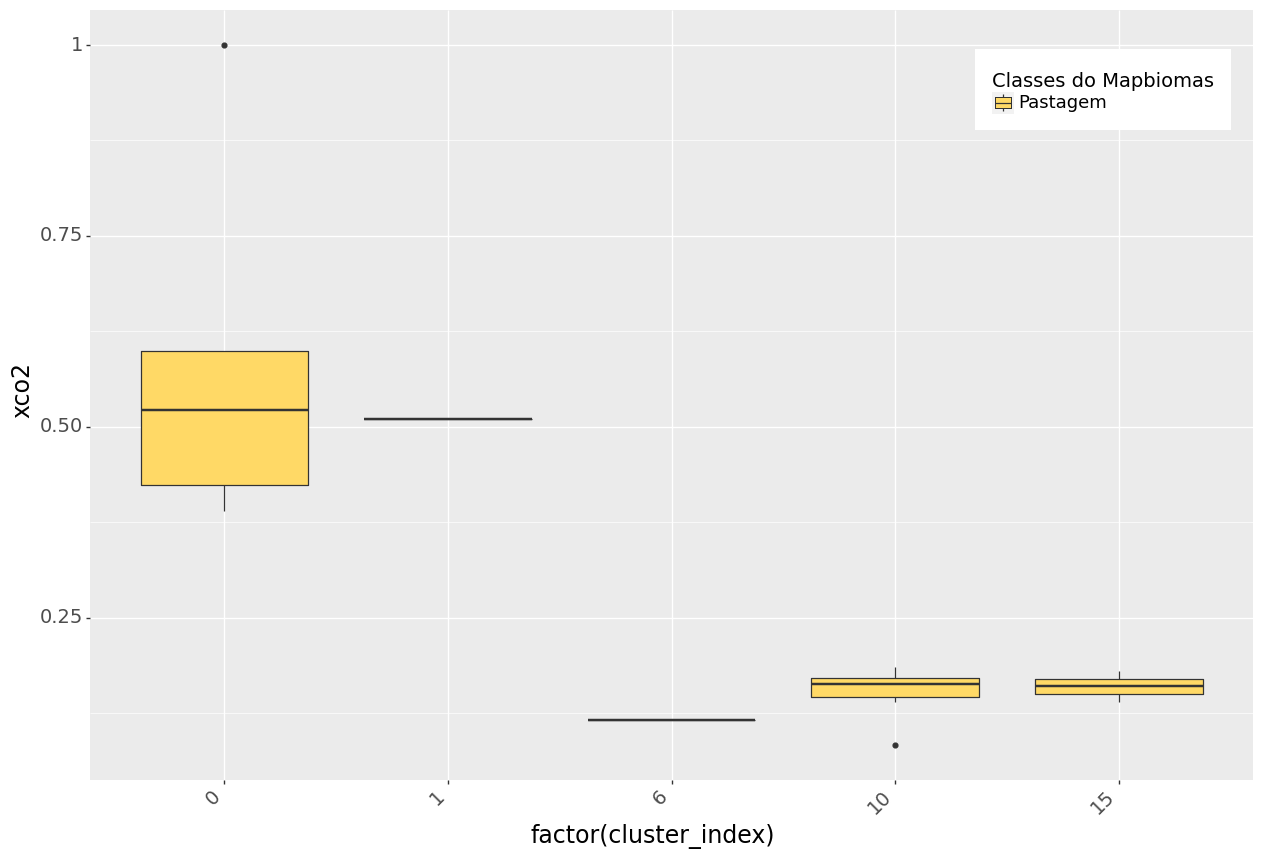

<ggplot: (8775046014480)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Pastagem'], aes('factor(cluster_index)', 'xco2', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(15,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

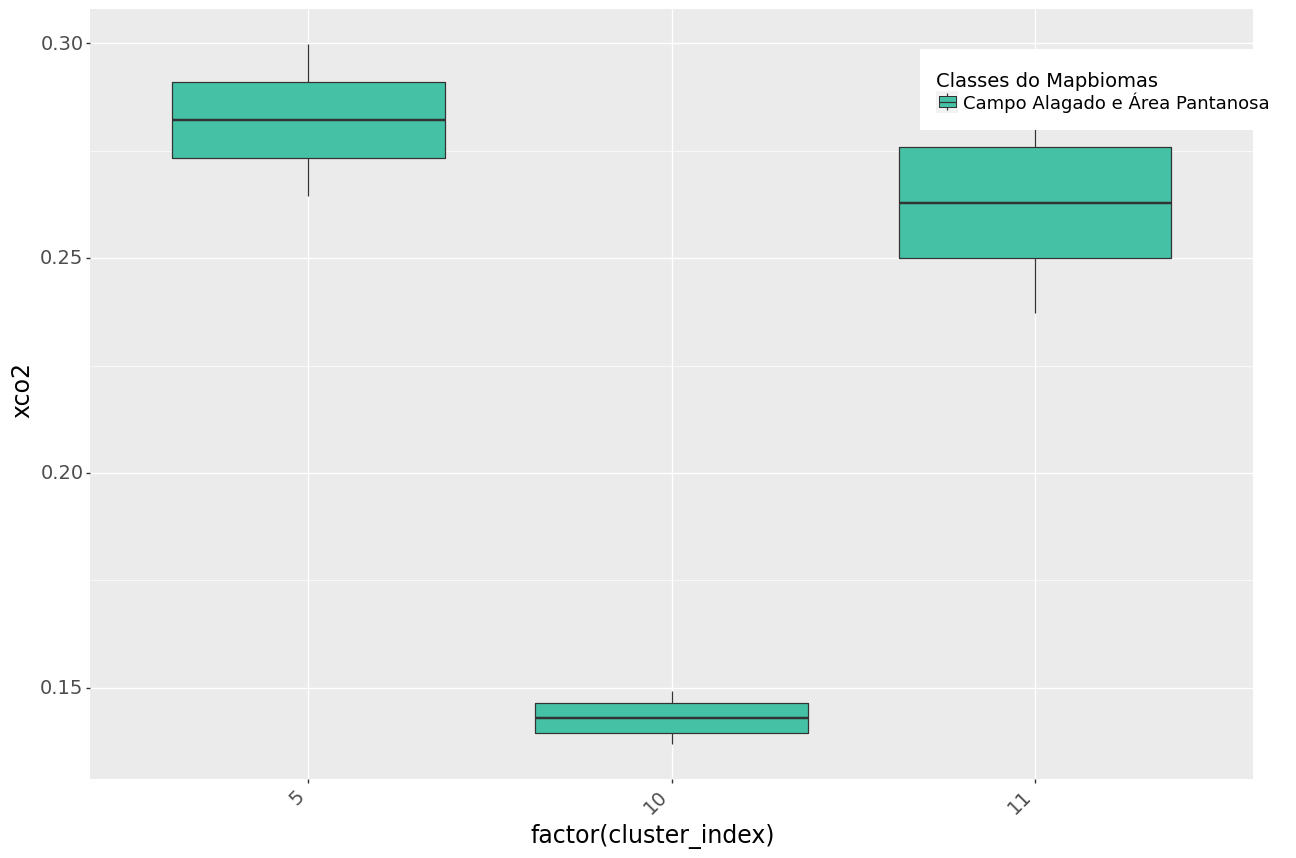

<ggplot: (8775047923722)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Campo Alagado e Área Pantanosa'], aes('factor(cluster_index)', 'xco2', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(15,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

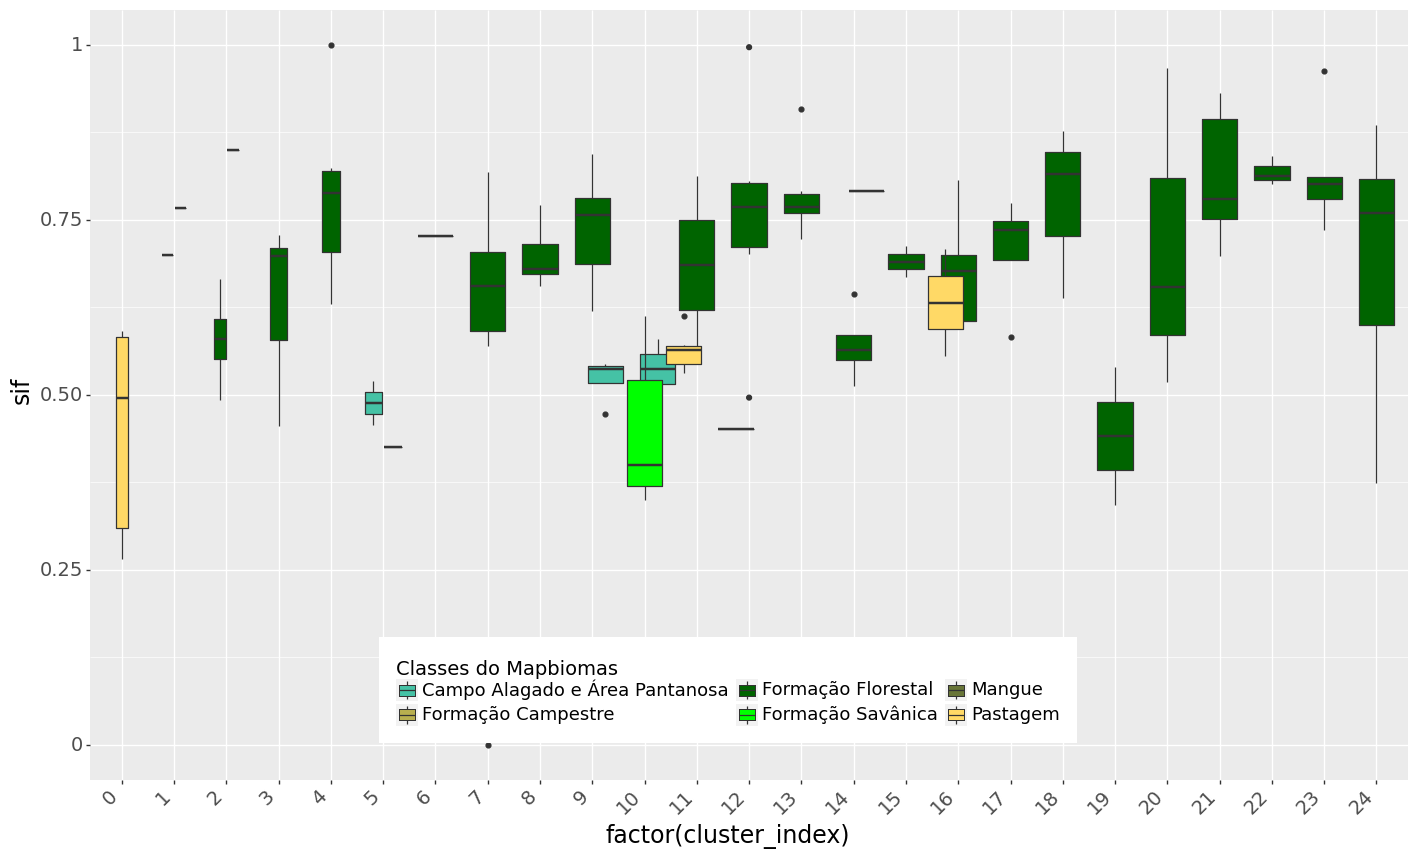

<ggplot: (8775046429693)>

In [ ]:
(
    ggplot(a, aes('factor(cluster_index)', 'sif', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.5,.20),legend_title=element_text(size=14),legend_text=element_text(size=13),legend_direction='horizontal')
    + labs(fill='Classes do Mapbiomas')
)

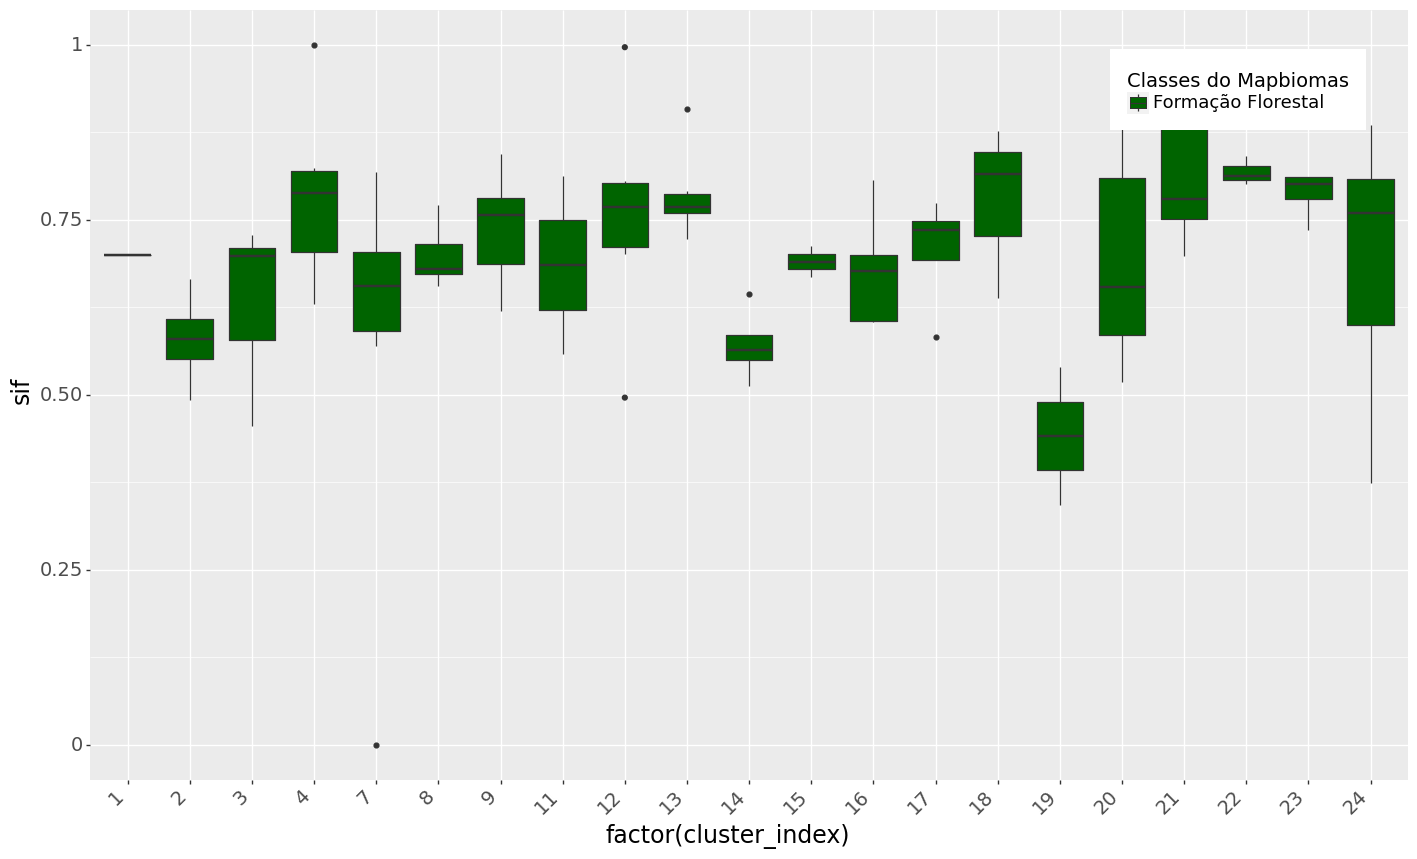

<ggplot: (8775044442025)>

In [ ]:

(
    ggplot(a[a.classification_2020 == 'Formação Florestal'], aes('factor(cluster_index)', 'sif', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

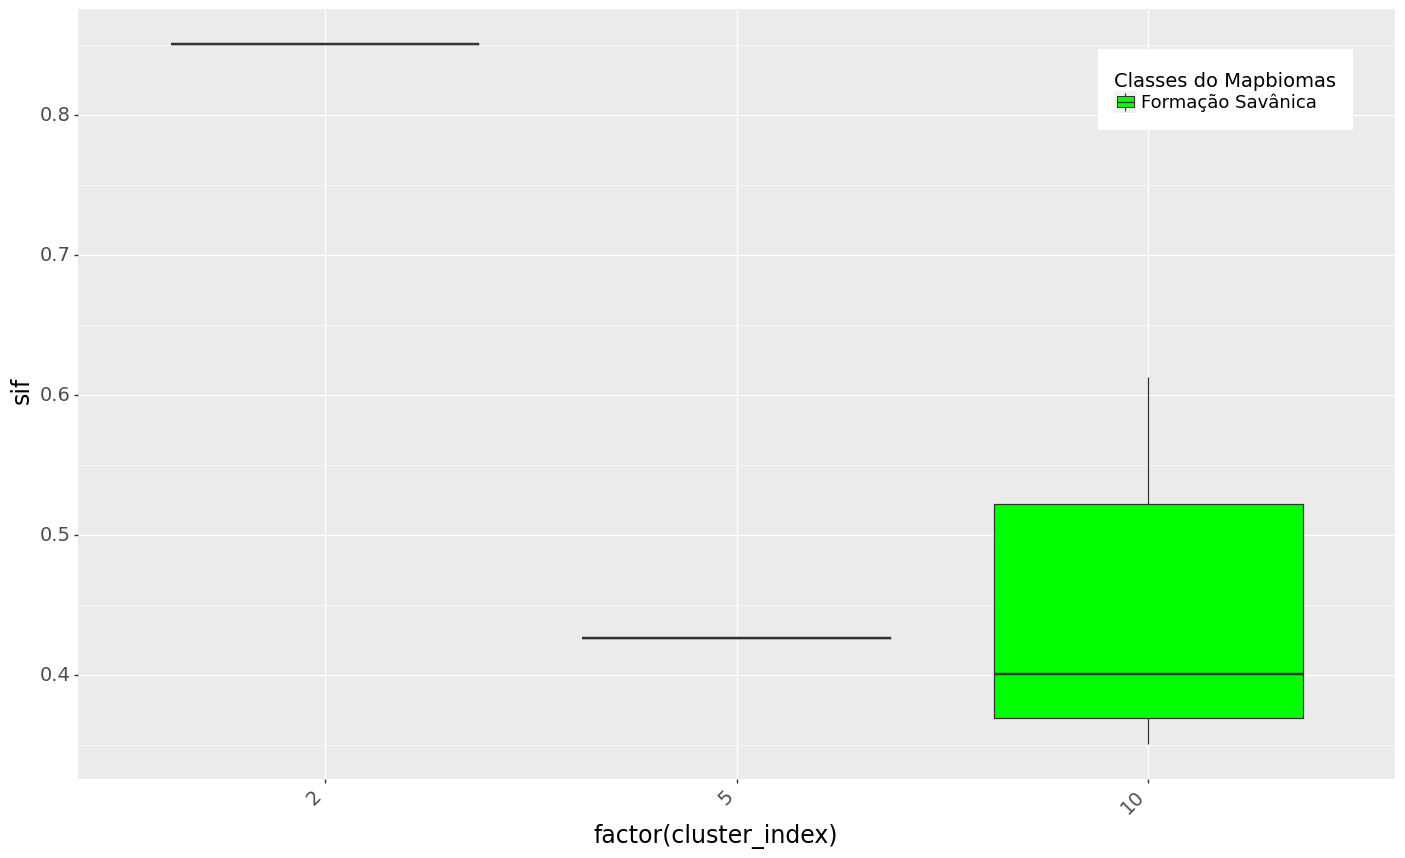

<ggplot: (8775044119697)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Formação Savânica'], aes('factor(cluster_index)', 'sif', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

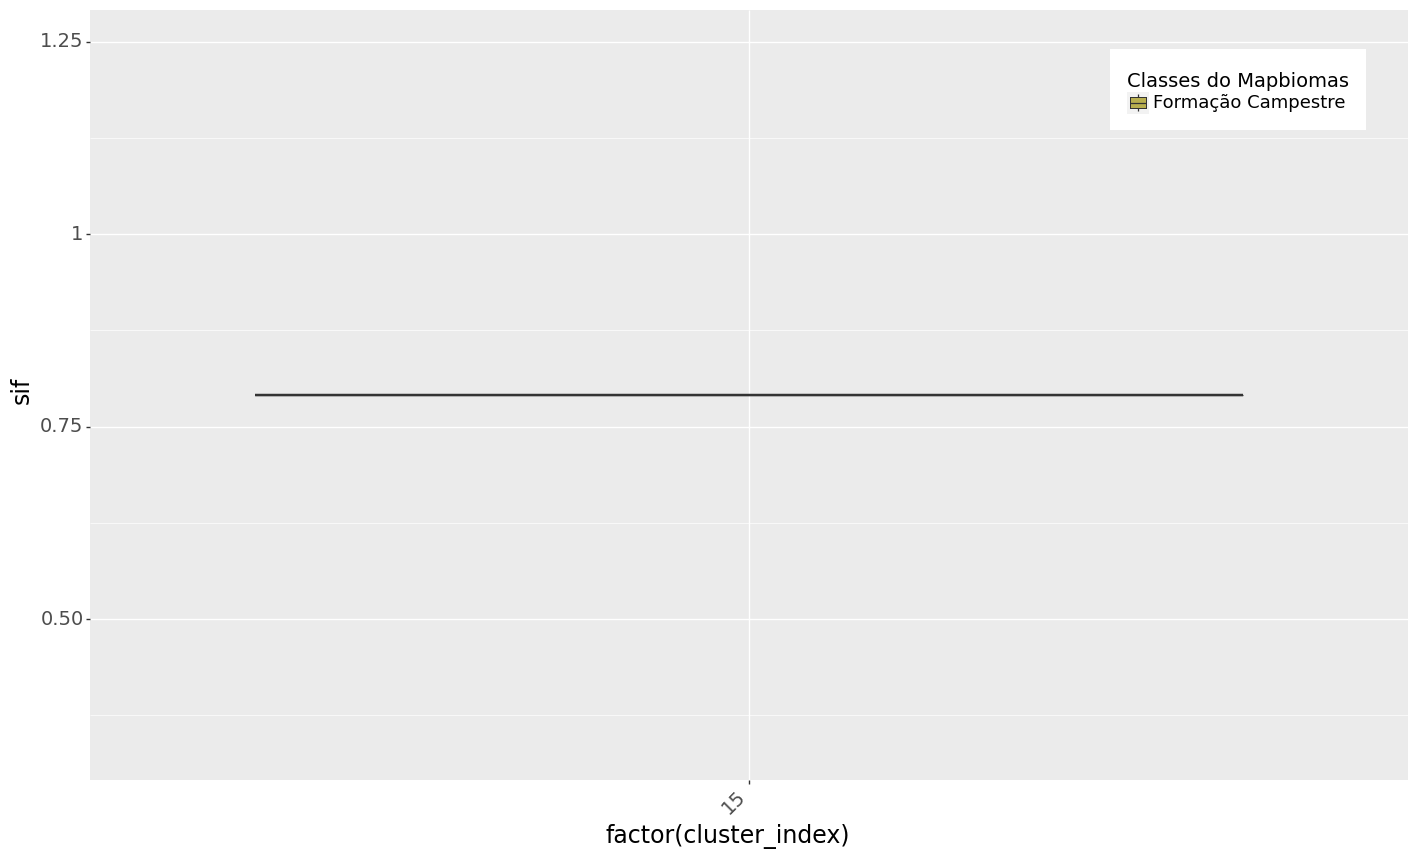

<ggplot: (8775044123627)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Formação Campestre'], aes('factor(cluster_index)', 'sif', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

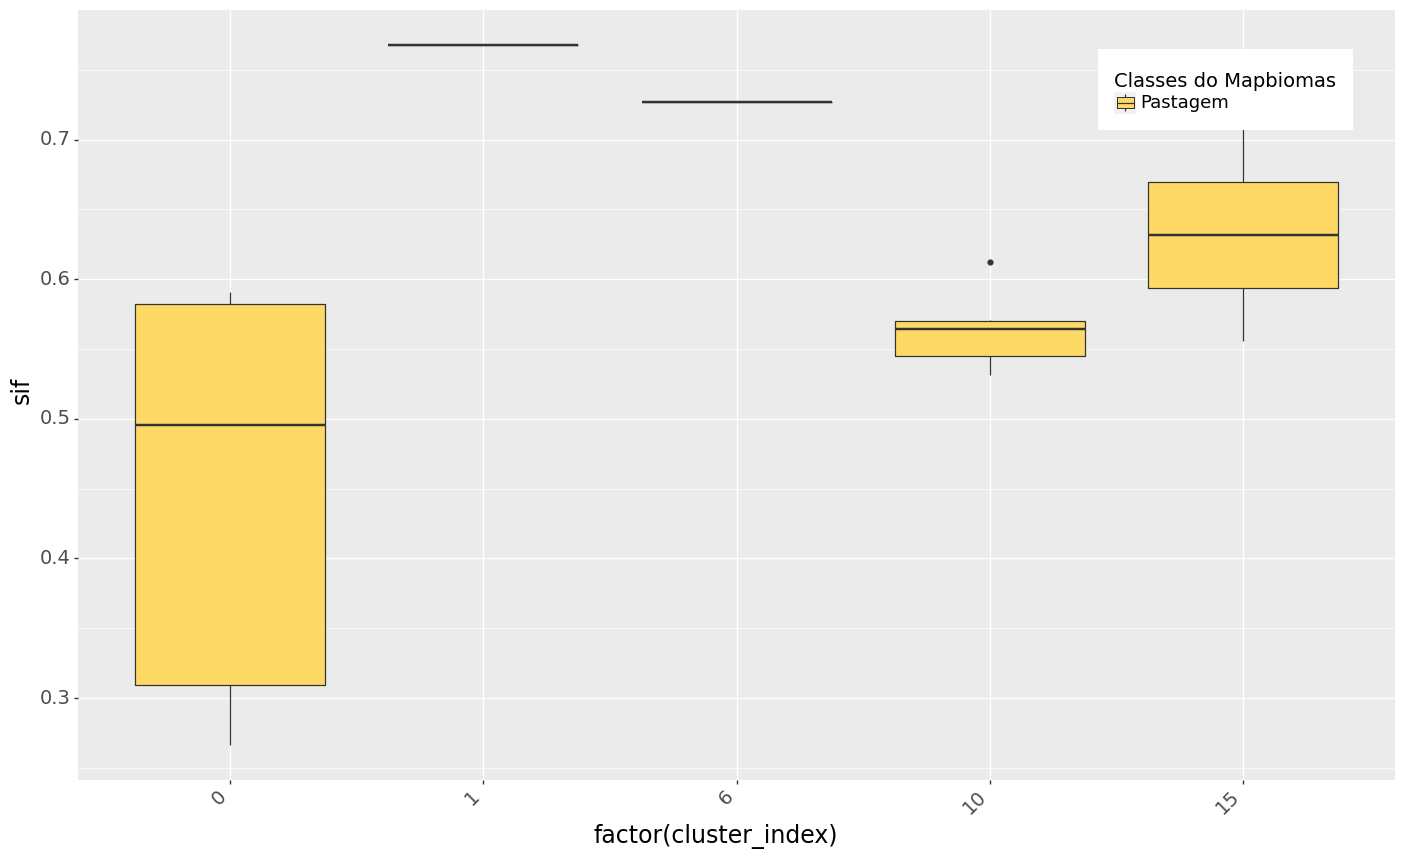

<ggplot: (8775042912844)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Pastagem'], aes('factor(cluster_index)', 'sif', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

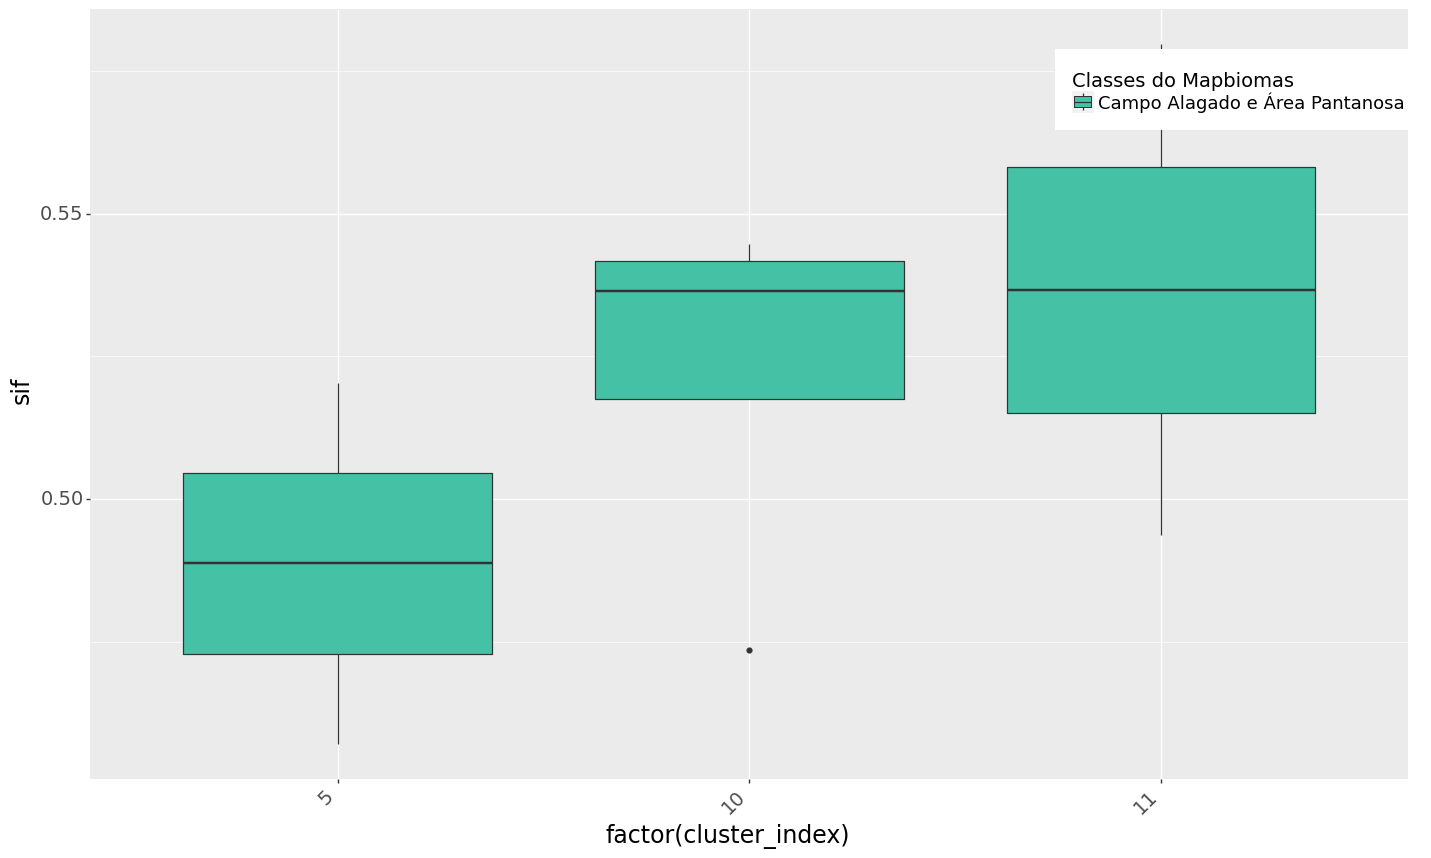

<ggplot: (8775042947301)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Campo Alagado e Área Pantanosa'], aes('factor(cluster_index)', 'sif', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

In [ ]:
a.columns

Index(['EVI', 'NDVI', 'xco2', 'xco2_uncer', 'sif', 'sif_unc', 'latitude',
       'longitude', 'cluster_index', 'system_ind', 'geometry', 'system:index',
       'classification_1985', 'classification_1986', 'classification_1987',
       'classification_1988', 'classification_1989', 'classification_1990',
       'classification_1991', 'classification_1992', 'classification_1993',
       'classification_1994', 'classification_1995', 'classification_1996',
       'classification_1997', 'classification_1998', 'classification_1999',
       'classification_2000', 'classification_2001', 'classification_2002',
       'classification_2003', 'classification_2004', 'classification_2005',
       'classification_2006', 'classification_2007', 'classification_2008',
       'classification_2009', 'classification_2010', 'classification_2011',
       'classification_2012', 'classification_2013', 'classification_2014',
       'classification_2015', 'classification_2016', 'classification_2017',
       'cla

In [ ]:
list_class = ['classification_2015', 'classification_2016', 'classification_2017',
       'classification_2018', 'classification_2019', 'classification_2020']

In [ ]:
df_count = pd.DataFrame(columns=['cluster_index','year','count'])

In [ ]:
for year_class in list_class:
  print('year_class',year_class)
  for cluster in list_clusters:
    print('cluster',cluster)
    print(a[a.cluster_index == cluster][year_class].value_counts())


year_class classification_2015
cluster 10
Pastagem                          7
Formação Savânica                 5
Campo Alagado e Área Pantanosa    3
Rio, Lago e Oceano                1
Name: classification_2015, dtype: int64
cluster 15
Formação Florestal    2
Pastagem              2
Formação Campestre    1
Name: classification_2015, dtype: int64
cluster 17
Formação Florestal    4
Name: classification_2015, dtype: int64
cluster 16
Formação Florestal    5
Name: classification_2015, dtype: int64
cluster 6
Formação Florestal    1
Name: classification_2015, dtype: int64
cluster 21
Formação Florestal    7
Name: classification_2015, dtype: int64
cluster 20
Formação Florestal    3
Name: classification_2015, dtype: int64
cluster 22
Formação Florestal    3
Name: classification_2015, dtype: int64
cluster 5
Campo Alagado e Área Pantanosa    2
Formação Savânica                 1
Name: classification_2015, dtype: int64
cluster 12
Formação Florestal    6
Name: classification_2015, dtype: int64
clust

# Importação e Preparação dos Dados LAI

Dados do satélite OCO-2 para o período entre os dias 01-08-2015 e 31-09-2021

In [ ]:
print(geodf_lai.isna().sum())
print(geodf_lai.shape)

Unnamed: 0      0
system_ind      0
FparExtra_      0
FparLai_QC      0
FparStdDev      0
Fpar_500m       0
LaiStdDev_      0
Lai_500m        0
index_righ      0
xco2            0
xco2_uncer      0
sif             0
sif_unc         0
out_flag        0
sound_id        0
latitude        0
longitude       0
land_w_ind      0
land_frac       0
geometry        0
sound_mode    342
dtype: int64
(342, 21)


In [ ]:
geodf_lai.head(3)

Unnamed: 0            system_ind  FparExtra_  FparLai_QC  FparStdDev  \
0           0  00000000000000000038  121.830645    0.774194    2.048387   
1           1  00000000000000000068   73.760000   14.464000    3.644000   
2           2  00000000000000000086  128.000000    0.000000    4.000000   

   Fpar_500m  LaiStdDev_   Lai_500m  index_righ        xco2  ...  \
0  85.346774    5.903226  52.250000       231.5  397.706875  ...   
1  66.752000    4.356000  30.656000       228.5  396.535610  ...   
2  68.706422    4.353211  31.766055       226.0  396.802297  ...   

            sif       sif_unc  out_flag      sound_id   latitude  longitude  \
0  1.063199e+18  4.053362e+17       1.0  2.015081e+15 -12.787742 -62.240939   
1  1.457216e+18  3.898837e+17       1.0  2.015081e+15 -10.905663 -62.582070   
2  2.789171e+18  4.183142e+17       1.0  2.015081e+15 -10.726958 -62.628413   

   land_w_ind  land_frac                                           geometry  \
0         0.0      100.0  POLYGON ((-62.03990 -13.47473, -62.09605 -13.4...   
1         0.0      100.0  POLYGON ((-62.88207 -11.67810, -62.88207 -10.7...   
2         0.0      100.0  POLYGON ((-62.88207 -10.77978, -62.88207 -9.88...   

  sound_mode  
0        NaN  
1        NaN  
2        NaN  

[3 rows x 21 columns]

In [ ]:
geodf_lai = geodf_lai.drop(columns=['sound_mode','Unnamed: 0'])
geodf_lai['Lai_500m'] = geodf_lai['Lai_500m']*0.1
geodf_lai['Fpar_500m'] = geodf_lai['Fpar_500m']*0.01
geodf_lai['LaiStdDev'] = geodf_lai['LaiStdDev_']*0.1
geodf_lai['FparStdDev'] = geodf_lai['FparStdDev']*0.01

In [ ]:
geodf_lai.columns

Index(['system_ind', 'FparExtra_', 'FparLai_QC', 'FparStdDev', 'Fpar_500m',
       'LaiStdDev_', 'Lai_500m', 'index_righ', 'xco2', 'xco2_uncer', 'sif',
       'sif_unc', 'out_flag', 'sound_id', 'latitude', 'longitude',
       'land_w_ind', 'land_frac', 'geometry', 'LaiStdDev'],
      dtype='object')

In [ ]:
print(geodf_lai.xco2.describe())

count    342.000000
mean     402.857666
std        5.415625
min      392.456400
25%      397.690741
50%      402.932600
75%      407.106715
max      418.768100
Name: xco2, dtype: float64


In [ ]:
print(geodf_lai.sif.describe())

count    3.420000e+02
mean     2.446922e+18
std      1.155171e+18
min     -2.525493e+18
25%      1.811839e+18
50%      2.614691e+18
75%      3.146910e+18
max      7.961969e+18
Name: sif, dtype: float64


In [ ]:
print(geodf_lai.Lai_500m.describe())

count    342.000000
mean       4.902556
std        1.425743
min        1.100000
25%        4.349968
50%        5.380176
75%        5.963889
max        6.594841
Name: Lai_500m, dtype: float64


In [ ]:
geodf_lai['datetime'] = pd.to_datetime(geodf_lai['sound_id'], format='%Y%m%d%H%M%S%f')
geodf_lai['day_date'] = [d.date() for d in geodf_lai['datetime']]
geodf_lai['day_date'] = [d.isoformat() for d in geodf_lai['day_date']]
geodf_lai['day_time'] = [d.time()for d in geodf_lai['datetime']]
geodf_lai['day_time'] = [d.isoformat() for d in geodf_lai['day_time']]

In [ ]:
geodf_lai.land_w_ind.unique()

array([0.        , 0.23076923, 0.33333333, 0.09090909, 0.225     ,
       0.44444444, 1.5       , 0.95      , 0.13888889, 0.42857143,
       1.        , 0.38888889, 0.08333333, 0.625     , 0.1875    ,
       3.        , 0.5       ])

In [ ]:
geodf_lai.land_frac.unique()

array([100.        ,  99.48717969,  66.66666667,  90.90909091,
        82.91666665,  55.55555556,  92.5       ,   5.        ,
        86.11111111,  86.90476186,   0.        ,  77.46913556,
        91.66666667,  73.61111062,  99.0625    ,   8.333333  ,
        50.        ])

In [ ]:
geodf_lai.columns

Index(['system_ind', 'FparExtra_', 'FparLai_QC', 'FparStdDev', 'Fpar_500m',
       'LaiStdDev_', 'Lai_500m', 'index_righ', 'xco2', 'xco2_uncer', 'sif',
       'sif_unc', 'out_flag', 'sound_id', 'latitude', 'longitude',
       'land_w_ind', 'land_frac', 'geometry', 'LaiStdDev', 'datetime',
       'day_date', 'day_time'],
      dtype='object')

Limpando o Dataframe

In [ ]:
geodf_lai = geodf_lai.drop(columns=['FparExtra_', 'FparLai_QC','FparStdDev', 'Fpar_500m','land_w_ind', 'land_frac'])
geodf_lai = geodf_lai.dropna()

In [ ]:
#Tem células que se repetem (verificar a data de cada uma delas, é possivel identificar mudança de uso do solo?)
len(geodf_lai.system_ind.unique())

195

In [ ]:
geodf_lai.head(2)

system_ind  LaiStdDev_  Lai_500m  index_righ        xco2  \
0  00000000000000000038    5.903226    5.2250       231.5  397.706875   
1  00000000000000000068    4.356000    3.0656       228.5  396.535610   

   xco2_uncer           sif       sif_unc  out_flag      sound_id   latitude  \
0    0.634278  1.063199e+18  4.053362e+17       1.0  2.015081e+15 -12.787742   
1    0.509933  1.457216e+18  3.898837e+17       1.0  2.015081e+15 -10.905663   

   longitude                                           geometry  LaiStdDev  \
0 -62.240939  POLYGON ((-62.03990 -13.47473, -62.09605 -13.4...   0.590323   
1 -62.582070  POLYGON ((-62.88207 -11.67810, -62.88207 -10.7...   0.435600   

                 datetime    day_date         day_time  
0 2015-08-05 17:45:57.720  2015-08-05  17:45:57.720000  
1 2015-08-05 17:46:31.670  2015-08-05  17:46:31.670000

In [ ]:
# (
#     ggplot(df_co2) 
#     + aes(x='classification_2019', fill='factor(classification_2019)', color='factor(classification_2019)') 
#     + geom_bar()
#     + scale_color_manual(values=classPalette)
#     + scale_fill_manual(values=classPalette)
#     + theme(axis_text_x=element_text(rotation=90, hjust=1))
#     + theme(figure_size=(8, 5), panel_background=element_rect(fill='white'))
#     + labs(title='Distribuição dos dados por Classe', x='Classe', y='Contagem')

# )

É possível identificar uma correlação positiva de aproximadamente 0.3 entre os componentes da pressão atmosférica pressure_level e pressure_weight com a latitude  e uma correlação negativa dos mesmos componentes com a longitude, aproximadamente -0.44 e -0.69. Houve uma leve correlação positiva, em torno de 0.1 entre o xco2 e a pressure_weight e uma correlação negativa com a longitude.

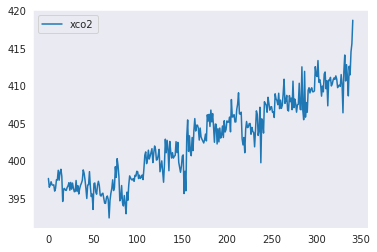

In [ ]:
geodf_lai.xco2.plot(legend=True)

In [ ]:
geodf_lai_clean = geodf_lai.drop(columns=['day_date', 'day_time', 'datetime', 'out_flag', 'sound_id','geometry','index_righ','system_ind'])

In [ ]:
geodf_lai_clean.corr()

LaiStdDev_  Lai_500m      xco2  xco2_uncer       sif   sif_unc  \
LaiStdDev_    1.000000  0.380762  0.114349    0.005074  0.065799  0.043149   
Lai_500m      0.380762  1.000000  0.216212    0.228940  0.407619  0.326547   
xco2          0.114349  0.216212  1.000000    0.192773 -0.002348  0.083636   
xco2_uncer    0.005074  0.228940  0.192773    1.000000  0.010721  0.029610   
sif           0.065799  0.407619 -0.002348    0.010721  1.000000  0.552505   
sif_unc       0.043149  0.326547  0.083636    0.029610  0.552505  1.000000   
latitude      0.206561  0.351866  0.069074   -0.106606  0.259333  0.269901   
longitude    -0.306199 -0.517040 -0.270891   -0.288855 -0.207254 -0.206924   
LaiStdDev     1.000000  0.380762  0.114349    0.005074  0.065799  0.043149   

            latitude  longitude  LaiStdDev  
LaiStdDev_  0.206561  -0.306199   1.000000  
Lai_500m    0.351866  -0.517040   0.380762  
xco2        0.069074  -0.270891   0.114349  
xco2_uncer -0.106606  -0.288855   0.005074  
sif         0.259333  -0.207254   0.065799  
sif_unc     0.269901  -0.206924   0.043149  
latitude    1.000000  -0.137422   0.206561  
longitude  -0.137422   1.000000  -0.306199  
LaiStdDev   0.206561  -0.306199   1.000000

In [ ]:
geodf_lai_clean = geodf_lai_clean.drop(columns=['LaiStdDev_'])

In [ ]:
geodf_lai_clean.columns

Index(['Lai_500m', 'xco2', 'xco2_uncer', 'sif', 'sif_unc', 'latitude',
       'longitude', 'LaiStdDev'],
      dtype='object')

In [ ]:
geodf_lai_norm = normalize_dataframe(geodf_lai_clean)

In [ ]:
geodf_lai_norm.head()

Lai_500m      xco2  xco2_uncer       sif   sif_unc  latitude  longitude  \
0  0.750704  0.199549    0.305118  0.342189  0.667408  0.150334   0.366955   
1  0.357717  0.155034    0.193272  0.379759  0.641964  0.243385   0.355110   
2  0.377919  0.165170    0.239270  0.506764  0.688777  0.252220   0.353501   
3  0.814272  0.182986    0.299709  0.467859  0.697394  0.363071   0.336373   
4  0.811656  0.167230    0.261734  0.421192  0.683825  0.408777   0.329822   

   LaiStdDev  
0   0.603247  
1   0.364122  
2   0.363691  
3   0.736755  
4   0.812006

In [ ]:
# print(geodf_evi_norm[geodf_evi_norm.columns[-1]].head())
# y_treino=y_treino.astype('int')
print(geodf_lai_norm[geodf_lai_norm.columns[0:10]].head())

   Lai_500m      xco2  xco2_uncer       sif   sif_unc  latitude  longitude  \
0  0.750704  0.199549    0.305118  0.342189  0.667408  0.150334   0.366955   
1  0.357717  0.155034    0.193272  0.379759  0.641964  0.243385   0.355110   
2  0.377919  0.165170    0.239270  0.506764  0.688777  0.252220   0.353501   
3  0.814272  0.182986    0.299709  0.467859  0.697394  0.363071   0.336373   
4  0.811656  0.167230    0.261734  0.421192  0.683825  0.408777   0.329822   

   LaiStdDev  
0   0.603247  
1   0.364122  
2   0.363691  
3   0.736755  
4   0.812006  


# Rede SOM com os dados com LAI e FPAR





In [ ]:
# dfs_co2['classification_2019'] = dfs_co2['classification_2019'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas' })

In [ ]:
geodf_lai_norm.iloc[:, 0:].head()

Lai_500m      xco2  xco2_uncer       sif   sif_unc  latitude  longitude  \
0  0.750704  0.199549    0.305118  0.342189  0.667408  0.150334   0.366955   
1  0.357717  0.155034    0.193272  0.379759  0.641964  0.243385   0.355110   
2  0.377919  0.165170    0.239270  0.506764  0.688777  0.252220   0.353501   
3  0.814272  0.182986    0.299709  0.467859  0.697394  0.363071   0.336373   
4  0.811656  0.167230    0.261734  0.421192  0.683825  0.408777   0.329822   

   LaiStdDev  
0   0.603247  
1   0.364122  
2   0.363691  
3   0.736755  
4   0.812006

In [ ]:
# Escolha dos preditores
X = geodf_lai_norm.iloc[:, 0:].values
# y1 = dfs_co2[dfs_co2.columns[-1]]

In [ ]:
# ver o balanceamento das classes
# print(pd.Series(y1).value_counts())


### Geolocalização dos pontos

In [ ]:
# gdf_co2 = gpd.GeoDataFrame(df_co2, geometry = gpd.points_from_xy(df_co2.longitude, df_co2.latitude))

In [ ]:
# importar shapefiles de estados brasileiros
geo_ufs = geobr.read_state(code_state = 'all', year = 2019)
geo_ufs.head()

code_state abbrev_state name_state  code_region name_region  \
0        11.0           RO   Rondônia          1.0       Norte   
1        12.0           AC       Acre          1.0       Norte   
2        13.0           AM   Amazônas          1.0       Norte   
3        14.0           RR    Roraima          1.0       Norte   
4        15.0           PA       Pará          1.0       Norte   

                                            geometry  
0  MULTIPOLYGON (((-65.38150 -10.42907, -65.37916...  
1  MULTIPOLYGON (((-71.07772 -9.82774, -71.08554 ...  
2  MULTIPOLYGON (((-69.83766 -3.68659, -69.71230 ...  
3  MULTIPOLYGON (((-63.96008 2.47313, -63.96041 2...  
4  MULTIPOLYGON (((-51.43248 -0.47334, -51.42843 ...

## Modelo


Parâmetros da Rede:

    neighborhood_function: gaussian
    learning_rate: 1.0
    sigma: 2.0
    activation_distance: euclidean
    topology: hexagonal
    X_length: 6
    grid: 10 x 10
    num_interations = 10000

Uso do PCA para inicializar os pesos da rede. 

In [ ]:

functions = ['gaussian', 'mexican_hat', 'bublle', 'triangle']
func, lr, sig = functions[0], 1.0, 2.0
som_1_shape = (5, 5)
som_1 = MiniSom(x=5, y=5, input_len=8, sigma=sig, learning_rate=lr, activation_distance='euclidean',topology='hexagonal', 
             neighborhood_function=func)
som_1.pca_weights_init(X)
som_1.train(X, num_iteration=10000, verbose=True)


 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.3031467143188435


In [ ]:
X.shape

(342, 8)

In [ ]:
X

array([[0.75070412, 0.19954906, 0.30511769, ..., 0.15033383, 0.36695544,
        0.60324748],
       [0.35771734, 0.15503407, 0.19327156, ..., 0.24338472, 0.3551099 ,
        0.36412217],
       [0.37791911, 0.16516974, 0.23926987, ..., 0.25222   , 0.35350068,
        0.36369113],
       ...,
       [0.85869632, 0.84046375, 0.71022484, ..., 0.22401696, 0.34064647,
        0.08778497],
       [0.62225238, 0.88100161, 0.65503862, ..., 0.25080228, 0.33670673,
        0.15455101],
       [0.37594415, 1.        , 0.34973812, ..., 0.25582133, 0.76141727,
        0.13549677]])

In [ ]:
# each neuron represents a cluster
winner_coordinates_1 = np.array([som_1.winner(x) for x in X]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index_1 = np.ravel_multi_index(winner_coordinates_1, som_1_shape)

In [ ]:
geodf_lai.columns

Index(['system_ind', 'LaiStdDev_', 'Lai_500m', 'index_righ', 'xco2',
       'xco2_uncer', 'sif', 'sif_unc', 'out_flag', 'sound_id', 'latitude',
       'longitude', 'geometry', 'LaiStdDev', 'datetime', 'day_date',
       'day_time'],
      dtype='object')

In [ ]:
geodf_lai_norm.columns

Index(['Lai_500m', 'xco2', 'xco2_uncer', 'sif', 'sif_unc', 'latitude',
       'longitude', 'LaiStdDev'],
      dtype='object')

In [ ]:
list_col = ['Lai_500m', 'xco2',
       'xco2_uncer', 'sif', 'sif_unc', 'latitude', 'longitude', 'LaiStdDev']

df_result = get_results_from_model_and_save(X, list_col, cluster_index_1, geodf_lai)

In [ ]:
df_result.head()

Lai_500m      xco2  xco2_uncer       sif   sif_unc  latitude  longitude  \
0  0.750704  0.199549    0.305118  0.342189  0.667408  0.150334   0.366955   
1  0.357717  0.155034    0.193272  0.379759  0.641964  0.243385   0.355110   
2  0.377919  0.165170    0.239270  0.506764  0.688777  0.252220   0.353501   
3  0.814272  0.182986    0.299709  0.467859  0.697394  0.363071   0.336373   
4  0.811656  0.167230    0.261734  0.421192  0.683825  0.408777   0.329822   

   LaiStdDev  cluster_index            system_ind  \
0   0.603247             19  00000000000000000038   
1   0.364122             14  00000000000000000068   
2   0.363691             14  00000000000000000086   
3   0.736755             18  000000000000000000c5   
4   0.812006             22  000000000000000000e6   

                                            geometry  
0  POLYGON ((-62.03990 -13.47473, -62.09605 -13.4...  
1  POLYGON ((-62.88207 -11.67810, -62.88207 -10.7...  
2  POLYGON ((-62.88207 -10.77978, -62.88207 -9.88...  
3  POLYGON ((-63.44352 -8.08484, -63.33123 -8.084...  
4  POLYGON ((-63.44352 -7.18652, -63.33123 -7.186...

In [ ]:
list_clusters = df_result.cluster_index.unique()

In [ ]:
for cluster in list_clusters:
  print(cluster, df_result[df_result.cluster_index == cluster].shape)

19 (16, 11)
14 (10, 11)
18 (7, 11)
22 (11, 11)
23 (14, 11)
9 (29, 11)
4 (16, 11)
8 (9, 11)
7 (11, 11)
2 (11, 11)
24 (15, 11)
21 (12, 11)
3 (5, 11)
13 (22, 11)
17 (16, 11)
1 (27, 11)
5 (28, 11)
20 (6, 11)
10 (11, 11)
6 (15, 11)
16 (8, 11)
11 (5, 11)
12 (24, 11)
0 (10, 11)
15 (4, 11)


In [ ]:
df_result[df_result.cluster_index == 4].describe()
# df_result[df_result.cluster_index == 19].xco2.plot()
# df_result[df_result.cluster_index == 15].xco2.plot()
# df_result[df_result.cluster_index == 24].xco2.plot()

Lai_500m       xco2  xco2_uncer        sif    sif_unc   latitude  \
count  16.000000  16.000000   16.000000  16.000000  16.000000  16.000000   
mean    0.217759   0.254660    0.257262   0.419017   0.734552   0.471453   
std     0.115682   0.134908    0.081667   0.081864   0.065029   0.108957   
min     0.000000   0.115359    0.123678   0.246009   0.615649   0.274443   
25%     0.139249   0.150269    0.177490   0.379100   0.691345   0.379935   
50%     0.237252   0.182313    0.273812   0.397875   0.722281   0.468128   
75%     0.320865   0.407082    0.318527   0.497860   0.754605   0.564705   
max     0.372066   0.469147    0.383539   0.584169   0.874441   0.630866   

       longitude  LaiStdDev  cluster_index  
count  16.000000  16.000000           16.0  
mean    0.831764   0.174924            4.0  
std     0.096454   0.072411            0.0  
min     0.752463   0.062672            4.0  
25%     0.767562   0.139399            4.0  
50%     0.788976   0.167799            4.0  
75%     0.853994   0.220564            4.0  
max     0.999508   0.309713            4.0

In [ ]:
df_result[df_result.cluster_index == 5].describe()

Lai_500m       xco2  xco2_uncer        sif    sif_unc   latitude  \
count  28.000000  28.000000   28.000000  28.000000  28.000000  28.000000   
mean    0.883242   0.598185    0.377806   0.463925   0.747218   0.535140   
std     0.058373   0.094168    0.075703   0.072860   0.059174   0.121686   
min     0.754380   0.385948    0.262881   0.324776   0.650000   0.318221   
25%     0.857020   0.536724    0.335161   0.422796   0.700467   0.432912   
50%     0.893119   0.574052    0.362073   0.460183   0.731504   0.548067   
75%     0.923162   0.681123    0.416528   0.501253   0.784819   0.623832   
max     0.963822   0.775239    0.625205   0.664471   0.867804   0.739876   

       longitude  LaiStdDev  cluster_index  
count  28.000000  28.000000           28.0  
mean    0.227103   0.515786            5.0  
std     0.125160   0.164220            0.0  
min     0.000000   0.309102            5.0  
25%     0.130083   0.403151            5.0  
50%     0.175678   0.470734            5.0  
75%     0.311699   0.606085            5.0  
max     0.488525   1.000000            5.0

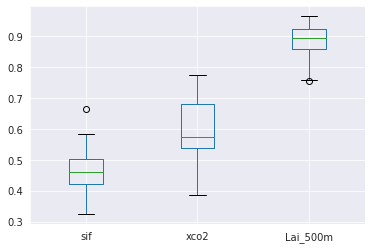

In [ ]:
df_result[df_result.cluster_index == 5].boxplot(column=['sif', 'xco2', 'Lai_500m'])

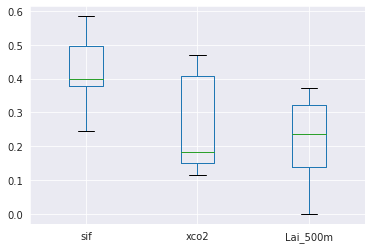

In [ ]:
df_result[df_result.cluster_index == 4].boxplot(column=['sif', 'xco2', 'Lai_500m',])

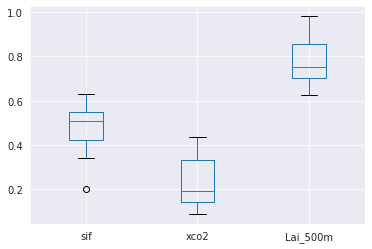

In [ ]:
df_result[df_result.cluster_index == 19].boxplot(column=['sif', 'xco2', 'Lai_500m'])

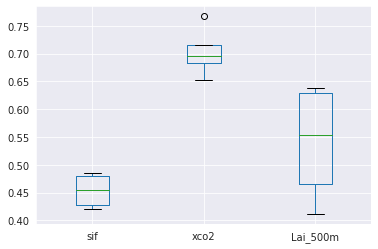

In [ ]:
df_result[df_result.cluster_index == 15].boxplot(column=['sif', 'xco2', 'Lai_500m'])

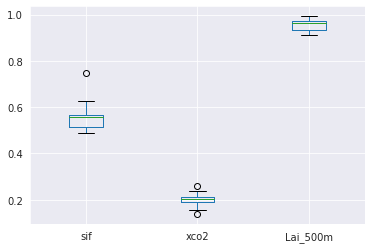

In [ ]:
df_result[df_result.cluster_index == 24].boxplot(column=['sif', 'xco2', 'Lai_500m'])

In [ ]:
from shapely import wkt
# df_result['geometry'] = df_result['geometry'].apply(wkt.loads)
geodf_result_lai = gpd.GeoDataFrame(df_result,crs='EPSG:4627')
# geodf_result_evi.set_geometry(col='geometry', inplace=True)

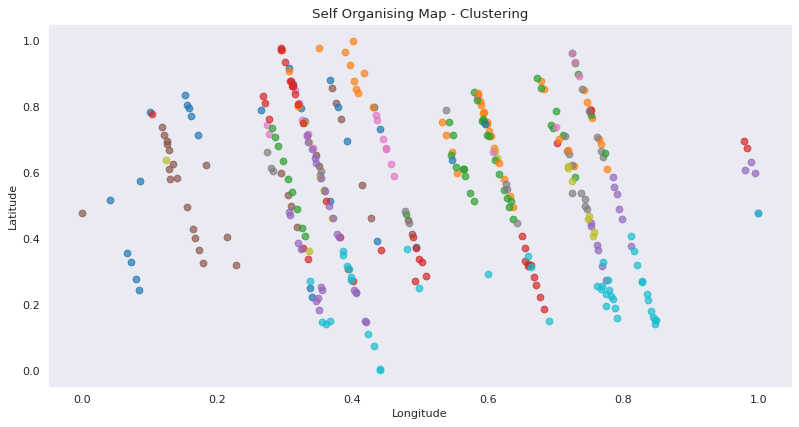

In [ ]:
a = plot_clusters_for_som(X, cluster_index_1, 5, 6)

In [ ]:
xx_1, yy_1 = som_1.get_euclidean_coordinates()
umatrix_1 = som_1.distance_map()
weights_1 = som_1.get_weights()

In [ ]:
# y1 = y1.dropna()
# y1 = y1.map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })

In [ ]:
# y1.unique()

In [ ]:
enum_errors_1 = []

In [ ]:
mapbiomas = pd.read_csv('/content/drive/MyDrive/oco-2_mapbiomas inverno-2015a2021/oco2-mapbiomas-inverno-Grid_Amazonia_Legal_100km.csv')
mapbiomas['system_ind'] = mapbiomas['system:index']
mapbiomas.head()

system:index  classification_1985  classification_1986  \
0  00000000000000000000                  4.0                  4.0   
1  00000000000000000001                 11.0                 11.0   
2  00000000000000000002                 33.0                 33.0   
3  00000000000000000003                 11.0                 33.0   
4  00000000000000000004                 11.0                  3.0   

   classification_1987  classification_1988  classification_1989  \
0                  4.0                  4.0                  4.0   
1                 11.0                 11.0                 11.0   
2                 11.0                 33.0                 11.0   
3                 11.0                 33.0                 11.0   
4                 11.0                 11.0                 11.0   

   classification_1990  classification_1991  classification_1992  \
0                 15.0                 15.0                 15.0   
1                 12.0                 11.0                 12.0   
2                 11.0                 11.0                 33.0   
3                 11.0                 11.0                 11.0   
4                 12.0                  4.0                  3.0   

   classification_1993  ...  classification_2013  classification_2014  \
0                 15.0  ...                 15.0                 15.0   
1                 11.0  ...                 12.0                 11.0   
2                 11.0  ...                 11.0                 12.0   
3                 11.0  ...                 11.0                 12.0   
4                  3.0  ...                  3.0                  3.0   

   classification_2015  classification_2016  classification_2017  \
0                 15.0                 15.0                 15.0   
1                 12.0                 11.0                 12.0   
2                 11.0                 12.0                 11.0   
3                 11.0                 12.0                 11.0   
4                  3.0                  3.0                  3.0   

   classification_2018  classification_2019  classification_2020  \
0                 15.0                 15.0                 15.0   
1                 12.0                 12.0                 12.0   
2                 11.0                 11.0                 12.0   
3                 11.0                 11.0                 11.0   
4                  3.0                  3.0                  3.0   

                                                .geo            system_ind  
0  {"type":"Polygon","coordinates":[[[-53.8989157...  00000000000000000000  
1  {"type":"Polygon","coordinates":[[[-59.2888096...  00000000000000000001  
2  {"type":"Polygon","coordinates":[[[-58.3904924...  00000000000000000002  
3  {"type":"Polygon","coordinates":[[[-57.4921798...  00000000000000000003  
4  {"type":"Polygon","coordinates":[[[-56.5938627...  00000000000000000004  

[5 rows x 39 columns]

In [ ]:
a = pd.merge(df_result,mapbiomas,'inner','system_ind' )

In [ ]:
a.columns

Index(['Lai_500m', 'xco2', 'xco2_uncer', 'sif', 'sif_unc', 'latitude',
       'longitude', 'LaiStdDev', 'cluster_index', 'system_ind', 'geometry',
       'system:index', 'classification_1985', 'classification_1986',
       'classification_1987', 'classification_1988', 'classification_1989',
       'classification_1990', 'classification_1991', 'classification_1992',
       'classification_1993', 'classification_1994', 'classification_1995',
       'classification_1996', 'classification_1997', 'classification_1998',
       'classification_1999', 'classification_2000', 'classification_2001',
       'classification_2002', 'classification_2003', 'classification_2004',
       'classification_2005', 'classification_2006', 'classification_2007',
       'classification_2008', 'classification_2009', 'classification_2010',
       'classification_2011', 'classification_2012', 'classification_2013',
       'classification_2014', 'classification_2015', 'classification_2016',
       'classification_2

In [ ]:
a['classification_2020'] = a['classification_2020'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })

In [ ]:

a['classification_2015'] = a['classification_2015'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })
a['classification_2016'] = a['classification_2016'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })
a['classification_2017'] = a['classification_2017'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })
a['classification_2018'] = a['classification_2018'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })
a['classification_2019'] = a['classification_2019'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })

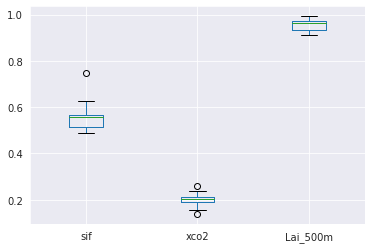

In [ ]:
a[a.cluster_index == 24].boxplot(column=['sif', 'xco2', 'Lai_500m'])

In [ ]:
for cluster in list_clusters:
  print(cluster, a[a.cluster_index == cluster].shape, a[a.cluster_index == cluster]['classification_2020'].unique())


19 (16, 49) ['Formação Savânica' 'Formação Florestal' 'Pastagem']
14 (10, 49) ['Pastagem' 'Formação Florestal']
18 (7, 49) ['Formação Florestal']
22 (11, 49) ['Formação Florestal']
23 (14, 49) ['Formação Florestal']
9 (29, 49) ['Pastagem' 'Campo Alagado e Área Pantanosa' 'Formação Savânica'
 'Formação Florestal']
4 (16, 49) ['Pastagem' 'Campo Alagado e Área Pantanosa' 'Formação Savânica']
8 (9, 49) ['Formação Florestal' 'Pastagem']
7 (11, 49) ['Formação Florestal']
2 (11, 49) ['Formação Florestal']
24 (15, 49) ['Formação Florestal']
21 (12, 49) ['Formação Florestal' 'Formação Campestre']
3 (5, 49) ['Formação Florestal' 'Formação Campestre' 'Mangue']
13 (22, 49) ['Formação Florestal' 'Pastagem']
17 (16, 49) ['Formação Florestal']
1 (27, 49) ['Formação Florestal' 'Formação Campestre']
5 (28, 49) ['Formação Florestal']
20 (6, 49) ['Formação Florestal']
10 (11, 49) ['Formação Florestal']
6 (15, 49) ['Formação Florestal']
16 (8, 49) ['Formação Florestal']
11 (5, 49) ['Formação Florestal']
1

In [ ]:
a.to_csv('/content/drive/MyDrive/resultados-oco2-som/5x5-100km-08-09-2015-2021-lai.csv')

In [ ]:
y1 = a['classification_2020']

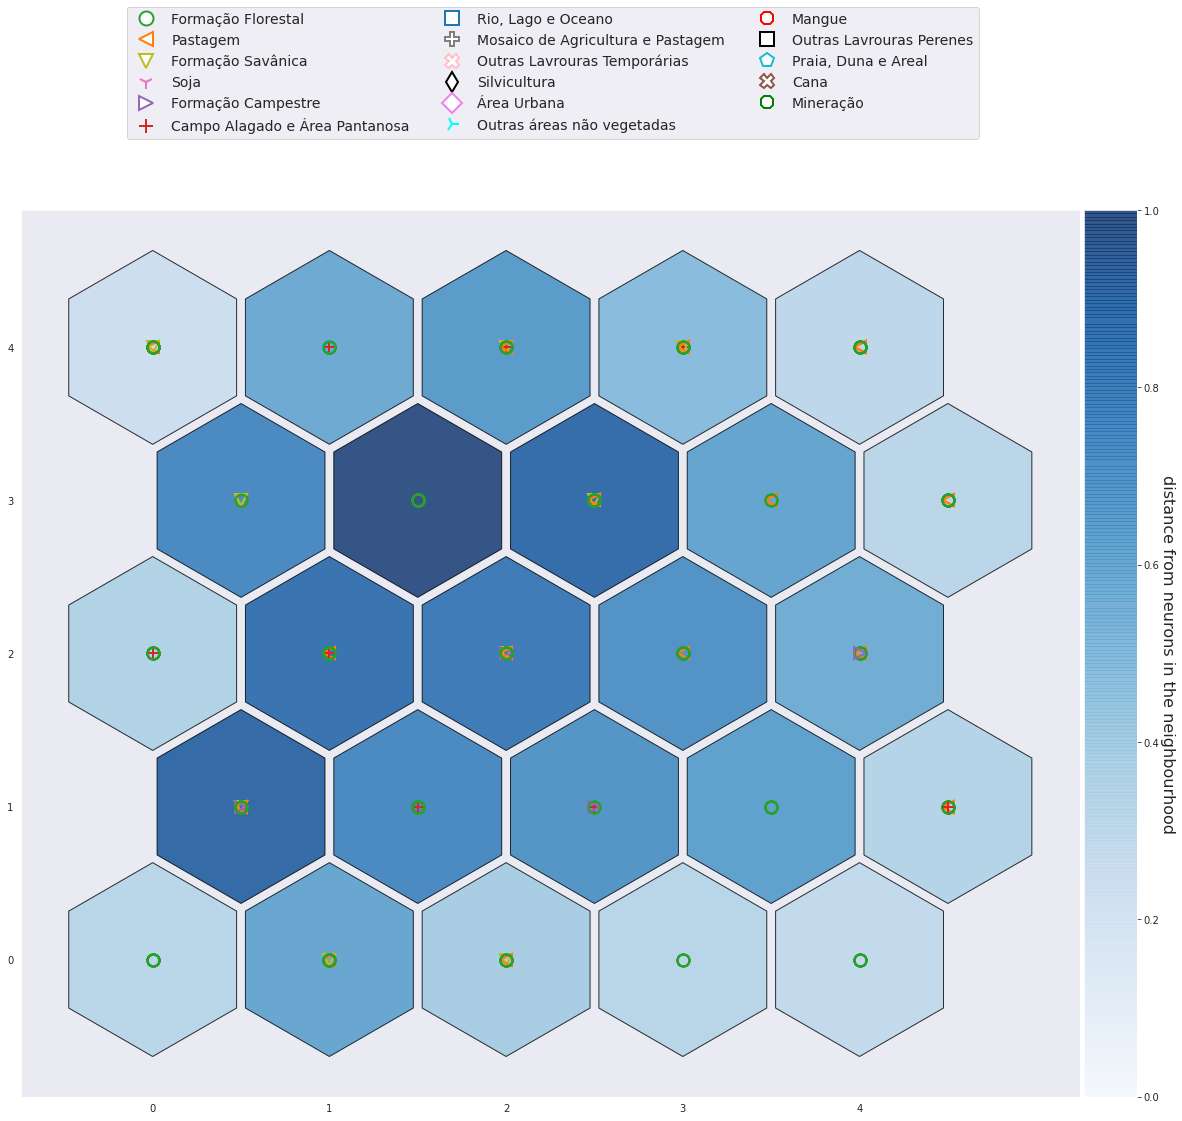

In [ ]:
create_hexagonal_topology_with_markers(som_1, X, y1, xx_1, yy_1, umatrix_1, weights_1, legend_elements, enum_errors_1,'teste')

In [ ]:
create_hexagonal_topology__makers_html(som_1, X, y1, xx_1, yy_1, umatrix_1, weights_1, legend_elements, enum_errors_1)

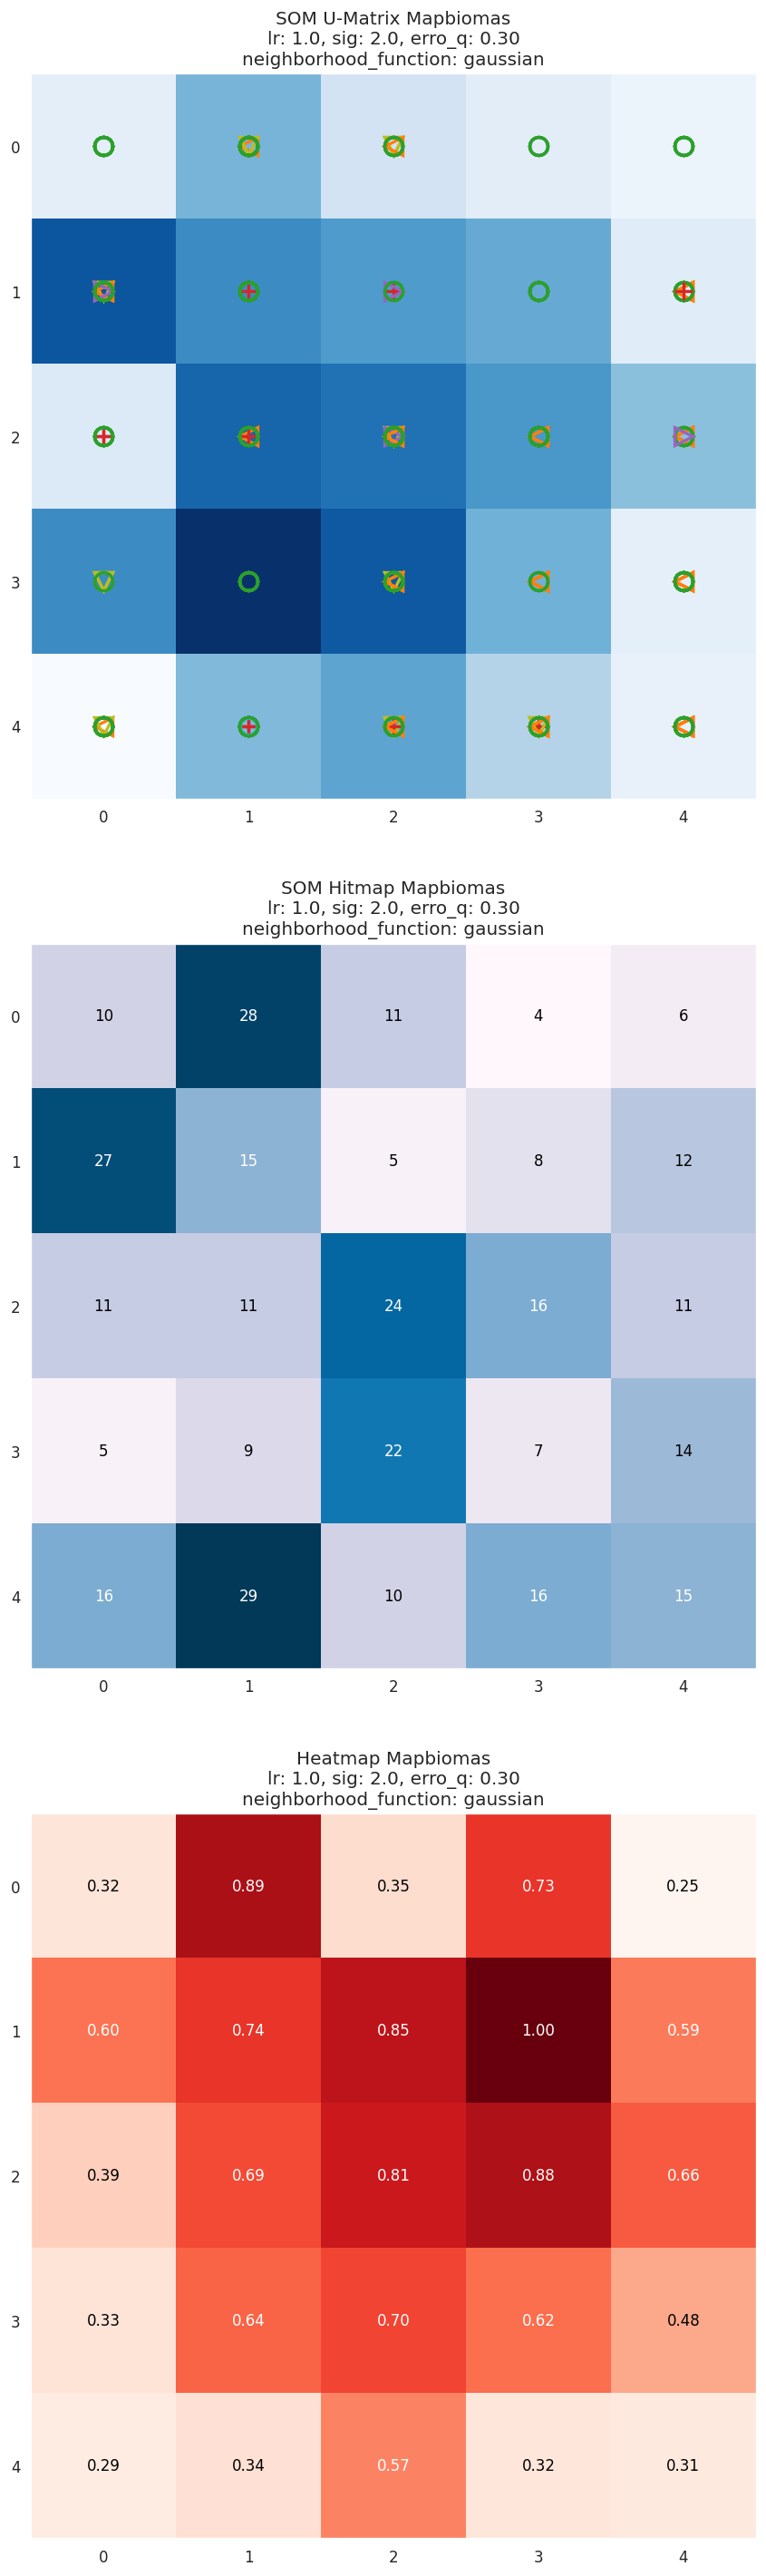

In [ ]:
create_umatrix_hitmap_heatmap(som_1, X, enum_errors_1, y1)

### Cálculo das médias por cluster

In [ ]:
co2_heatmap =  [1,2,3,5,6,7,8,11,12,13,14,15,16,17,18,24]
len(co2_heatmap)

16

In [ ]:
cluster_mean = gpd.GeoDataFrame(columns=['cluster_index','xco2','sif','lai'])

In [ ]:
group = df_result.groupby('cluster_index')

In [ ]:
group.get_group(3).xco2.mean()

0.17806907193377902

In [ ]:
list_clu = []
list_co2 = []
list_sif = []
list_lai = []
for cluster in list_clusters:
    list_clu.append(cluster)
    list_co2.append(group.get_group(cluster).xco2.mean())
    list_sif.append(group.get_group(cluster).sif.mean())
    list_lai.append(group.get_group(cluster).Lai_500m.mean())
cluster_mean['cluster_index'] = list_clu
cluster_mean['xco2'] = list_co2
cluster_mean['sif'] = list_sif
cluster_mean['lai'] = list_lai

In [ ]:
# cluster_mean = cluster_mean.set_index('cluster_index')

In [ ]:
cluster_mean = cluster_mean.sort_values(['cluster_index'])

In [ ]:
t = cluster_mean.iloc[:, 0:2].values

In [ ]:
#+ scale_color_manual(values=classPalette)
#     + scale_fill_manual(values=classPalette)

###Gráficos

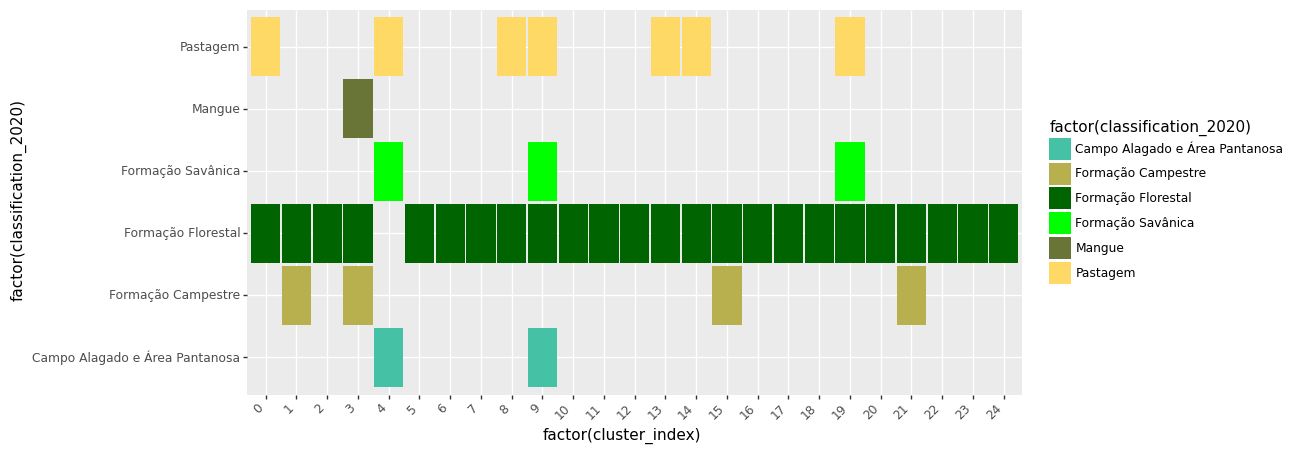

<ggplot: (8775044833293)>

In [ ]:
(
    ggplot(a)
    + geom_tile(aes('factor(cluster_index)', 'factor(classification_2020)', fill='factor(classification_2020)',width=.95, height=.95),show_legend=True)
     + scale_fill_manual(values=classPaletteSt)
     + theme(figure_size=(10,5), axis_text_x=element_text(rotation=45, hjust=1))
)

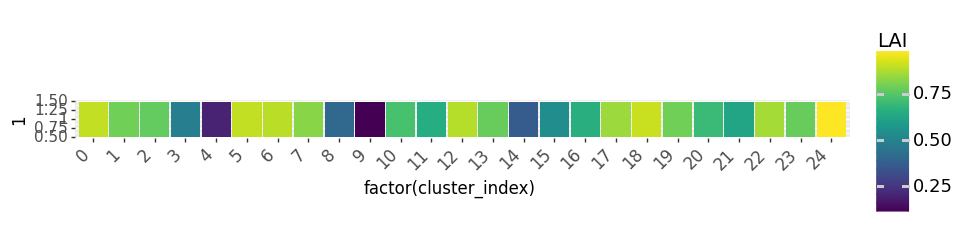

<ggplot: (8775042076922)>

In [ ]:
(
    ggplot(cluster_mean)
    + geom_tile(aes('factor(cluster_index)', 1, fill='lai',width=.95, height=.95),show_legend=True)
    + theme(figure_size=(10,0.5), axis_text_x=element_text(rotation=45, hjust=1,size=12), axis_text_y=element_text(size=11),axis_title=element_text(size= 12),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='LAI')
)

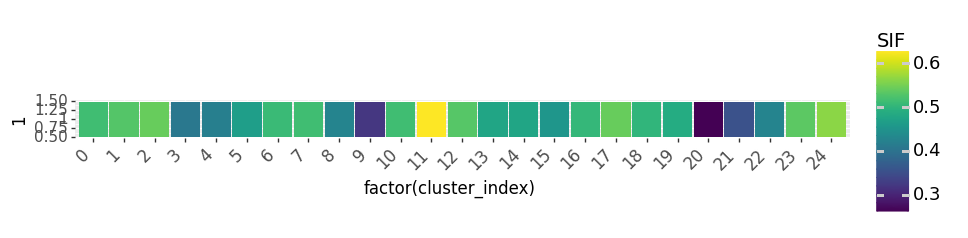

<ggplot: (8775042207443)>

In [ ]:
(
    ggplot(cluster_mean)
    + geom_tile(aes('factor(cluster_index)', 1, fill='sif',width=.95, height=.95),show_legend=True)
    + theme(figure_size=(10,0.5), axis_text_x=element_text(rotation=45, hjust=1,size=12), axis_text_y=element_text(size=11),axis_title=element_text(size= 12),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='SIF')
)

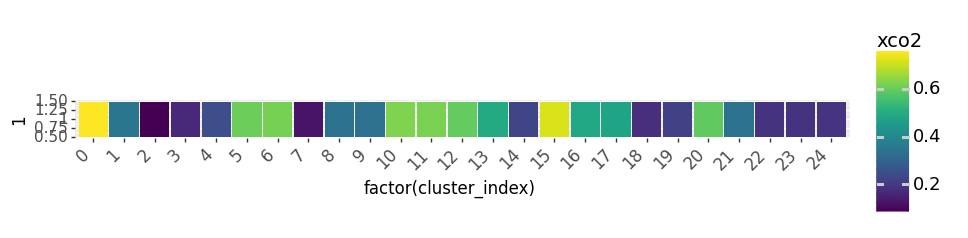

<ggplot: (8775043070841)>

In [ ]:
(
    ggplot(cluster_mean)
    + geom_tile(aes('factor(cluster_index)', 1, fill='xco2',width=.95, height=.95),show_legend=True)
    + theme(figure_size=(10,0.5), axis_text_x=element_text(rotation=45, hjust=1,size=12),axis_text_y=element_text(size=11),axis_title=element_text(size= 12),legend_title=element_text(size=14),legend_text=element_text(size=13))
)

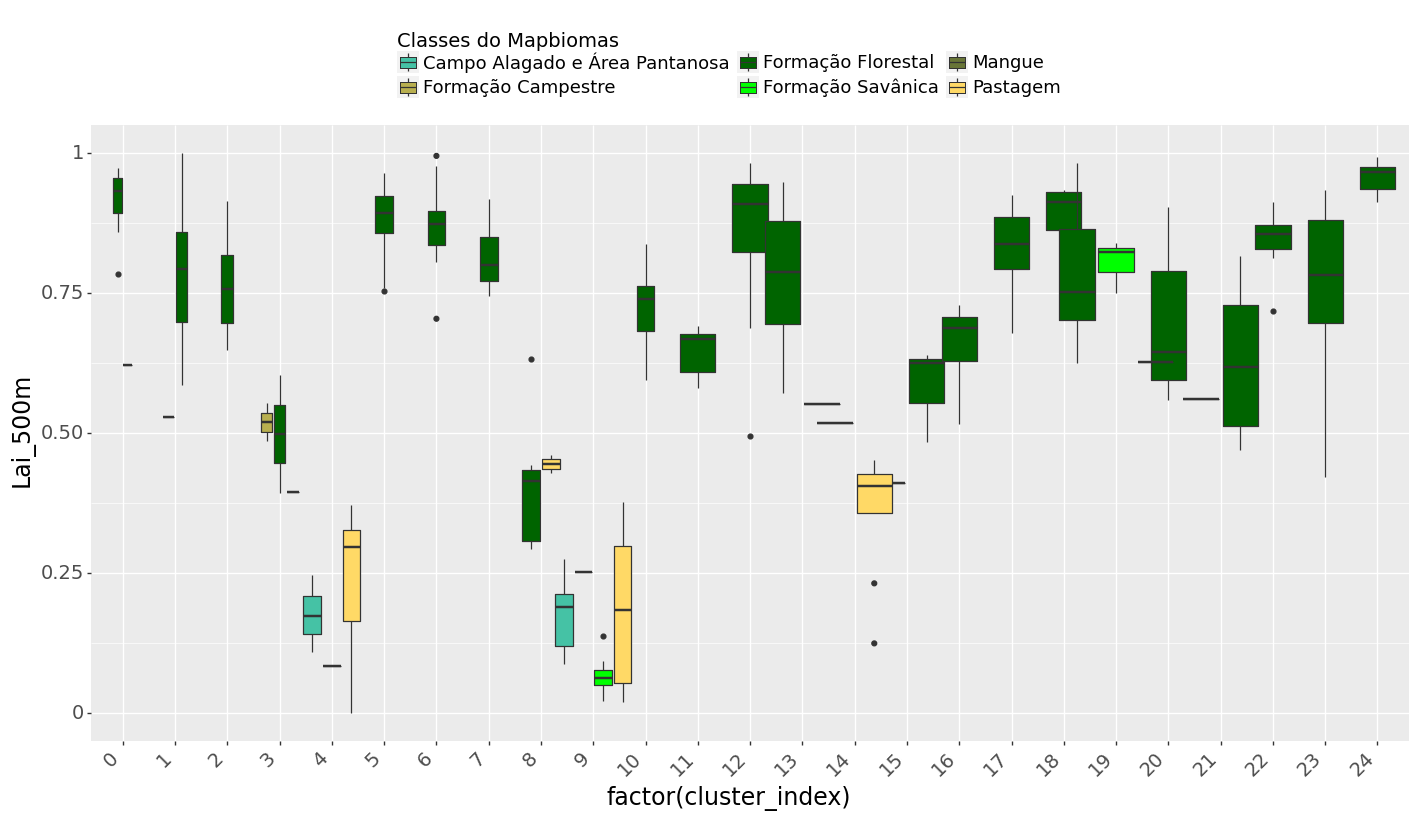

<ggplot: (8775042123533)>

In [ ]:
(
    ggplot(a, aes('factor(cluster_index)', 'Lai_500m', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,8), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position='top',legend_title=element_text(size=14),legend_text=element_text(size=13),legend_direction='horizontal')
    + labs(fill='Classes do Mapbiomas')
)

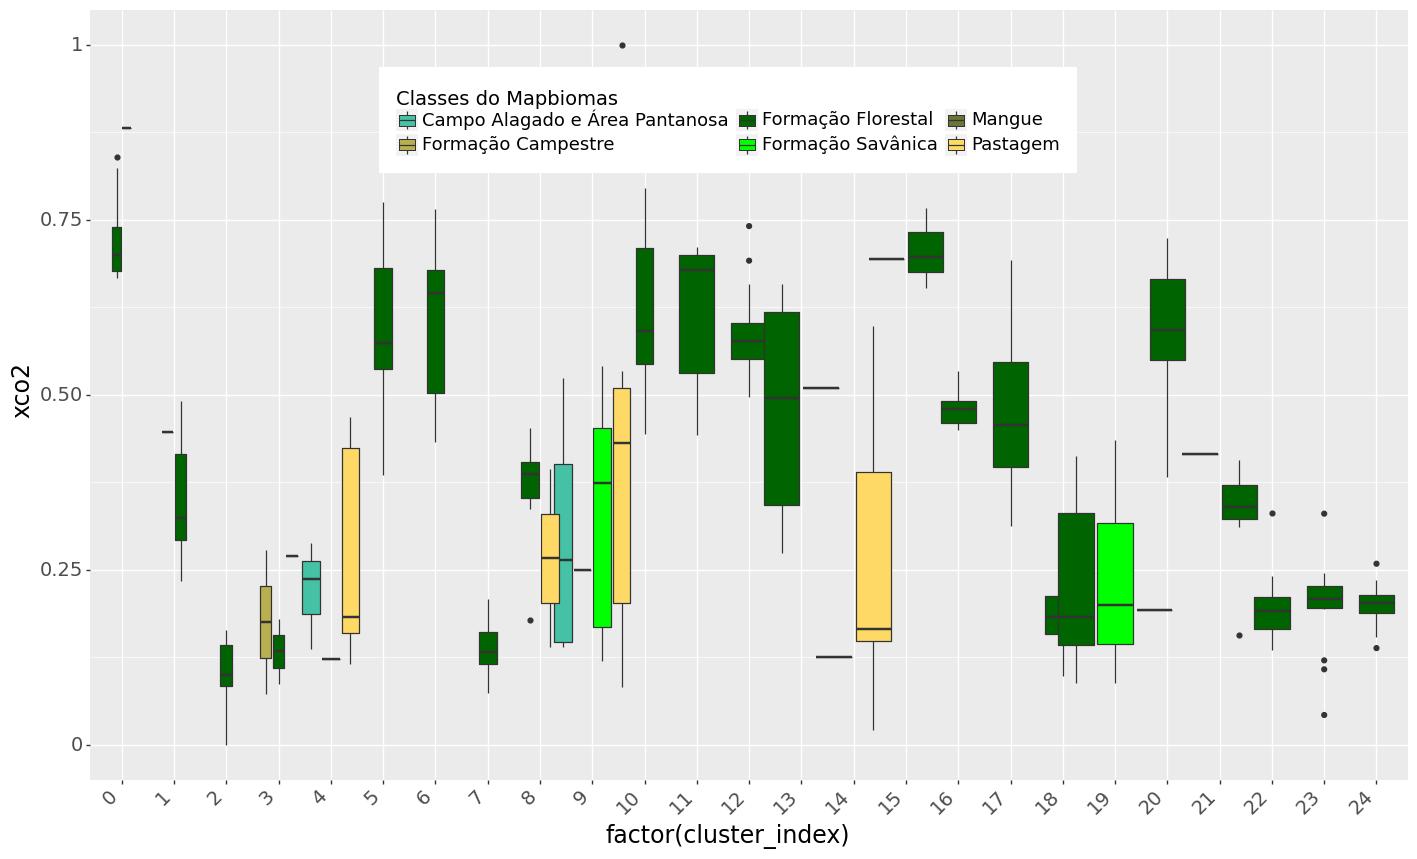

<ggplot: (8775042004471)>

In [ ]:
(
    ggplot(a, aes('factor(cluster_index)', 'xco2', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.5,.77),legend_title=element_text(size=14),legend_text=element_text(size=13),legend_direction='horizontal')
    + labs(fill='Classes do Mapbiomas')
)

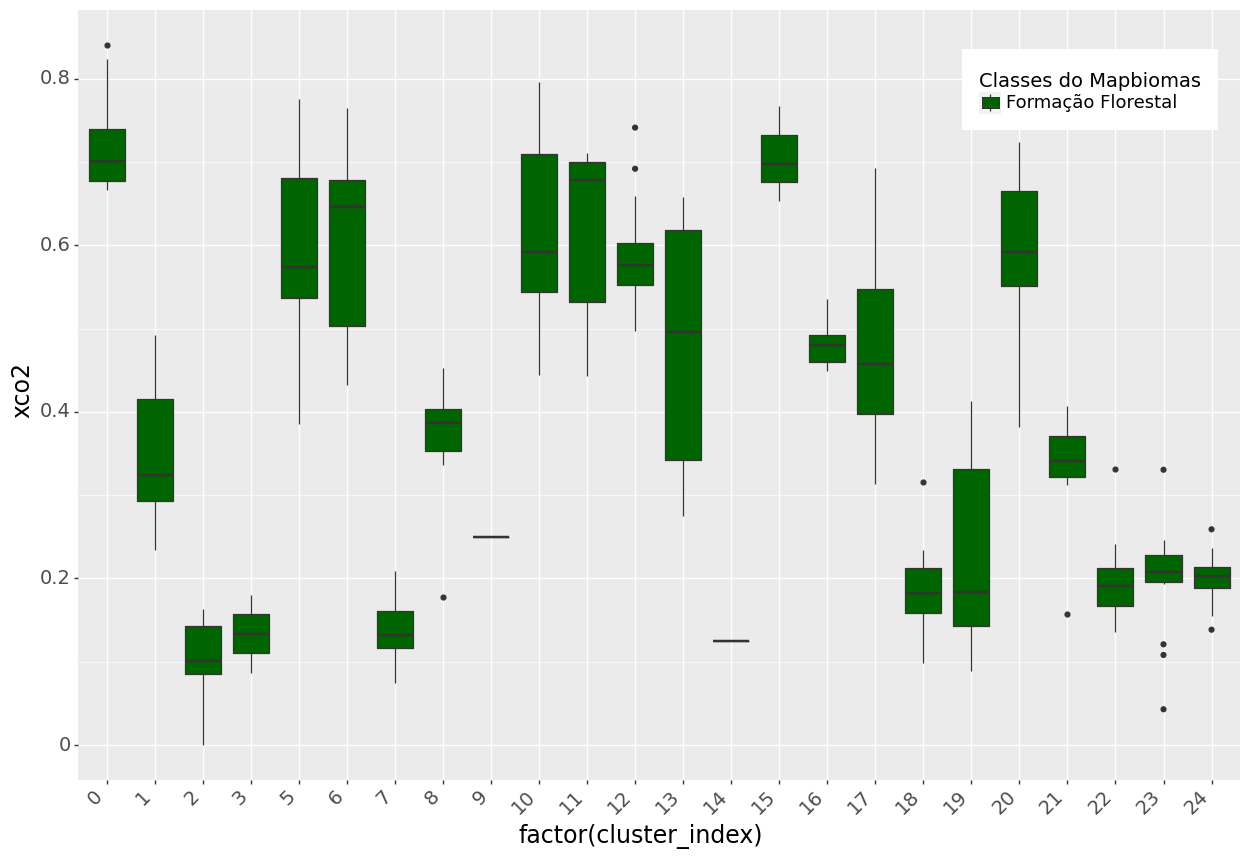

<ggplot: (8775044803597)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Formação Florestal'], aes('factor(cluster_index)', 'xco2', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(15,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

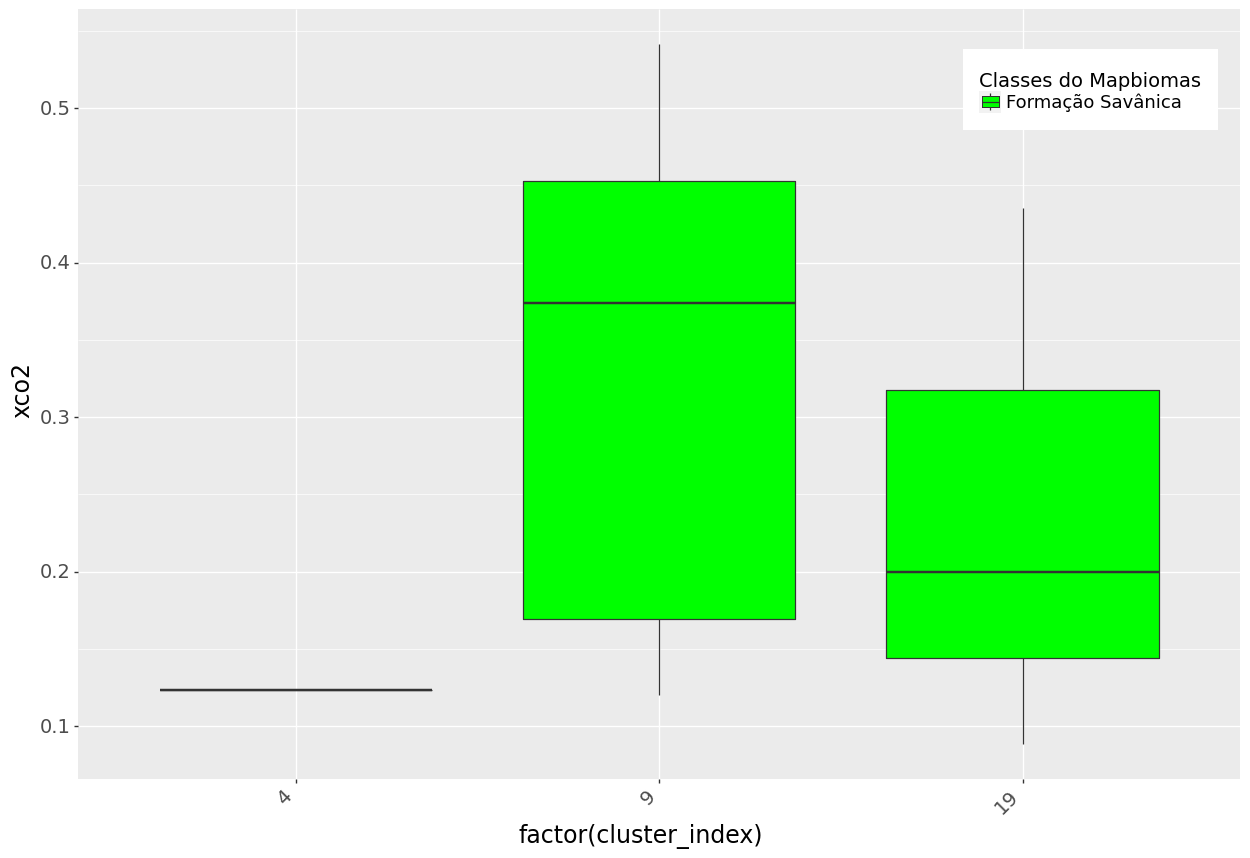

<ggplot: (8775044228193)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Formação Savânica'], aes('factor(cluster_index)', 'xco2', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(15,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

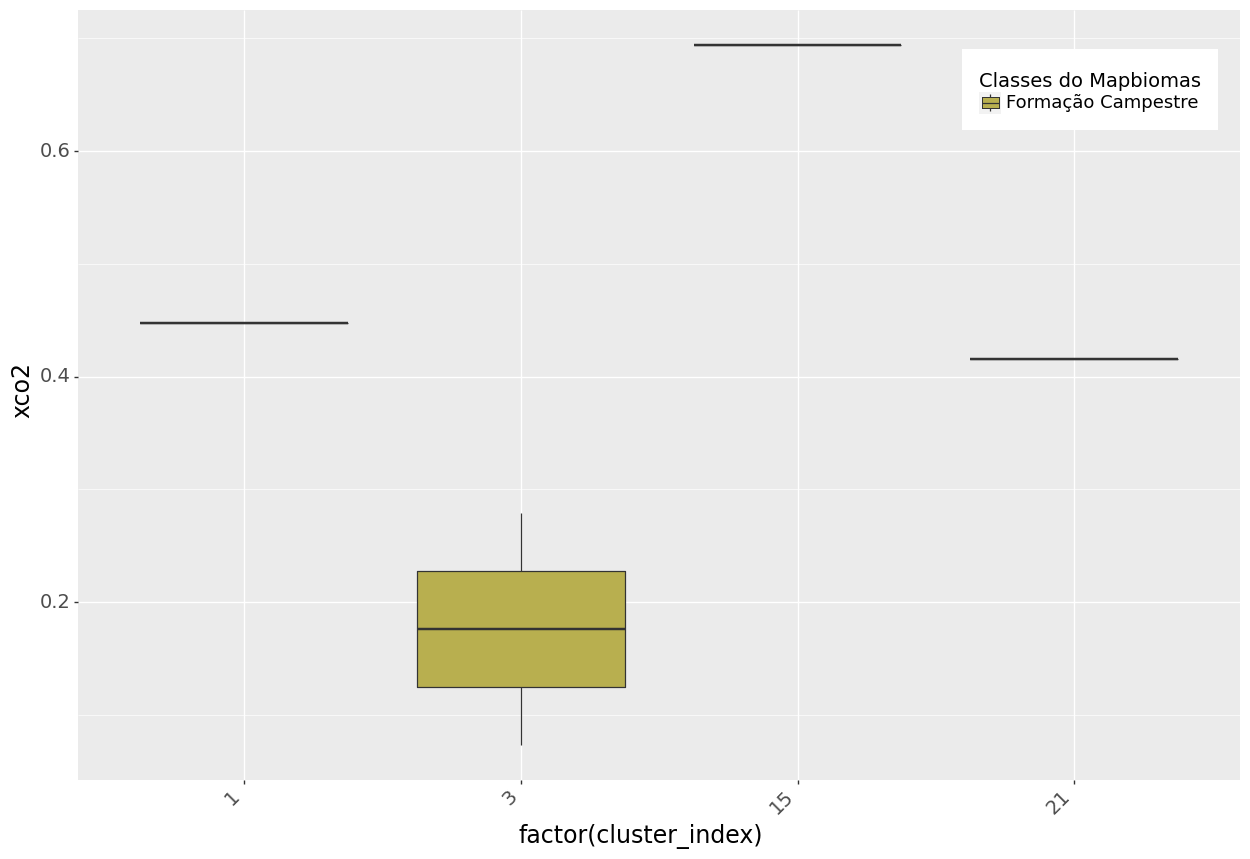

<ggplot: (8775042834372)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Formação Campestre'], aes('factor(cluster_index)', 'xco2', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(15,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

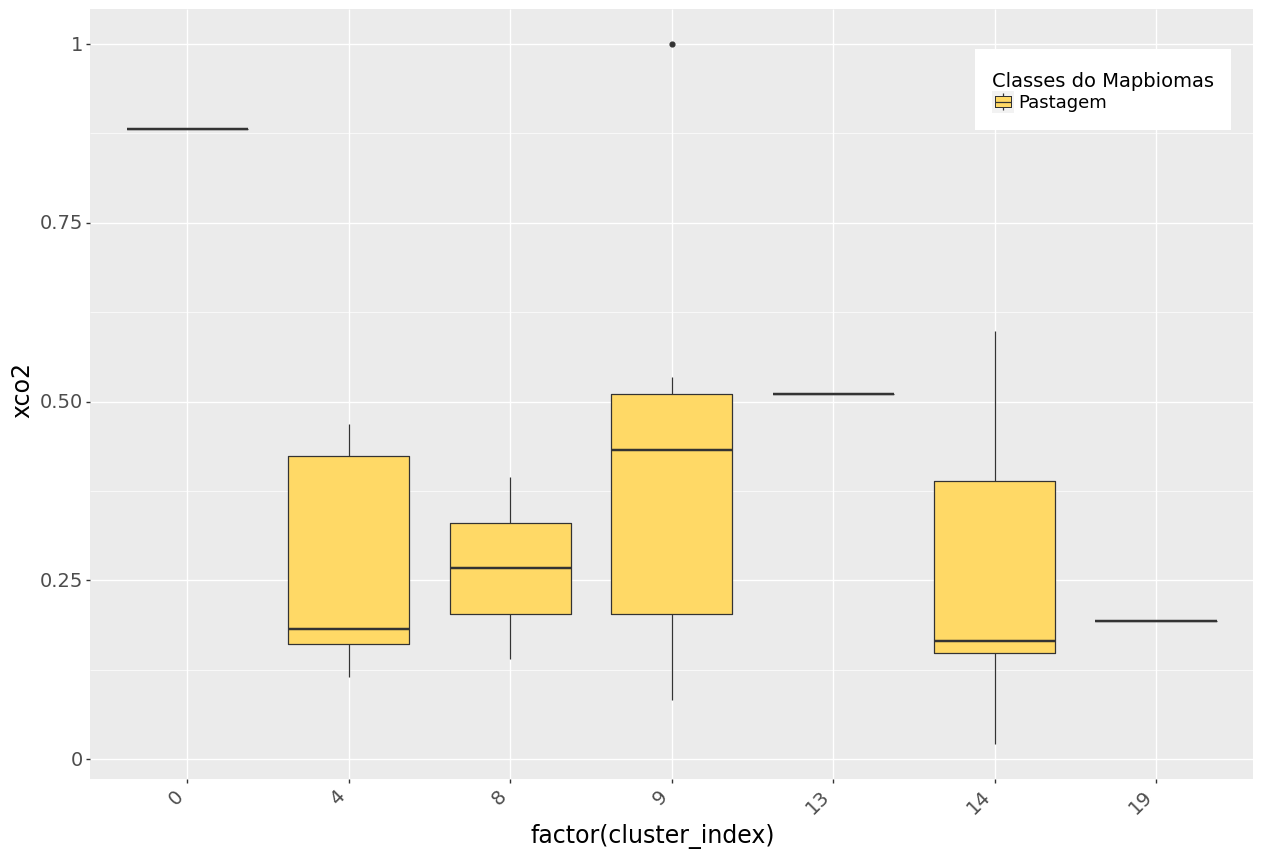

<ggplot: (8775042826490)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Pastagem'], aes('factor(cluster_index)', 'xco2', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(15,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

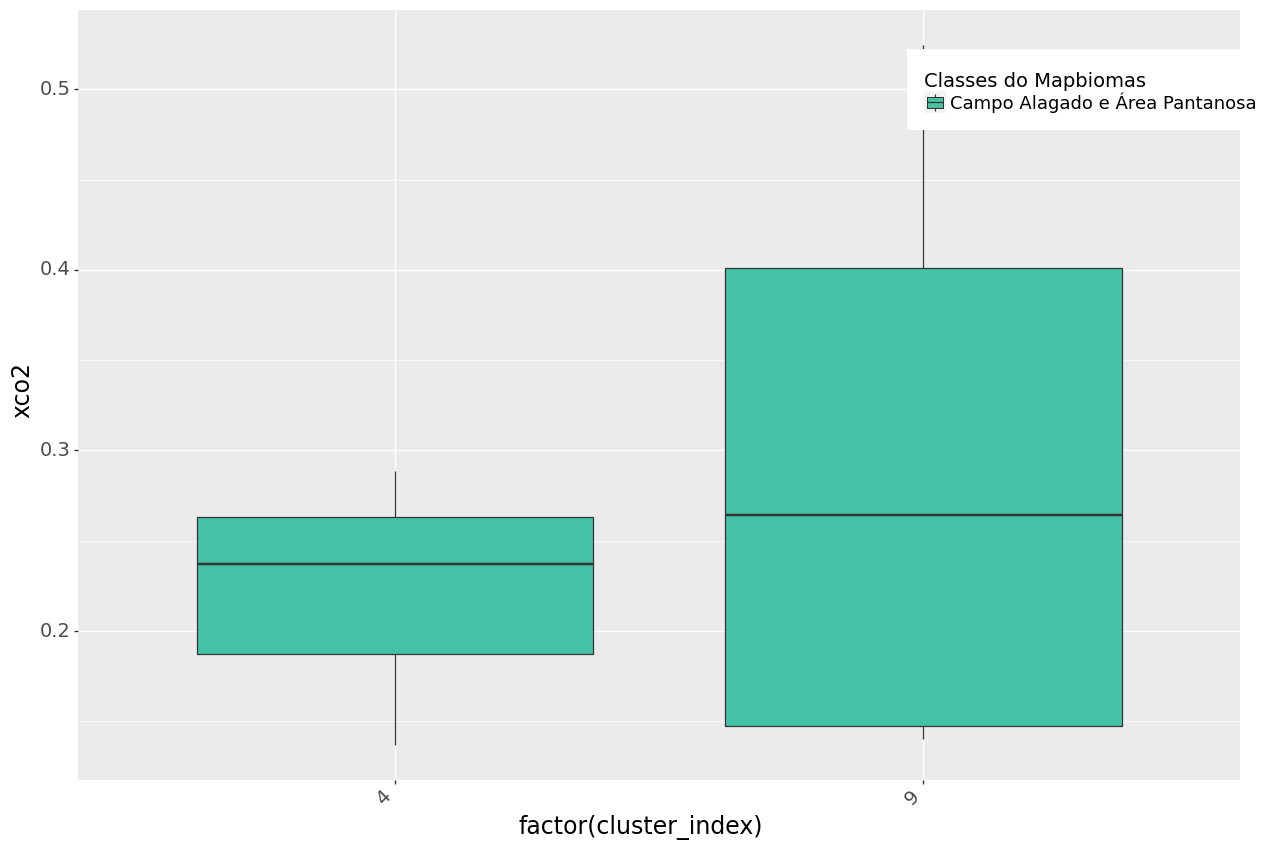

<ggplot: (8775042848747)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Campo Alagado e Área Pantanosa'], aes('factor(cluster_index)', 'xco2', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(15,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

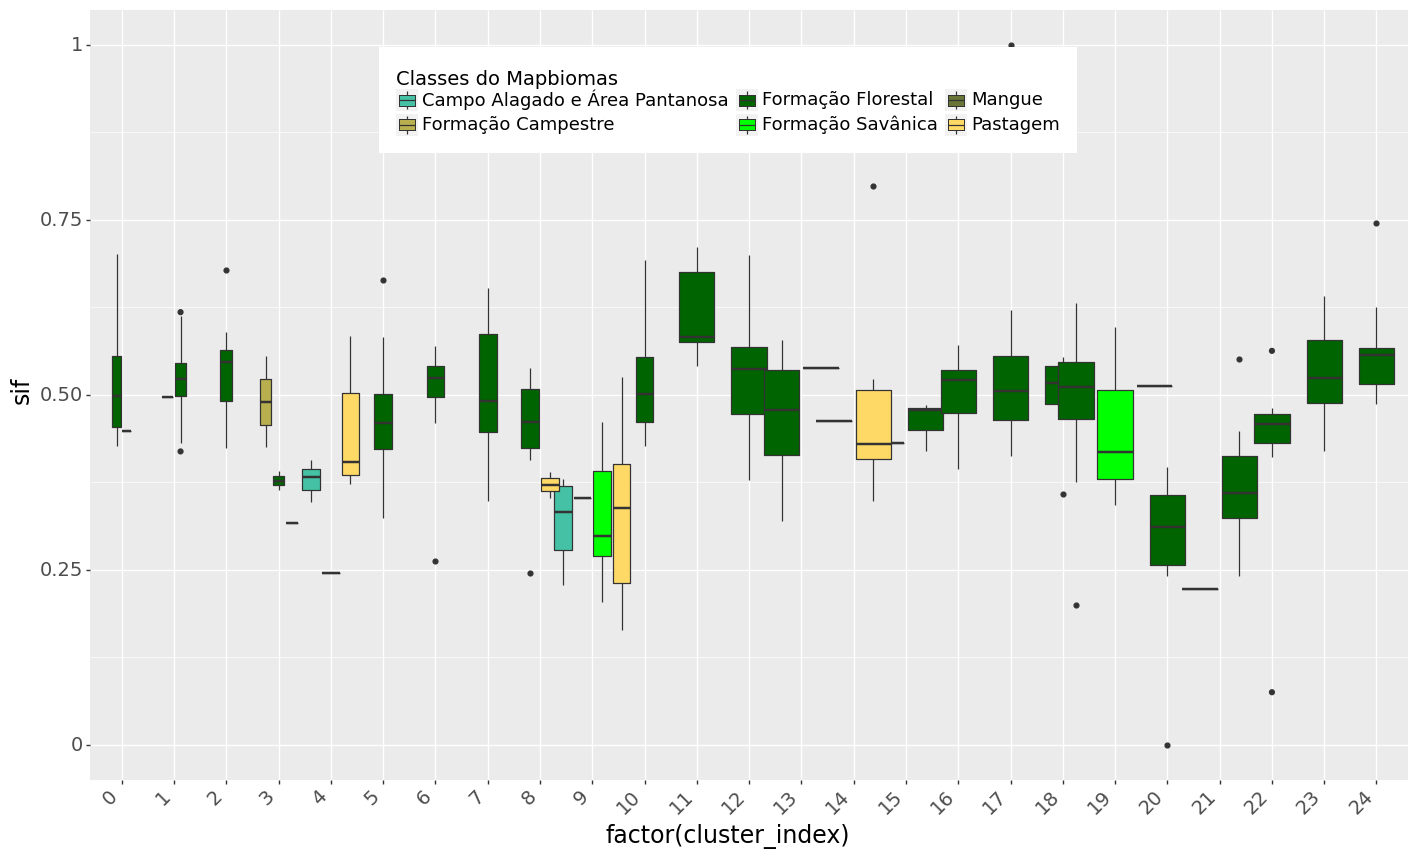

<ggplot: (8775042826292)>

In [ ]:
(
    ggplot(a, aes('factor(cluster_index)', 'sif', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.5,.79),legend_title=element_text(size=14),legend_text=element_text(size=13),legend_direction='horizontal')
    + labs(fill='Classes do Mapbiomas')
)

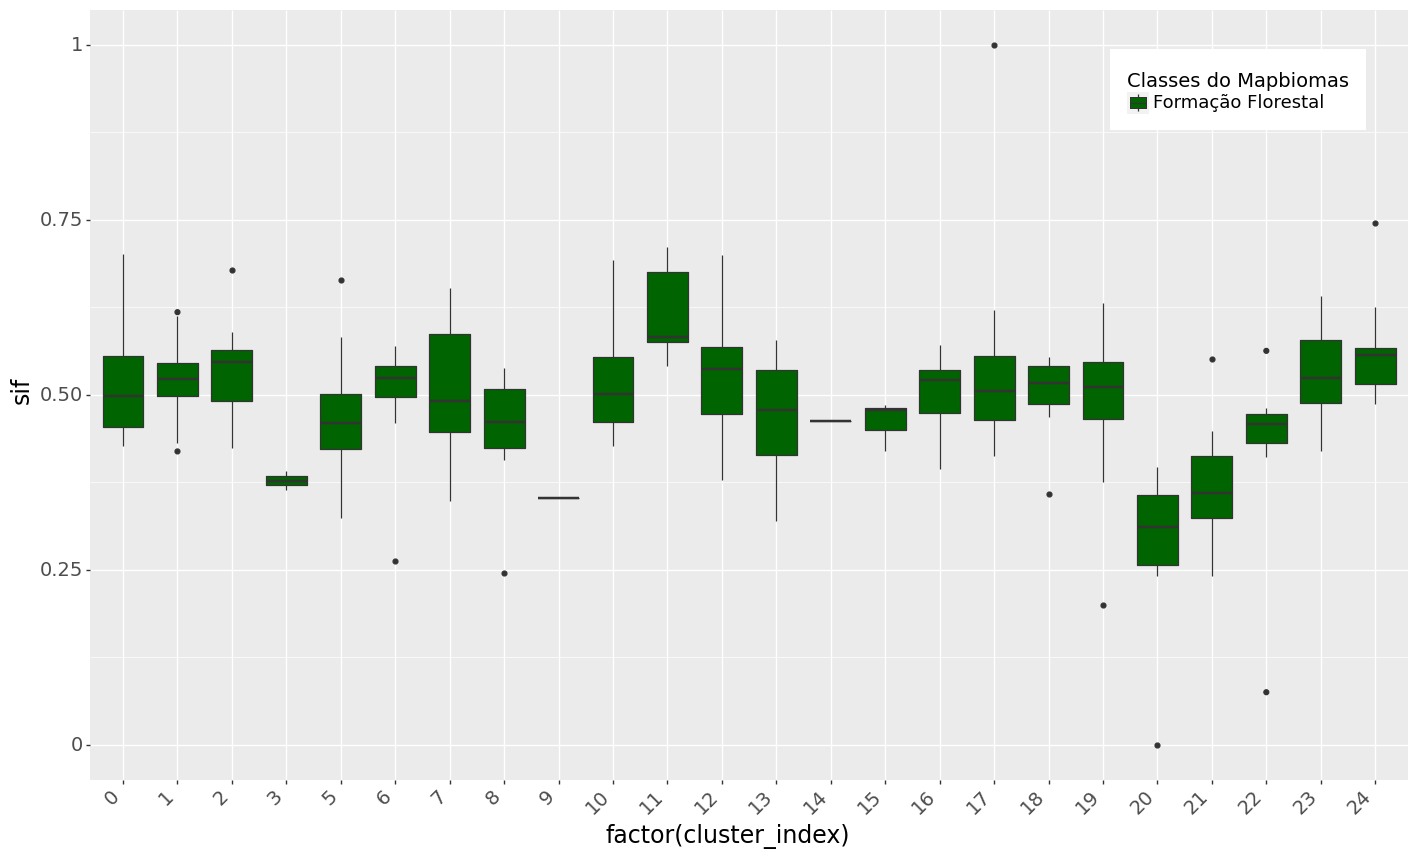

<ggplot: (8775045474768)>

In [ ]:

(
    ggplot(a[a.classification_2020 == 'Formação Florestal'], aes('factor(cluster_index)', 'sif', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

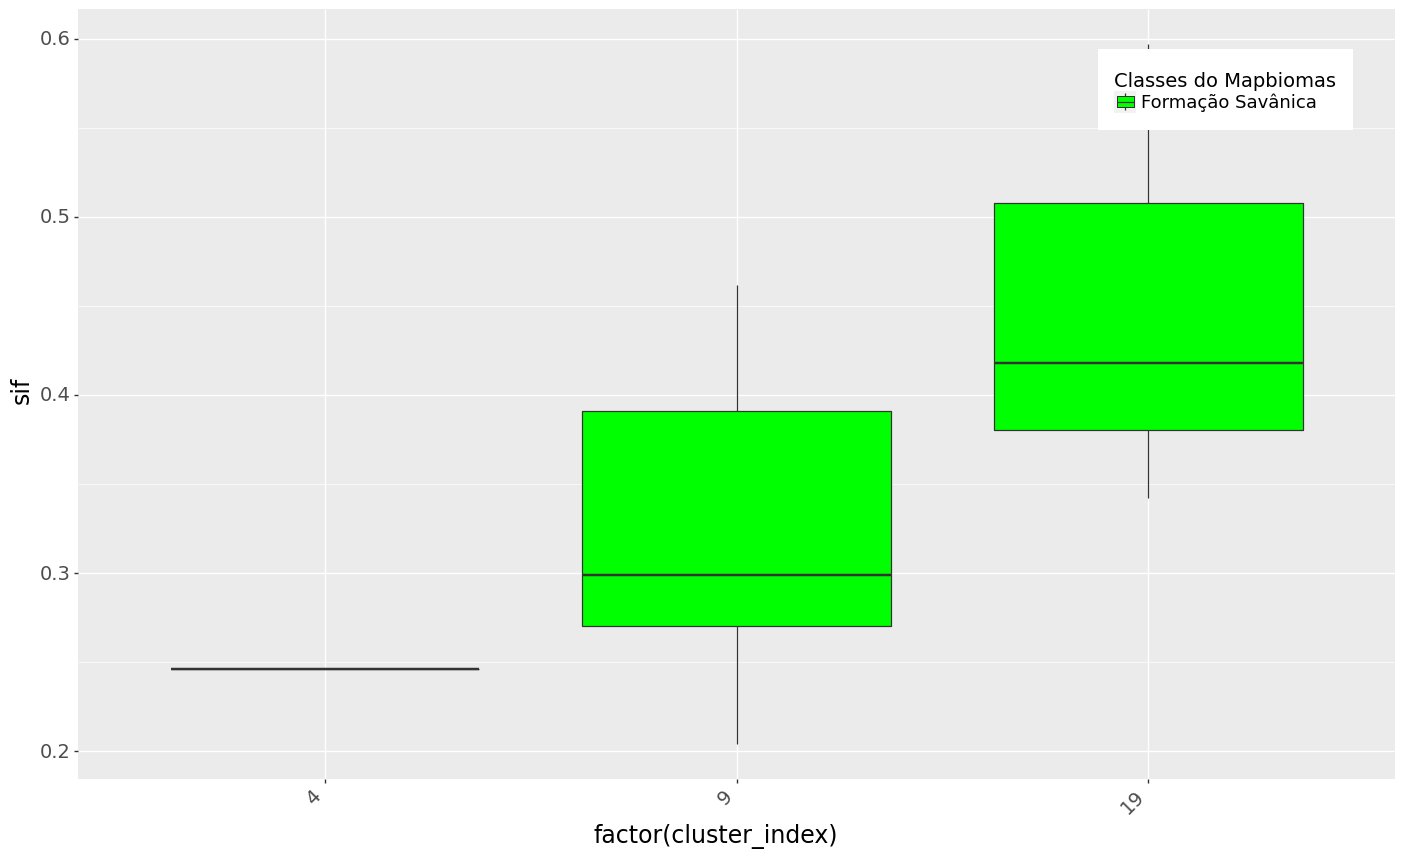

<ggplot: (8775042272181)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Formação Savânica'], aes('factor(cluster_index)', 'sif', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

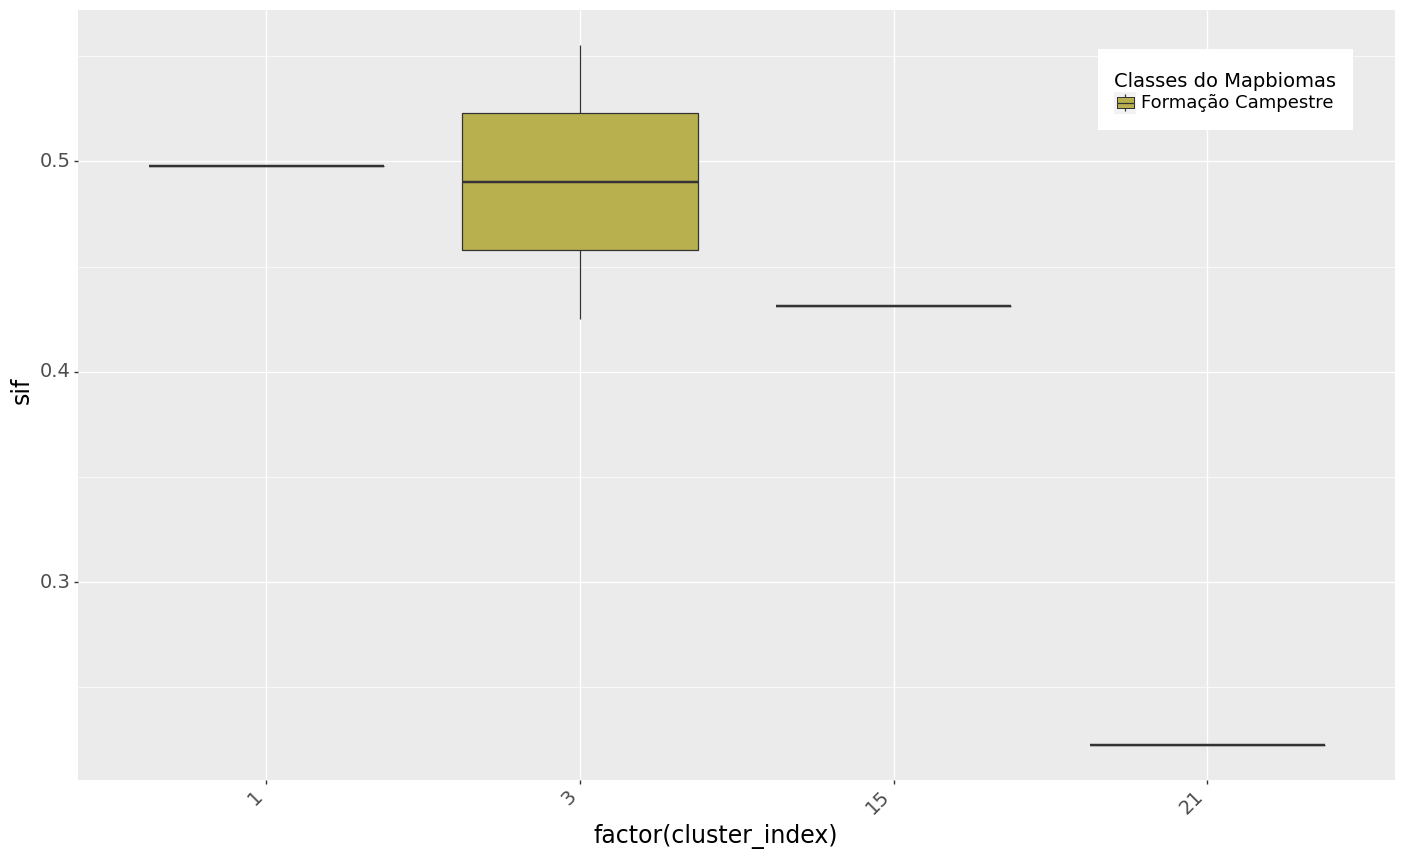

<ggplot: (8775048209421)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Formação Campestre'], aes('factor(cluster_index)', 'sif', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

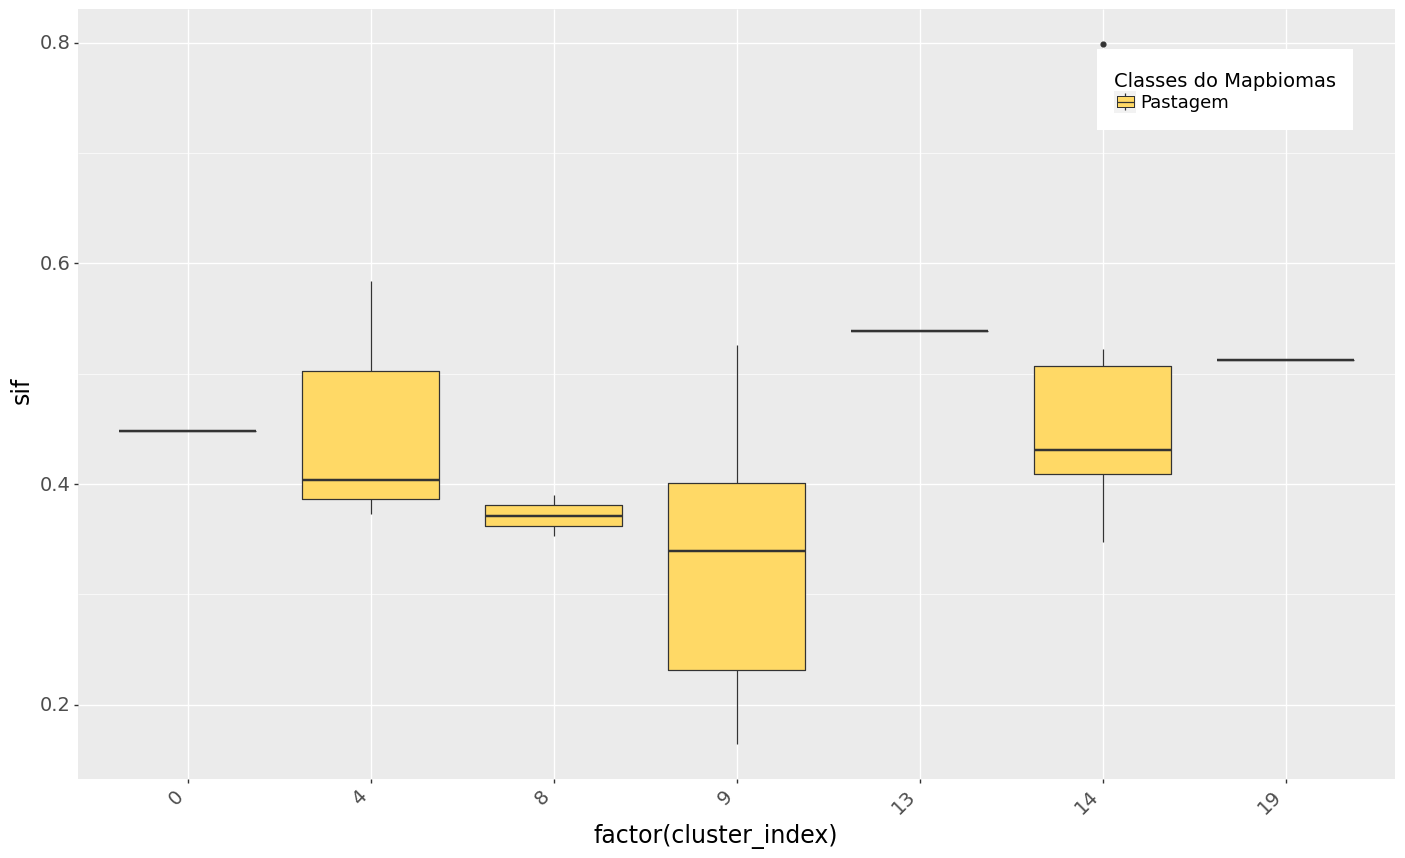

<ggplot: (8775045822133)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Pastagem'], aes('factor(cluster_index)', 'sif', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

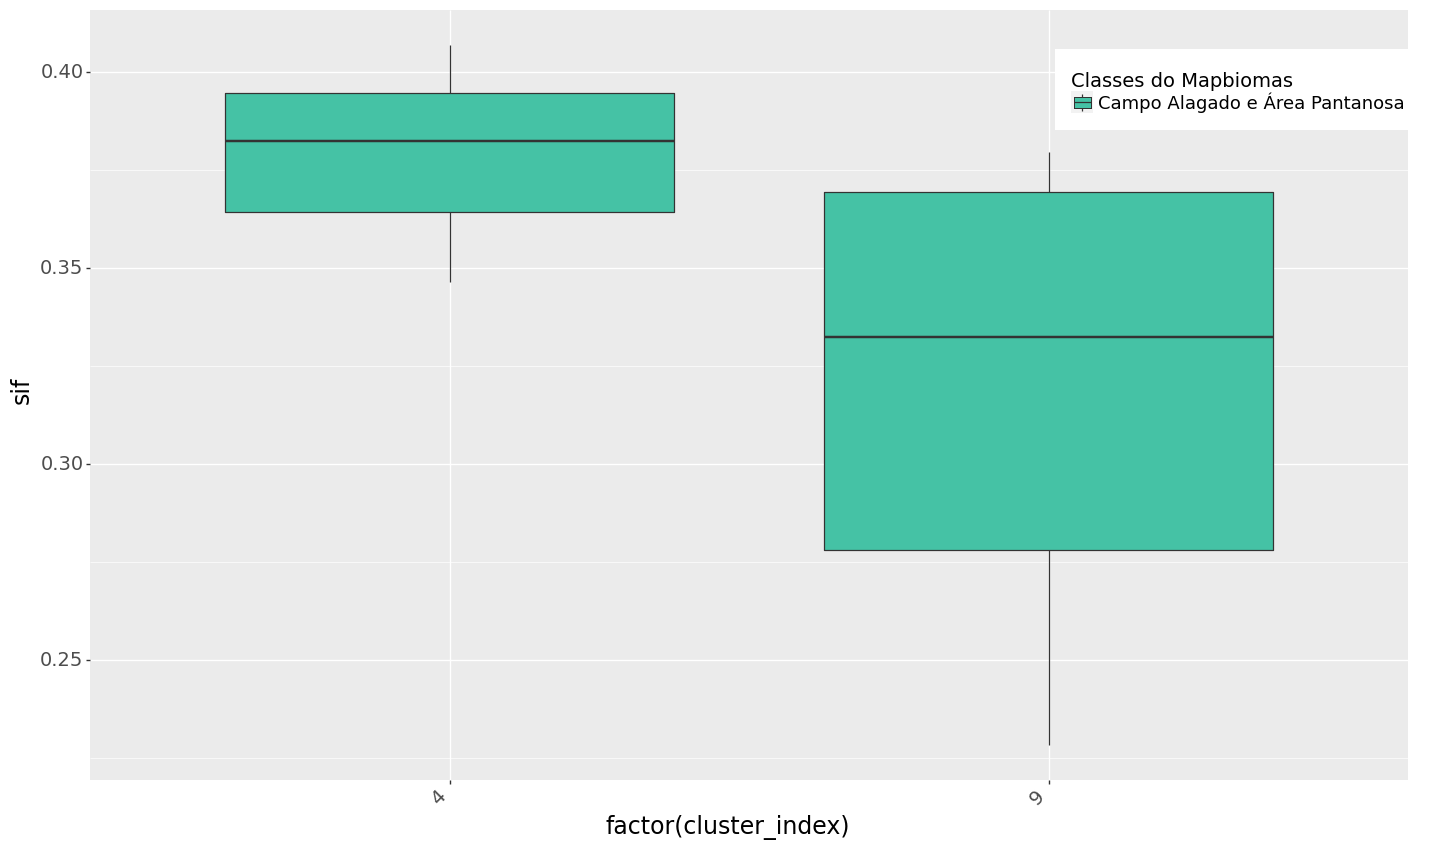

<ggplot: (8775044421012)>

In [ ]:
(
    ggplot(a[a.classification_2020 == 'Campo Alagado e Área Pantanosa'], aes('factor(cluster_index)', 'sif', fill='factor(classification_2020)'))
    + geom_boxplot(aes(width=.95, height=.95),show_legend=True)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(17,10), axis_text_x=element_text(rotation=45, hjust=1,size=14), axis_text_y=element_text(size=14),axis_title=element_text(size=17),legend_position=(.8,.80),legend_title=element_text(size=14),legend_text=element_text(size=13))
    + labs(fill='Classes do Mapbiomas')
)

In [ ]:
a.columns

Index(['Lai_500m', 'xco2', 'xco2_uncer', 'sif', 'sif_unc', 'latitude',
       'longitude', 'LaiStdDev', 'cluster_index', 'system_ind', 'geometry',
       'system:index', 'classification_1985', 'classification_1986',
       'classification_1987', 'classification_1988', 'classification_1989',
       'classification_1990', 'classification_1991', 'classification_1992',
       'classification_1993', 'classification_1994', 'classification_1995',
       'classification_1996', 'classification_1997', 'classification_1998',
       'classification_1999', 'classification_2000', 'classification_2001',
       'classification_2002', 'classification_2003', 'classification_2004',
       'classification_2005', 'classification_2006', 'classification_2007',
       'classification_2008', 'classification_2009', 'classification_2010',
       'classification_2011', 'classification_2012', 'classification_2013',
       'classification_2014', 'classification_2015', 'classification_2016',
       'classification_2

In [ ]:
list_class = ['classification_2015', 'classification_2016', 'classification_2017',
       'classification_2018', 'classification_2019', 'classification_2020']

In [ ]:
df_count = pd.DataFrame(columns=['cluster_index','year','count'])

In [ ]:
for year_class in list_class:
  print('year_class',year_class)
  for cluster in list_clusters:
    print('cluster',cluster)
    print(a[a.cluster_index == cluster][year_class].value_counts())

year_class classification_2015
cluster 19
Formação Florestal    12
Formação Savânica      3
Pastagem               1
Name: classification_2015, dtype: int64
cluster 14
Pastagem              9
Formação Florestal    1
Name: classification_2015, dtype: int64
cluster 18
Formação Florestal    7
Name: classification_2015, dtype: int64
cluster 22
Formação Florestal    11
Name: classification_2015, dtype: int64
cluster 23
Formação Florestal    14
Name: classification_2015, dtype: int64
cluster 9
Formação Savânica                 13
Pastagem                           8
Campo Alagado e Área Pantanosa     7
Formação Florestal                 1
Name: classification_2015, dtype: int64
cluster 4
Pastagem              12
Rio, Lago e Oceano     2
Formação Florestal     1
Formação Savânica      1
Name: classification_2015, dtype: int64
cluster 8
Formação Florestal    7
Pastagem              2
Name: classification_2015, dtype: int64
cluster 7
Formação Florestal    11
Name: classification_2015, dtype: in